# Here I add the materials science specific functions

Terminology:
- SIC: symmetry independent configuration
- SEC: symmetry equivalent configuration

Work in progress:
- DFT calculations
    - graphene H clusters of different sizes to check the band gap

To discuss:
- comparison energy and probability QUBO/Rydberg
- final structures
- sic calculations
    - 1024 - > 288 for 10 C atoms
    - 16777216 -> ? (in progress)
- DFT calculations to train the QUBO model

Questions:
- How large can we go with the OB structure?


- [Build the OB Structures](#build_structures)
- [CRYSTAL](#crystal)
- [PySCF](#pyscf)
- [Boltzmann distribution random](#boltzmann_random)
- [Build the test/train set](#test_train)
- [Build the QUBO model](#build_qubo)
- [Map to Rydberg Atoms (any R)](#mapping)
- [Classical Thermodynamic Analysis](#classical_thermo)
- [Quantum Hardware](#quantum_hardware)
- 
- [Final structures](#final_structures)
    - [Small](#small)
    - [Large](#large)
- [Build the reference 2x2 graphene supercell](#build_structure)
- [Direct mapping](#mapping)
- [Symmetry analysis](#symmetry)
- [Exhaustive search](#es)
- [Non-periodic boudnary conditions](#no_pbc)
- [Build the test/train set](#test_train)
- [Periodic boudnary conditions](#pbc)

In [2]:
from pymatgen.core.structure import Structure, Molecule
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer, PointGroupAnalyzer
import copy
import numpy as np
from ase.visualize import view
from pymatgen.io.ase import AseAtomsAdaptor
import itertools
from scipy import constants
import math
import shutil as sh

from functions_final import *

# import sys
# sys.path.insert(1,'/Users/brunocamino/Desktop/Imperial/crystal-code-tools/CRYSTALpytools/CRYSTALpytools/')
# from crystal_io import *
# from convert import *

#from CRYSTALpytools.convert import *
#from CRYSTALpytools.crystal_io import *

import matplotlib.pyplot as plt

k_b = constants.physical_constants['Boltzmann constant in eV/K'][0]
plt.style.use('tableau-colorblind10')
def vview(structure):
    view(AseAtomsAdaptor().get_atoms(structure))
    
import functools as ft
import numpy as np

from braket.ahs.atom_arrangement import AtomArrangement
from braket.timings.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

from braket.analog_hamiltonian_simulator.rydberg.constants import (
    RYDBERG_INTERACTION_COEF,
    SPACE_UNIT,
    TIME_UNIT,
)

from braket.analog_hamiltonian_simulator.rydberg.rydberg_simulator_helpers import (
    get_blockade_configurations,
    _get_sparse_ops,
    _get_coefs,
    _get_rabi_dict,
    _get_detuning_dict,
    _get_sparse_from_dict
)

from braket.analog_hamiltonian_simulator.rydberg.rydberg_simulator_unit_converter import (
    convert_unit,
)

from pyscf import gto, dft

In [86]:
import numpy as np
from scipy.optimize import minimize

def cost_function(x, original_distances, desired_distances):
    # Reshape the optimization variable into a transformation matrix
    transformation_matrix = x.reshape(3, 3)
    
    # Apply the transformation matrix to the original coordinates
    transformed_coordinates = np.dot(original_coordinates, transformation_matrix)
    
    # Calculate the distances between all pairs of transformed coordinates
    transformed_distances = np.linalg.norm(transformed_coordinates[:, None, :] - transformed_coordinates, axis=-1)
    
    # Calculate the difference between the transformed and desired distance matrices
    difference = transformed_distances - desired_distances
    
    # Compute the sum of squared differences as the cost
    cost = np.sum(difference**2)
    
    return cost

original_distances = graphene_mol.distance_matrix

# Define the original Cartesian coordinates
original_coordinates = np.array(graphene_mol.cart_coords)  # Your original coordinates here

# Define the desired distance matrix
desired_distances = np.array(graphene_mol.distance_matrix*2)  # Your desired distance matrix here

# Flatten the transformation matrix for optimization
initial_guess = np.eye(3).flatten()

# Optimize the transformation matrix to minimize the cost function
result = minimize(cost_function, initial_guess, args=(original_distances, desired_distances))

# Reshape the optimized variable into the transformation matrix
optimized_transformation_matrix = result.x.reshape(3, 3)

# Apply the optimized transformation matrix to the original coordinates
rescaled_coordinates = np.dot(original_coordinates, optimized_transformation_matrix)


NameError: name 'graphene_mol' is not defined

In [88]:
def get_final_ryd_Hamiltonian_from_J(
    structure, 
    J,
    detuning = 125000000.0,
    J1=0.080403, 
    J2=0.019894,
    C6 = 5.42e-24
):
    """
        Return the Rydberg Hamiltonian for a given atom arrangement and a QUBO model, version 2
        
        
        Args:
            coords: The coordinates of atoms and we assume that the nearest neighbor distance is 1. 
            detuning: The detuning in the Rydberg Hamiltonian
            J1: The linear term in the QUBO
            J2: The nearest neighbor interaction in the QUBO
            C6: The Rydberg interaction constant
            
        Notes:
            In this version, we have only one formula for R, namely (C6/detuning * -J1/J2)**(1/6).
            We return ratio = abs(detuning / J1) to map the spectrums
            
    """
    
    num_atoms = len(structure.num_sites)
    
    # MAXIMISE C
    if J1 == 0:
        detuning = 0
#         R = 8e-6
    elif J1 < 0:
        detuning = abs(detuning)
    else:
        detuning = -abs(detuning)
    
    
    
    R = (C6/detuning * -J1/J2)**(1/6)
    ratio = abs(detuning/1e6 / J1)
    print(R)
    
    # We will define the Hamiltonian via a ficticious AHS program
    
    # Define the register 
    register = AtomArrangement()

    for coord in coords:
        register.add(np.array(coord) * R)
        
    # Define a const driving field with zero Rabi frequency, and 
    # max allowed detuning
    t_max = 4e-6
    Omega = TimeSeries().put(0.0, 0.0).put(t_max, 0.0)
    Delta = TimeSeries().put(0.0, detuning).put(t_max, detuning)
    phi = TimeSeries().put(0.0, 0.0).put(t_max, 0.0)
    
    drive = DrivingField(
        amplitude=Omega,
        phase=phi,
        detuning=Delta
    )
    
    program = AnalogHamiltonianSimulation(
        hamiltonian=drive,
        register=register
    )
    
    
    # Now extract the Hamiltonian as a matrix from the program
    
    program = convert_unit(program.to_ir())
        
    configurations = get_blockade_configurations(program.setup.ahs_register, 0.0)
    return R
    
#     rydberg_interaction_coef = RYDBERG_INTERACTION_COEF / ((SPACE_UNIT**6) / TIME_UNIT)
        
#     rabi_ops, detuning_ops, interaction_op, local_detuning_ops = _get_sparse_ops(
#         program, configurations, rydberg_interaction_coef
#     )
        
#     t_max_converted = program.hamiltonian.drivingFields[0].amplitude.time_series.times[-1]
#     rabi_coefs, detuning_coefs, local_detuing_coefs = _get_coefs(program, [0, t_max_converted])
    
# #     print(f"interaction_op={interaction_op}")
# #     print(f"detuning_ops[0]={detuning_ops[0]}")
# #     print(f"detuning_coefs[0][-1]={detuning_coefs[0][-1]}")
    
#     H = interaction_op - detuning_ops[0] * detuning_coefs[0][-1]
    
#     # H is diagonal
#     diagH = np.real(H.diagonal())/ratio
    
#     min_val = min(diagH)
#     min_val_indices = [i for i in range(len(diagH)) if diagH[i]==min_val]
#     configs = [f'{index:0{num_atoms}b}' for index in min_val_indices]
    
    
#     return diagH, min_val, min_val_indices, configs, R, ratio

SyntaxError: invalid syntax (88351903.py, line 1)

In [91]:
struct,mult = generate_random_structures_mol(graphene_mol_r_6_6,atom_indices=atom_indices,N_atoms=2,
                                         new_species=7,N_config=500,DFT_config=50,return_multiplicity=True)


NameError: name 'graphene_mol_r_6_6' is not defined

# <a id='build_structures'>Build the OB structures</a>

### The final structure

This is ok when rotated on tall geometries

In [3]:
lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

supercell_order = 2
scaling_matrix = np.array([[supercell_order, 0, 0],
                            [0, supercell_order, 0],
                            [0, 0, 1]])
graphene_scell = copy.deepcopy(graphene)
graphene_scell.make_supercell(scaling_matrix)
# Reorder the atoms in the supercell so they follow the convention we are using (top to bottom, left to right).
ordering = [1,5,0,3,4,7,2,6]
graphene_scell = Structure(graphene_scell.lattice,graphene_scell.atomic_numbers,
                           graphene_scell.frac_coords[ordering])

graphene_mol_r_6_6 = cut_graphene_rectangle(graphene,15,14,center=True)
graphene_mol_r_6_6.remove_sites([1,5,11,18,25,32])
vview(graphene_mol_r_6_6)

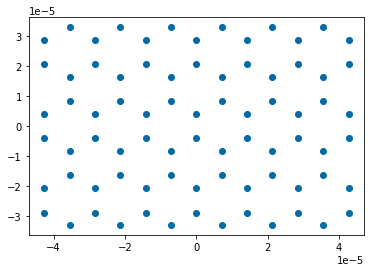

In [6]:
graphene_mol_r_6_6_centered = graphene_mol_r_6_6.get_centered_molecule()
distance_nn = np.sort(graphene_mol_r_6_6_centered.distance_matrix[0])[1]
coords = (graphene_mol_r_6_6_centered.cart_coords/distance_nn)*8.206105170308183e-06
# vview(Molecule([6]*24,coords))

plt.scatter(coords[:,0],coords[:,1])

## Add H

In [5]:
graphene_mol_r_6_6_h = copy.deepcopy(graphene_mol_r_6_6_centered)
right = [32,73,36,76,38,77]
left = [0,39,1,41,4,45]
top = [40,44,50,56,62,68]
bottom = [9,15,21,27,33,37]
for site in right:
    graphene_mol_r_6_6_h.append(1,graphene_mol_r_6_6_centered.cart_coords[site]+[1.3,0.,0.])
for site in left:
    graphene_mol_r_6_6_h.append(1,graphene_mol_r_6_6_centered.cart_coords[site]+[-1.3,0.,0.])
for site in top:
    graphene_mol_r_6_6_h.append(1,graphene_mol_r_6_6_centered.cart_coords[site]+[0.,1.3,0.])
for site in bottom:
    graphene_mol_r_6_6_h.append(1,graphene_mol_r_6_6_centered.cart_coords[site]+[0.,-1.3,0.])

# vview(graphene_mol_r_6_6_h)

## Make periodic

In [44]:
one_side = [77,38,76,36,73,32,40,44,50,56,62,68]
two_side = [0,45,4,41,1,39,    9,15,21,27,33,37]
adj_mat_g_mol_r_6_6 = build_adjacency_matrix_no_pbc(graphene_mol_r_6_6)
adj_mat_g_mol_r_6_6_pbc = build_adjacency_matrix_no_pbc(graphene_mol_r_6_6)
for i,j in zip(one_side,two_side):
    adj_mat_g_mol_r_6_6_pbc[i][j] = 1
    adj_mat_g_mol_r_6_6_pbc[j][i] = 1

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

### The other structures

In [5]:
graphene_mol_large = cut_graphene(graphene,size=7,center=True)
print(graphene_mol_large.num_sites)
vview(graphene_mol_large)

NameError: name 'cut_graphene' is not defined

In [226]:
graphene_mol = cut_graphene(graphene,size=5,center=True)
print(graphene_mol.num_sites)
vview(graphene_mol)

24


In [265]:
graphene_rotated.rotate_sites([0,1],90,[0,0,1])

In [266]:
vview(graphene_rotated)

In [273]:
# graphene_rotated = copy.deepcopy(graphene)
# graphene_rotated.rotate_sites(np.arange(graphene.num_sites),90,[False,False,True])
graphene_mol_r = cut_graphene_rectangle(graphene,15,14,center=True)
print(graphene_mol_r.num_sites)
vview(graphene_mol_r)

84


# <a id='Boltzmann_random'>Boltzmann distribution random</a>

### OB

In [361]:
import numpy as np

T_all = [50,300,900]
T_all = np.linspace(50,200,10)
T_all = [200]
size = 1000
for T in T_all:
    size = size
    binary_vector = []
    QUBO_classical_E = []
    concentration = []

    # Generate binary vectors and compute classical energy
    for conc in np.random.randint(0, 8, size=size):
        concentration.append(conc)
        ones = np.random.choice(72, conc, replace=False)
        x = np.zeros(72, dtype='int')
        x[ones] = 1
        binary_vector.append(x)
        QUBO_classical_E.append(classical_energy(x, Q))

    # Convert lists to numpy arrays
    binary_vector = np.array(binary_vector)
    QUBO_classical_E = np.array(QUBO_classical_E)
    concentration = np.array(concentration)

    av_conc_classical = []
    mu_all = np.linspace(-5.,2,200)
    mu_all = mu_all*Q_gaaln_ml[0][0]
    for mu in mu_all:
        #print(mu)
        for i in range(len(QUBO_classical_E)):
            #print(mu)
            energy_new = QUBO_classical_E + concentration*mu
        Z,pi = get_partition_function(energy_new,[1]*len(QUBO_classical_E),return_pi=True,T=T)
        for nn in np.arange(54):
            index = np.where(concentration == nn)[0]
            ppi = np.sum(pi[index])
#             print(ppi)
            plt.plot(mu,nn/54,'o',alpha=ppi,color='#006BA4',
                    markeredgecolor='none')
#         print((pi))
#         plt.plot(mu_all,av_conc_classical/54,label=T)
        av_conc_classical.append(np.sum(pi*concentration))
    av_conc_classical = np.array(av_conc_classical)
    plt.plot(mu_all,av_conc_classical/54,label=T)
# plt.legend()

ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

# <a id='test_train'>Build the test/train set</a>


## Generate random structures SIC

This saves the graphene_mol_r_6_6_h_test_index.csv file that is not to be overwritten

In [116]:
graphene_mol_r_6_6_h = cry_gui2pmg(Crystal_gui().read_gui('./data/crystal/graphene/spin/graphene_pbe.gui'))
atom_indices = get_all_configurations_pmg_mol(graphene_mol_r_6_6_h)

binary_an = []

for n,i in enumerate(np.arange(1,11,1)):
    
    active_sites = np.where(np.array(graphene_mol_r_6_6_h.atomic_numbers)==6)[0]
    N_atoms = i
    structures_random = generate_random_structures_mol(graphene_mol_r_6_6_h,atom_indices=atom_indices,N_atoms=N_atoms,
                                         new_species=7,N_config=700,DFT_config=25,return_multiplicity=False,
                                                      active_sites=active_sites)
    #vview(structures_random[0])
    num_structures = len(structures_random)
    
    for structure in structures_random:
        binary_an_tmp = np.zeros(len(active_sites),dtype='int')
        binary_an_tmp[np.where(np.array(structure.atomic_numbers) == 7)[0]] = 1
        binary_an.append(binary_an_tmp)

binary_an = np.array(binary_an)

# np.savetxt('data/crystal/graphene/spin/graphene_mol_r_6_6_h_index_test.csv',binary_an,delimiter=',',fmt='%d')


## OPT GEOM

- read binary composition file (+ output name)
- read coordinates
- read atomic species
- generate new atomic species
- generate mol format
- run DFT geometry optimisation
- save data to file

# <a id='crystal'>CRYSTAL</a>

In [64]:
with open('data/crystal/graphene/spin/graphene_pbe.d12') as file:
    input_template = file.readlines()

In [65]:
input_template

['Molecule 24C H12\n',
 'EXTERNAL\n',
 'ATOMSUBS\n',
 'OPTGEOM\n',
 'ONELOG\n',
 'MAXCYCLE\n',
 '500\n',
 'TOLDEE\n',
 '5\n',
 'END\n',
 'END\n',
 '6 8\n',
 '0 0 6 2.0 1.0\n',
 '  13575.349682      0.00022245814352\n',
 '  2035.2333680      0.00172327382520\n',
 '  463.22562359      0.00892557153140\n',
 '  131.20019598      0.03572798450200\n',
 '  42.853015891      0.11076259931000\n',
 '  15.584185766      0.24295627626000\n',
 '0 0 2 2.0 1.0\n',
 '  6.2067138508      0.41440263448000\n',
 '  2.5764896527      0.23744968655000\n',
 '0 0 1 0.0 1.0\n',
 '  0.4941102000      1.00000000000000\n',
 '0 0 1 0.0 1.0\n',
 '  0.1644071000      1.00000000000000\n',
 '0 2 4 2.0 1.0\n',
 '  34.697232244      0.00533336578050\n',
 '  7.9582622826      0.03586410909200\n',
 '  2.3780826883      0.14215873329000\n',
 '  0.8143320818      0.34270471845000\n',
 '0 2 1 0.0 1.0\n',
 '  0.5662417100      1.00000000000000\n',
 '0 2 1 0.0 1.0\n',
 '  0.1973545000      1.00000000000000\n',
 '0 3 1 0.0 1.0\

In [118]:
#TRAIN
with open('data/crystal/graphene/spin/graphene_pbe.d12') as file:
    input_template_save = file.readlines()
N_indices = np.genfromtxt('data/crystal/graphene/spin/graphene_mol_r_6_6_h_index_train.csv',delimiter=',')
N_indices = N_indices.astype('int')

for i,N_index in enumerate(N_indices):
#     input_template = copy.deepcopy(input_template_save)
#     print(i,np.where(N_index==1)[0]+1)
    N_cry_position = np.where(N_index==1)[0]+1
#     if i == 0:
    input_template = copy.deepcopy(input_template_save)
    input_template.insert(3,f'{len(N_cry_position)}\n')
    for j,N in enumerate(N_cry_position):
#         print(N_cry_position)
#         input_template = copy.deepcopy(input_template_save)
        
        input_template.insert(4+j,f'{N} 7\n')
#         print(f'{N} 7')
    with open(f'data/crystal/graphene/spin/graphene_mol_r_6_6_h_{i}.d12','w') as file:
        file.writelines(input_template)
    sh.copy('./data/crystal/graphene/spin/graphene_pbe.gui',f'./data/crystal/graphene/spin/graphene_mol_r_6_6_h_{i}.gui')
    print(f'/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_{i} &')
    if (i+1)%50 == 0:
        print('wait')

/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_0 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_1 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_2 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_3 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_4 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_5 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_6 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_7 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_8 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_9 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_10 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_11 &
/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_12 &
/work/e05/e05/bcamino/

In [119]:
#TEST
with open('data/crystal/graphene/spin/graphene_pbe.d12') as file:
    input_template_save = file.readlines()
N_indices = np.genfromtxt('data/crystal/graphene/spin/graphene_mol_r_6_6_h_index_train.csv',delimiter=',')
N_indices = N_indices.astype('int')

for i,N_index in enumerate(N_indices):
#     input_template = copy.deepcopy(input_template_save)
#     print(i,np.where(N_index==1)[0]+1)
    N_cry_position = np.where(N_index==1)[0]+1
#     if i == 0:
    input_template = copy.deepcopy(input_template_save)
    input_template.insert(3,f'{len(N_cry_position)}\n')
    for j,N in enumerate(N_cry_position):
#         print(N_cry_position)
#         input_template = copy.deepcopy(input_template_save)
        
        input_template.insert(4+j,f'{N} 7\n')
#         print(f'{N} 7')
    with open(f'data/crystal/graphene/spin/test_set/graphene_mol_r_6_6_h_{i}.d12','w') as file:
        file.writelines(input_template)
    sh.copy('./data/crystal/graphene/spin/graphene_pbe.gui',f'./data/crystal/graphene/spin/test_set/graphene_mol_r_6_6_h_{i}.gui')
#     print(f'/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_{i} &')
#     if (i+1)%50 == 0:
#         print('wait')

In [103]:
51%50

1

# <a id='pyscf'>PySCF</a>

#### Run pySCF locally

In [387]:
import json
from pyscf import gto, dft
from pyscf.geomopt.geometric_solver import optimize
from pymatgen.core.structure import Molecule

def get_opt_geom(binary_an,file_name = 'Test'):
    
    binary_an = np.array(binary_an)
    
    coords = [[-7.33822558, 5.04275976, 0.],
     [-7.36522779, 0.69113897, 0.],
     [-6.17364189, 2.88941346, 0.],
     [-4.91009039, 5.01961697, 0.],
     [-7.35805126, -3.64263535, 0.],
     [-6.17347496, -1.43178513, 0.],
     [-4.94006858, 0.7166888, 0.],
     [-3.69484499, 2.86031161, 0.],
     [-2.45722371, 5.00571499, 0.],
     [-6.13851529, -5.72724589, 0.],
     [-4.92821411, -3.58007057, 0.],
     [-3.69816891, -1.42557093, 0.],
     [-2.47177924, 0.71653958, 0.],
     [-1.23070473, 2.851907, 0.],
     [0., 5.00316853, 0.],
     [-3.67896605, -5.69405235, 0.],
     [-2.46601455, -3.56092261, 0.],
     [-1.23242295, -1.4232072, 0.],
     [0., 0.71580893, 0.],
     [1.23070473, 2.851907, 0.],
     [2.45722371, 5.00571499, 0.],
     [-1.22633444, -5.68507971, 0.],
     [0., -3.55707854, 0.],
     [1.23242295, -1.4232072, 0.],
     [2.47177924, 0.71653958, 0.],
     [3.69484499, 2.86031161, 0.],
     [4.91009039, 5.01961697, 0.],
     [1.22633444, -5.68507971, 0.],
     [2.46601455, -3.56092261, 0.],
     [3.69816891, -1.42557093, 0.],
     [4.94006858, 0.7166888, 0.],
     [6.17364189, 2.88941346, 0.],
     [7.33822558, 5.04275976, 0.],
     [3.67896605, -5.69405235, 0.],
     [4.92821411, -3.58007057, 0.],
     [6.17347496, -1.43178513, 0.],
     [7.36522779, 0.69113897, 0.],
     [6.13851529, -5.72724589, 0.],
     [7.35805126, -3.64263535, 0.],
     [-7.35805126, 3.64263535, 0.],
     [-6.13851529, 5.72724589, 0.],
     [-7.36522779, -0.69113897, 0.],
     [-6.17347496, 1.43178513, 0.],
     [-4.92821411, 3.58007057, 0.],
     [-3.67896605, 5.69405235, 0.],
     [-7.33822558, -5.04275976, 0.],
     [-6.17364189, -2.88941346, 0.],
     [-4.94006858, -0.7166888, 0.],
     [-3.69816891, 1.42557093, 0.],
     [-2.46601455, 3.56092261, 0.],
     [-1.22633444, 5.68507971, 0.],
     [-4.91009039, -5.01961697, 0.],
     [-3.69484499, -2.86031161, 0.],
     [-2.47177924, -0.71653958, 0.],
     [-1.23242295, 1.4232072, 0.],
     [0., 3.55707854, 0.],
     [1.22633444, 5.68507971, 0.],
     [-2.45722371, -5.00571499, 0.],
     [-1.23070473, -2.851907, 0.],
     [0., -0.71580893, 0.],
     [1.23242295, 1.4232072, 0.],
     [2.46601455, 3.56092261, 0.],
     [3.67896605, 5.69405235, 0.],
     [0., -5.00316853, 0.],
     [1.23070473, -2.851907, 0.],
     [2.47177924, -0.71653958, 0.],
     [3.69816891, 1.42557093, 0.],
     [4.92821411, 3.58007057, 0.],
     [6.13851529, 5.72724589, 0.],
     [2.45722371, -5.00571499, 0.],
     [3.69484499, -2.86031161, 0.],
     [4.94006858, -0.7166888, 0.],
     [6.17347496, 1.43178513, 0.],
     [7.35805126, 3.64263535, 0.],
     [4.91009039, -5.01961697, 0.],
     [6.17364189, -2.88941346, 0.],
     [7.36522779, -0.69113897, 0.],
     [7.33822558, -5.04275976, 0.],
     [8.28218407, 5.59142473, 0.],
     [8.32574063, 3.14110602, 0.],
     [8.32671501, 1.20466149, 0.],
     [8.32671501, -1.20466149, 0.],
     [8.32574063, -3.14110602, 0.],
     [8.28218407, -5.59142473, 0.],
     [-8.28218407, 5.59142473, 0.],
     [-8.32574063, 3.14110602, 0.],
     [-8.32671501, 1.20466149, 0.],
     [-8.32671501, -1.20466149, 0.],
     [-8.32574063, -3.14110602, 0.],
     [-8.28218407, -5.59142473, 0.],
     [-6.1166254, 6.81942666, 0.],
     [-3.67275689, 6.78743124, 0.],
     [-1.22557981, 6.77840775, 0.],
     [1.22557981, 6.77840775, 0.],
     [3.67275689, 6.78743124, 0.],
     [6.1166254, 6.81942666, 0.],
     [-6.1166254, -6.81942666, 0.],
     [-3.67275689, -6.78743124, 0.],
     [-1.22557981, -6.77840775, 0.],
     [1.22557981, -6.77840775, 0.],
     [3.67275689, -6.78743124, 0.],
     [6.1166254, -6.81942666, 0.]]

    species = ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 
               'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 
               'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 
               'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 
               'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 
               'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 
               'C', 'C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 
               'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 
               'H', 'H', 'H', 'H', 'H', 'H']
    
    N_index = np.where(binary_an == 1)[0]
    N_N = len(N_index)
    for index in N_index:
        species[index] = 'N'
    
    # Remove for production
#     coords = [[0.000000, 0.000000, 0.000000], [0.000000, -0.757000, 0.587000], [0.000000, 0.757000, 0.587000]]
#     species = ["O", "H", "H"]

    # Convert to PySCF molecule format
    mol = gto.Mole()
    mol.atom = [[str(species[i]), coord] for i, coord in enumerate(coords)]
    mol.basis = 'ccpvtz'
    mol.spin = N_N%2
    mol.build()

    # Perform DFT calculation
    mf = dft.RKS(mol)
    mf.xc = 'pbe0'
    
    mol_eq = optimize(mf,maxsteps=200)
    
    mf_eq = dft.RKS(mol_eq)
    mf_eq.xc = 'pbe0'
    energy = mf_eq.kernel()
    
    
    mf_eq.analyze()
    mo_energies = mf_eq.mo_energy.tolist()
    mulliken_charges = mf_eq.mulliken_pop()[1].tolist()
    dipole_moment = mf_eq.dip_moment().tolist()
    
    # Save results to a JSON file
    results = {
        "energy": energy,
        "MO_energies": mo_energies,
        "Mulliken_charges": mulliken_charges,
        "dipole_moment": dipole_moment
    }
#     print('here:',MO_energy,Mulliken,dipole)
    with open("{}.json".format(file_name), "w") as json_file:
        json.dump(results, json_file, indent=4)
    
    pmg_molecule = Molecule(species, mol_eq.atom_coords())
    
    XYZ(pmg_molecule).write_file('{}.xyz'.format(file_name))
    
    
#     with open('energy.txt','w') as f:
#         f.write(str(energy))

get_opt_geom([1,1])

geometric-optimize called with the following command line:
/Users/brunocamino/miniconda3/envs/qc/lib/python3.9/site-packages/ipykernel_launcher.py -f /Users/brunocamino/Library/Jupyter/runtime/kernel-50b31f76-e825-48bb-955d-e087737143dc.json

                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%

<class 'geometric.internal.RotationC'> : 1
> ===== Optimization Info: ====
> Job type: Energy minimization
> Maximum number of optimization cycles: 300
> Initial / maximum trust radius (Angstrom): 0.100 / 0.300
> Convergence Criteria:
> Will converge when all 5 criteria are reached:
>  |Delta-E| < 1.00e-06
>  RMS-Grad  < 3.00e-04
>  Max-Grad  < 4.50e-04
>  RMS-Disp  < 1.20e-03
>  Max-Disp  < 1.80e-03
> === End Optimization Info ===



Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -7.338226   5.042760   0.000000    0.000000  0.000000  0.000000
   N  -7.365228   0.691139   0.000000    0.000000  0.000000  0.000000
   C  -6.173642   2.889413   0.000000    0.000000  0.000000  0.000000
   C  -4.910090   5.019617   0.000000    0.000000  0.000000  0.000000
   C  -7.358051  -3.642635   0.000000    0.000000  0.000000  0.000000
   C  -6.173475  -1.431785   0.000000    0.000000  0.000000  0.000000
   C  -4.940069   0.716689   0.000000    0.000000  0.000000  0.000000
   C  -3.694845   2.860312   0.000000    0.000000  0.000000  0.000000
   C  -2.457224   5.005715   0.000000    0.000000  0.000000  0.000000
   C  -6.138515  -5.727246   0.000000    0.000000  0.000000  0.000000
   C  -4.928214  -3.580071   0.000000    0.000000  0.000000  0.000000
   C  -3.698169  -1.425571   0.000000    0.000000  0.000000  0.000000
   C  -2.471779   0.716540   0.0

KeyboardInterrupt: 

## Write all pyscf input files

In [400]:
set_types = ['train','test']

for set_type in set_types:
    
    binary_vectors = np.genfromtxt('scripts/graphene_mol_r_6_6_h_{}_index.csv'.format(set_type),delimiter=',',dtype='int')

    with open('scripts/template.py') as f:
        template = f.readlines()

    

    for i,bv in enumerate(binary_vectors):
        
        template[3] = 'log_file = open("graphene_mol_r_6_6_h_{}.out","w")\n'.format(i)
        
        template[15] = 'structure_n = {}\n'.format(i)

        N_index_tmp = ','.join([str(x) for x in np.where(bv == 1)[0]])
        N_index = f"[{N_index_tmp}]"

        template[17] = 'N_index = {}\n'.format(N_index)

        with open('scripts/{}_set/graphene_mol_r_6_6_h_{}.py'.format(set_type,i),'w') as f:
            f.writelines(template)

# <a id='build_qubo'>Build the QUBO model</a>

#### Reference states

In [397]:
coords = [[0.000000, 0.000000, 0.00000], [0.000000, 0.000000, 1.0900]]
species = ["N", "N"]

# Convert to PySCF molecule format
mol = gto.Mole()
mol.atom = [[str(species[i]), coord] for i, coord in enumerate(coords)]
mol.basis = 'ccpvtz'
mol.build()

# Perform DFT calculation
mf = dft.RKS(mol)
mf.xc = 'pbe0'

mol_eq = optimize(mf,maxsteps=200)

mf_eq = dft.RKS(mol_eq)
mf_eq.xc = 'pbe0'
energy = mf_eq.kernel()

geometric-optimize called with the following command line:
/Users/brunocamino/miniconda3/envs/qc/lib/python3.9/site-packages/ipykernel_launcher.py -f /Users/brunocamino/Library/Jupyter/runtime/kernel-50b31f76-e825-48bb-955d-e087737143dc.json

                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   0.000000   0.000000   0.000000    0.000000  0.000000  0.000000
   N   0.000000   0.000000   1.090000    0.000000  0.000000  0.000000
converged SCF energy = -109.441471393966
--------------- RKS_Scanner gradients ---------------
         x                y                z
0 N    -0.0000000000    -0.0000000000     0.0002163674
1 N    -0.0000000000     0.0000000000    -0.0002163674
----------------------------------------------
cycle 1: E = -109.441471394  dE = -109.441  norm(grad) = 0.00030599


Step    0 : Gradient = 2.164e-04/2.164e-04 (rms/max) Energy = -109.4414713940
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 5.00000e-02 5.00000e-02 1.87198e+00



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   0.000000   0.000000  -0.000031    0.000000  0.000000 -0.000031
   N   0.000000  -0.000000   1.090031    0.000000 -0.000000  0.000031
converged SCF energy = -109.441471408202
--------------- RKS_Scanner gradients ---------------
         x                y                z
0 N     0.0000000000     0.0000000000     0.0000273363
1 N    -0.0000000000    -0.0000000000    -0.0000273363
----------------------------------------------
cycle 2: E = -109.441471408  dE = -1.42367e-08  norm(grad) = 3.86594e-05


Step    1 : Displace = 3.058e-05/3.058e-05 (rms/max) Trust = 1.000e-01 (=) Grad = 2.734e-05/2.734e-05 (rms/max) E (change) = -109.4414714082 (-1.424e-08) Quality = 1.139
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 5.00000e-02 5.00000e-02 1.87198e+00
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    Time elapsed since start of run_optimizer: 2.352 seconds


converged SCF energy = -109.441471408202


#### atomic

In [70]:
coords = [[0.000000, 0.000000, 0.00000]]
species = ["N"]

# Convert to PySCF molecule format
mol = gto.Mole()
mol.atom = [[str(species[i]), coord] for i, coord in enumerate(coords)]
mol.basis = 'ccpvtz'
mol.spin = 3
mol.build()

# Perform DFT calculation
mf = dft.RKS(mol)
mf.xc = 'pbe0'
energy = mf.kernel()
print(energy)


converged SCF energy = -54.5402660671149
-54.54026606711491


In [60]:
-1.1684822265085577

-1.1684822265085577

In [36]:
import json
from pyscf import gto, dft
from pyscf.geomopt.geometric_solver import optimize
from pymatgen.core.structure import Molecule

coords = [[0.000000, 0.000000, 0.00000], [0.000000, 0.000000, 0.900]]
species = ["H", "H"]

# Convert to PySCF molecule format
mol = gto.Mole()
mol.atom = [[str(species[i]), coord] for i, coord in enumerate(coords)]
mol.basis = 'ccpvtz'
mol.build()

# Perform DFT calculation
mf = dft.RKS(mol)
mf.xc = 'pbe0'

mol_eq = optimize(mf,maxsteps=200)

mf_eq = dft.RKS(mol_eq)
mf_eq.xc = 'pbe0'
energy = mf_eq.kernel()

geometric-optimize called with the following command line:
/Users/brunocamino/miniconda3/envs/qc/lib/python3.9/site-packages/ipykernel_launcher.py -f /Users/brunocamino/Library/Jupyter/runtime/kernel-507386c8-7301-4350-91a8-a23688374a62.json

                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   H   0.000000   0.000000   0.000000    0.000000  0.000000  0.000000
   H   0.000000   0.000000   0.900000    0.000000  0.000000  0.000000
converged SCF energy = -1.15680395403472
--------------- RKS_Scanner gradients ---------------
         x                y                z
0 H    -0.0000000000    -0.0000000000    -0.0686546577
1 H    -0.0000000000     0.0000000000     0.0686546577
----------------------------------------------
cycle 1: E = -1.15680395403  dE = -1.1568  norm(grad) = 0.0970923


Step    0 : Gradient = 6.865e-02/6.865e-02 (rms/max) Energy = -1.1568039540
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 5.00000e-02 5.00000e-02 1.00000e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   H   0.000000   0.000000   0.100000    0.000000  0.000000  0.100000
   H   0.000000  -0.000000   0.800000    0.000000 -0.000000 -0.100000
converged SCF energy = -1.16697940963536
--------------- RKS_Scanner gradients ---------------
         x                y                z
0 H     0.0000000000    -0.0000000000     0.0368219478
1 H    -0.0000000000     0.0000000000    -0.0368219478
----------------------------------------------
cycle 2: E = -1.16697940964  dE = -0.0101755  norm(grad) = 0.0520741


Step    1 : Displace = 1.000e-01/1.000e-01 (rms/max) Trust = 1.000e-01 (=) Grad = 3.682e-02/3.682e-02 (rms/max) E (change) = -1.1669794096 (-1.018e-02) Quality = 0.541
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 5.00000e-02 5.00000e-02 2.79079e-01



Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   H  -0.000000   0.000000   0.065090   -0.000000 -0.000000 -0.034910
   H   0.000000   0.000000   0.834910    0.000000  0.000000  0.034910
converged SCF energy = -1.16810653621626
--------------- RKS_Scanner gradients ---------------
         x                y                z
0 H     0.0000000000     0.0000000000    -0.0158543986
1 H    -0.0000000000    -0.0000000000     0.0158543986
----------------------------------------------
cycle 3: E = -1.16810653622  dE = -0.00112713  norm(grad) = 0.0224215


Step    2 : Displace = 3.491e-02/3.491e-02 (rms/max) Trust = 1.000e-01 (=) Grad = 1.585e-02/1.585e-02 (rms/max) E (change) = -1.1681065362 (-1.127e-03) Quality = 0.464
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 5.00000e-02 5.00000e-02 3.99242e-01



Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   H  -0.000000   0.000000   0.075597   -0.000000 -0.000000  0.010507
   H   0.000000   0.000000   0.824403    0.000000  0.000000 -0.010507
converged SCF energy = -1.16847448865226
--------------- RKS_Scanner gradients ---------------
         x                y                z
0 H     0.0000000000    -0.0000000000    -0.0023772955
1 H    -0.0000000000     0.0000000000     0.0023772955
----------------------------------------------
cycle 4: E = -1.16847448865  dE = -0.000367952  norm(grad) = 0.003362


Step    3 : Displace = 1.051e-02/1.051e-02 (rms/max) Trust = 1.000e-01 (=) Grad = 2.377e-03/2.377e-03 (rms/max) E (change) = -1.1684744887 (-3.680e-04) Quality = 1.169
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 5.00000e-02 5.00000e-02 3.39377e-01



Geometry optimization cycle 5
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   H  -0.000000   0.000000   0.077450   -0.000000  0.000000  0.001853
   H   0.000000  -0.000000   0.822550    0.000000 -0.000000 -0.001853
converged SCF energy = -1.16848217666621
--------------- RKS_Scanner gradients ---------------
         x                y                z
0 H     0.0000000000    -0.0000000000     0.0001922879
1 H    -0.0000000000     0.0000000000    -0.0001922879
----------------------------------------------
cycle 5: E = -1.16848217667  dE = -7.68801e-06  norm(grad) = 0.000271936


Step    4 : Displace = 1.853e-03/1.853e-03 (rms/max) Trust = 1.414e-01 (+) Grad = 1.923e-04/1.923e-04 (rms/max) E (change) = -1.1684821767 (-7.688e-06) Quality = 0.923
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 5.00000e-02 5.00000e-02 3.66828e-01



Geometry optimization cycle 6
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   H  -0.000000   0.000000   0.077312   -0.000000  0.000000 -0.000139
   H   0.000000  -0.000000   0.822688    0.000000 -0.000000  0.000139
converged SCF energy = -1.16848222650226
--------------- RKS_Scanner gradients ---------------
         x                y                z
0 H     0.0000000000    -0.0000000000    -0.0000015978
1 H    -0.0000000000     0.0000000000     0.0000015978
----------------------------------------------
cycle 6: E = -1.1684822265  dE = -4.98361e-08  norm(grad) = 2.25967e-06


Step    5 : Displace = 1.387e-04/1.387e-04 (rms/max) Trust = 2.000e-01 (+) Grad = 1.598e-06/1.598e-06 (rms/max) E (change) = -1.1684822265 (-4.984e-08) Quality = 0.989
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 5.00000e-02 5.00000e-02 3.66828e-01
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    Time elapsed since start of run_optimizer: 2.010 seconds


converged SCF energy = -1.16848222650856


#### atomic

In [71]:
coords = [[0.000000, 0.000000, 0.00000]]
species = ["H"]

# Convert to PySCF molecule format
mol = gto.Mole()
mol.atom = [[str(species[i]), coord] for i, coord in enumerate(coords)]
mol.basis = 'ccpvtz'
mol.spin = 1
mol.build()

# Perform DFT calculation
mf = dft.RKS(mol)
mf.xc = 'pbe0'
energy = mf.kernel()
print(energy)


converged SCF energy = -0.501038466184473
-0.5010384661844731


#### atomic

In [69]:
coords = [[0.000000, 0.000000, 0.00000]]
species = ["C"]

# Convert to PySCF molecule format
mol = gto.Mole()
mol.atom = [[str(species[i]), coord] for i, coord in enumerate(coords)]
mol.basis = 'ccpvtz'
mol.spin = 0
mol.build()

# Perform DFT calculation
mf = dft.RKS(mol)
mf.xc = 'pbe0'
energy = mf.kernel()
print(energy)


converged SCF energy = -37.7317096520226
-37.731709652022595


### periodic graphene

In [ ]:
import numpy as np
from pyscf.pbc import gto, scf




# Define the graphene lattice
# Graphene has a hexagonal lattice with two atoms per unit cell
a = 2.46  # Angstrom, lattice constant for graphene
c = 10.0  # Angstrom, large enough to isolate graphene layer
lattice_vectors = np.array([
    [a, 0.0, 0.0],
    [a/2, a*np.sqrt(3)/2, 0.0],
    [0.0, 0.0, c]
])

# Define the atomic positions in the unit cell
# Two carbon atoms at (0, 0, 0) and (a/2, a*sqrt(3)/6, 0)
atom_positions = '''
C 0.000 0.000 0.000
C 1.230 0.710 0.000
'''

# Set up the unit cell
cell = gto.Cell()
cell.atom = atom_positions
cell.a = lattice_vectors
cell.basis = 'sto-3g'
cell.unit = 'B'  # Angstrom
cell.build()

# Perform SCF calculation with periodic boundary conditions
mf = scf.KRHF(cell, kpts=cell.make_kpts([1, 1, 1]))  # 4x4x1 k-points
mf.kernel()





In [408]:
#SAVE
import numpy as np
from pyscf.pbc import gto, scf

index = 0
while index < 200:
    index += 1
    energy_all = [0.]
    a_all = [2.46]

    # Define the graphene lattice
    # Graphene has a hexagonal lattice with two atoms per unit cell
    a = 2.46  # Angstrom, lattice constant for graphene
    c = 10.0  # Angstrom, large enough to isolate graphene layer
    lattice_vectors = np.array([
        [a, 0.0, 0.0],
        [a/2, a*np.sqrt(3)/2, 0.0],
        [0.0, 0.0, c]
    ])

    # Define the atomic positions in the unit cell
    # Two carbon atoms at (0, 0, 0) and (a/2, a*sqrt(3)/6, 0)
    atom_positions = '''
    C 0.000 0.000 0.000
    C 1.230 0.710 0.000
    '''

    # Set up the unit cell
    cell = gto.Cell()
    cell.atom = atom_positions
    cell.a = lattice_vectors
    cell.basis = 'sto-3g'
    cell.unit = 'B'  # Angstrom
    cell.build()

    # Perform SCF calculation with periodic boundary conditions
    mf = scf.KRHF(cell, kpts=cell.make_kpts([1, 1, 1]))  # 4x4x1 k-points
    mf.kernel()



    # Print the total energy
    print(f'Total energy: {mf.e_tot} Ha')

    energy_all.append(e_tot)
    if energy_all[-1] - energy_all[-2] > 0.0001: #energy_all is more negative
        a = a_all[-1] + a_all[-1]*0.1
        print('1st',energy_all,a)
    elif energy_all[-1] - energy_all[-2] < 0.0001: #energy_all is less negative
        a = np.average([a_all[-1],a_all[-2]]) + np.average([a_all[-1],a_all[-2]])*0.1
        print('1st',energy_all,a)
    else:
        print(f'Converged: {mf.e_tot} Ha')
        print(f'Final a: {a} Ha')
        break


KeyboardInterrupt: 

In [ ]:
#TEST N2
import numpy as np
from pyscf.pbc import gto, scf

index = 0
while index < 200:
    index += 1
    energy_all = [0.]
    a_all = [2.46]

    # Define the graphene lattice
    # Graphene has a hexagonal lattice with two atoms per unit cell
    a = 10.0  # Angstrom, lattice constant for graphene
    c = 10.0  # Angstrom, large enough to isolate graphene layer
    lattice_vectors = np.array([
        [a, 0.0, 0.0],
        [0, a, 0.0],
        [0.0, 0.0, a]
    ])

    # Define the atomic positions in the unit cell
    # Two carbon atoms at (0, 0, 0) and (a/2, a*sqrt(3)/6, 0)
    atom_positions = '''
    N 0.000 0.000 0.000
    N 0.000 0.000 1.200
    '''

    # Set up the unit cell
    cell = gto.Cell()
    cell.atom = atom_positions
    cell.a = lattice_vectors
    cell.basis = 'sto-3g'
    cell.unit = 'B'  # Angstrom
    cell.build()

    # Perform SCF calculation with periodic boundary conditions
    mf = scf.KRHF(cell, kpts=cell.make_kpts([1, 1, 1]))  # 4x4x1 k-points
    mf.kernel()



    # Print the total energy
    print(f'Total energy: {mf.e_tot} Ha')

    energy_all.append(e_tot)
    if energy_all[-1] - energy_all[-2] > 0.0001: #energy_all is more negative
        a = a_all[-1] + a_all[-1]*0.1
        print('1st',energy_all,a)
    elif energy_all[-1] - energy_all[-2] < 0.0001: #energy_all is less negative
        a = np.average([a_all[-1],a_all[-2]]) + np.average([a_all[-1],a_all[-2]])*0.1
        print('1st',energy_all,a)
    else:
        print(f'Converged: {mf.e_tot} Ha')
        print(f'Final a: {a} Ha')
        break


In [405]:
lattice_vectors

array([[ 2.46      ,  0.        ,  0.        ],
       [ 1.23      ,  2.13042249,  0.        ],
       [ 0.        ,  0.        , 10.        ]])

In [410]:
#TEST N2
import numpy as np
from ase import Atoms
from ase.optimize import BFGS
from ase.constraints import UnitCellFilter
from pyscf.pbc import gto, scf
from pyscf.pbc.tools import pyscf_ase

# Define the graphene lattice
a = 10  # Lattice constant for graphene
c = 10.0  # Large enough to isolate graphene layer

# Initial atomic positions for graphene
positions = [
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 1.2]
]

# Define the graphene structure using ASE
graphene = Atoms('N2', positions=positions, cell=[a, a, a], pbc=True)

# Convert ASE atoms object to PySCF Cell object
cell = pyscf_ase.ase_atoms_to_pyscf(graphene)

# Set the basis set and other parameters
cell.basis = 'sto-3g'
cell.build()

# Perform an initial SCF calculation
mf = scf.KRHF(cell, kpts=cell.make_kpts([4, 4, 1]))  # 4x4x1 k-points
mf.kernel()

# Set up the ASE calculator using PySCF
calc = pyscf_ase.PySCFCalculator(cell, mf)

# Attach the calculator to the ASE atoms object
graphene.set_calculator(calc)

# Use ASE's UnitCellFilter to optimize both atomic positions and cell parameters
ucf = UnitCellFilter(graphene)

# Perform the optimization using the BFGS algorithm
optimizer = BFGS(ucf)
optimizer.run(fmax=0.01)  # fmax is the maximum force criterion for convergence

# Print the optimized cell parameters and atomic positions
print("Optimized lattice vectors:")
print(graphene.get_cell())

print("Optimized atomic positions:")
print(graphene.get_positions())


AttributeError: 'list' object has no attribute 'basis'

In [7]:
#SAVE
import numpy as np
from ase import Atoms
from ase.optimize import BFGS
from ase.constraints import UnitCellFilter
from pyscf.pbc import gto, scf
from pyscf.pbc.tools import pyscf_ase

# Define the graphene lattice
a = 2.46  # Lattice constant for graphene
c = 10.0  # Large enough to isolate graphene layer

# Initial atomic positions for graphene
positions = [
    [0.0, 0.0, 0.0],
    [a / 2, a * np.sqrt(3) / 6, 0.0]
]

# Define the graphene structure using ASE
graphene = Atoms('C2', positions=positions, cell=[a, a * np.sqrt(3), c], pbc=True)

# Convert ASE atoms object to PySCF Cell object
cell = pyscf_ase.ase_atoms_to_pyscf(graphene)

# Set the basis set and other parameters
cell.basis = 'sto-3g'
cell.build()

# Perform an initial SCF calculation
mf = scf.KRHF(cell, kpts=cell.make_kpts([4, 4, 1]))  # 4x4x1 k-points
mf.kernel()

# Set up the ASE calculator using PySCF
calc = pyscf_ase.PySCFCalculator(cell, mf)

# Attach the calculator to the ASE atoms object
graphene.set_calculator(calc)

# Use ASE's UnitCellFilter to optimize both atomic positions and cell parameters
ucf = UnitCellFilter(graphene)

# Perform the optimization using the BFGS algorithm
optimizer = BFGS(ucf)
optimizer.run(fmax=0.01)  # fmax is the maximum force criterion for convergence

# Print the optimized cell parameters and atomic positions
print("Optimized lattice vectors:")
print(graphene.get_cell())

print("Optimized atomic positions:")
print(graphene.get_positions())


Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 1078, in _pydevd_bundle.pydevd_cython.PyDBFrame.trace_dispatch
  File "_pydevd_bundle/pydevd_cython.pyx", line 297, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "/Users/brunocamino/miniconda3/envs/qc/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 1976, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "/Users/brunocamino/miniconda3/envs/qc/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2011, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt


KeyboardInterrupt: 

# Read the pyscf energies


In [8]:
import json
with open('data/pyscf/graphene_mol_r_6_6_h.json') as filej:
    data = json.load(filej)
    E_graphene_mol_r_6_6_h = data['energy']
E_graphene_mol_r_6_6_h

-2984.656562450151

In [75]:
E_graphene_mol_r_6_6_h-24*E_H-78*E_C

-29.55828640396112

### Reference states

In [42]:
E_N2 = -109.441471408202 # From above
E_N = E_N2/2

E_H2 = -1.16848222650856 # From above
E_H= E_H2/2

E_C = (E_graphene_mol_r_6_6_h-E_H2*12)/78

### Atomic

In [9]:
E_N = -54.54026606711491

E_H = -0.5010384661844731

E_C = -37.731709652022595

E_0 = E_graphene_mol_r_6_6_h-24*E_H-78*E_C

## test and train are inverted

In [10]:
import os, json

from pymatgen.io.xyz import XYZ

N_atom = 7

N_sites = graphene_mol_r_6_6.num_sites

train_folder = 'data/pyscf/test_set/'
structures_train = []
energies_train = []
N_N_all_train = []


for root, dirs, files in os.walk(train_folder):
    for file in files:
        if file.endswith('.xyz'):
            structure_tmp = Molecule.from_file(train_folder+file)
            N_N = np.sum(np.array(structure_tmp.atomic_numbers)==7)
            N_N_all_train.append(N_N)
            structures_train.append(structure_tmp)
            with open(train_folder+file[:-3]+'json', 'r') as filej:
                data = json.load(filej)
                energy_tmp = (data['energy'] - (E_H*24 + E_N*N_N + E_C*(78-N_N)) - E_0) / 78
#                 print(N_N,energy_tmp)
                energies_train.append(energy_tmp)

test_folder = 'data/pyscf/train_set/'
structures_test = []
energies_test = []
N_N_all_test = []

for root, dirs, files in os.walk(test_folder):
    for file in files:
        if file.endswith('.xyz'):
            structure_tmp = Molecule.from_file(test_folder+file)
            N_N = np.sum(np.array(structure_tmp.atomic_numbers)==7)
            N_N_all_test.append(N_N)
            structures_test.append(structure_tmp)
            with open(test_folder+file[:-3]+'json', 'r') as filej:
                data = json.load(filej)
                energy_tmp = (data['energy'] - (E_H*24 + E_N*N_N + E_C*(78-N_N)) - E_0) / 78
#                 print(N_N,energy_tmp)
                energies_test.append(energy_tmp)



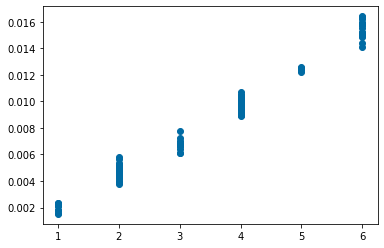

In [89]:
plt.plot(N_N_all_test,energies_test,'o')

In [21]:
from functions_final import *
structure = graphene_mol_r_6_6_centered
N_atom = 7

atom_indices_graphene_mol_r_6_6_centered = get_all_configurations_pmg_mol(structure)
# atom_indices_gaaln = np.genfromtxt('./data/crystal/GaAlN/atom_indices_gaaln',delimiter=',',dtype='int')
num_sites = 78

X_train, y_train = build_test_train_set(structures_train,energies_train,atom_indices_graphene_mol_r_6_6_centered,N_atom)

X_test, y_test = build_test_train_set(structures_test,energies_test,atom_indices_graphene_mol_r_6_6_centered,N_atom)

Q_graphene_ml = build_ml_qubo(structure,X_train,y_train,max_neigh=1)

y_pred = get_qubo_energies(Q_graphene_ml,X_test)
test_qubo_energies(y_pred,y_test)

R2:  0.9992246148430166


72835268390.99112

In [44]:
for struct in structures_train:
    a = np.where(np.array(struct.atomic_numbers)==7)[0]
    print(len(np.where(a==18)[0])>0 * len(np.where(a==59)[0])>0)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [55]:
vview(cry_gui2pmg(Crystal_gui().read_gui('data/crystal/graphene/spin/graphene_pbe_1N.gui')))

In [47]:
Q_graphene_ml[25,66]

0.000585213194606904

In [61]:
import time
random_Q = np.random.rand(700, 700)
random_x = np.random.rand(700)
t = time.time()
np.matmul(random_x,random_Q)
print(((time.time()-t)*100000)/60)

17.65330632527669


In [32]:
for i,j in zip(y_test,y_pred):
    print(i,j,i-j)

0.002365500903171125 0.002827817394974902 -0.0004623164918037769
0.002365500903171125 0.00282817371054514 -0.0004626728073740148
0.002365500903171125 0.0028281252152472435 -0.00046262431207611844
0.002365500903171125 0.002827709881232709 -0.00046220897806158396
0.0043855309696505754 0.0050369396989231145 -0.0006514087292725391
0.0043855309696505754 0.005036945836266786 -0.0006514148666162105
0.0043855309696505754 0.005037650855183514 -0.0006521198855329383
0.0043855309696505754 0.005037842905108258 -0.0006523119354576827
0.014409802519658581 0.014767553226443218 -0.00035775070678463645
0.014409802519658581 0.014767104184231728 -0.00035730166457314735
0.014409802519658581 0.014767704142300862 -0.0003579016226422805
0.014409802519658581 0.01476722161557217 -0.000357419095913589
0.01517191131385213 0.015726006940130013 -0.000554095626277883
0.01517191131385213 0.01572566216020086 -0.0005537508463487311
0.01517191131385213 0.015726234570227142 -0.0005543232563750122
0.01517191131385213 0.0

In [34]:
np.unique(np.round(Q_graphene_ml,4))

array([-3.59525285e+09, -1.01144580e+03,  0.00000000e+00,  2.00000000e-04,
        3.00000000e-04,  4.00000000e-04,  5.00000000e-04,  6.00000000e-04,
        7.00000000e-04,  8.00000000e-04,  2.10000000e-03,  2.20000000e-03,
        2.30000000e-03,  2.50000000e-03,  2.60000000e-03,  2.70000000e-03,
        2.80000000e-03,  2.90000000e-03,  2.62353442e+06])

In [37]:
np.where(np.abs(Q_graphene_ml) > 0.1)

(array([12, 18, 24]), array([53, 59, 65]))

In [38]:
vview(graphene_mol_r_6_6_centered)

In [48]:
Q_gaaln_graphene.diagonal()

array([0.00251502, 0.00241521, 0.00270428, 0.0026134 , 0.00222383,
       0.00269279, 0.00273262, 0.00284368, 0.00260198, 0.00217713,
       0.00254977, 0.00268624, 0.00274337, 0.00282232, 0.00261951,
       0.00196714, 0.00256145, 0.00274573, 0.00256731, 0.00282169,
       0.00260167, 0.00200689, 0.00257728, 0.00274479, 0.00274292,
       0.00284262, 0.00261309, 0.00200692, 0.00256202, 0.00268508,
       0.00273355, 0.00270461, 0.0025149 , 0.00196701, 0.00254992,
       0.00269232, 0.00241699, 0.00217767, 0.00222375, 0.00222368,
       0.00217728, 0.00241638, 0.00269214, 0.00255019, 0.00196649,
       0.00251502, 0.00270448, 0.00273368, 0.00268594, 0.00256228,
       0.00200682, 0.00261307, 0.00284342, 0.00274436, 0.00274572,
       0.00257797, 0.0020065 , 0.002602  , 0.00282255, 0.0025665 ,
       0.00274556, 0.00256208, 0.00196721, 0.0026194 , 0.00282157,
       0.00274282, 0.00268541, 0.00254906, 0.00217703, 0.00260132,
       0.00284303, 0.00273298, 0.00269257, 0.00222489, 0.00261

## Re-symmetrise

#### Min distance

In [ ]:
coords

[[-5.19615242e+00  3.50000000e+00  0.00000000e+00]
 [-5.19615242e+00  5.00000000e-01  0.00000000e+00]
 [-4.33012702e+00  2.00000000e+00  0.00000000e+00]
 [-3.46410162e+00  3.50000000e+00  0.00000000e+00]
 [-5.19615242e+00 -2.50000000e+00  0.00000000e+00]
 [-4.33012702e+00 -1.00000000e+00  0.00000000e+00]
 [-3.46410162e+00  5.00000000e-01  0.00000000e+00]
 [-2.59807621e+00  2.00000000e+00  0.00000000e+00]
 [-1.73205081e+00  3.50000000e+00  0.00000000e+00]
 [-4.33012702e+00 -4.00000000e+00  0.00000000e+00]
 [-3.46410162e+00 -2.50000000e+00  0.00000000e+00]
 [-2.59807621e+00 -1.00000000e+00  0.00000000e+00]
 [-1.73205081e+00  5.00000000e-01  0.00000000e+00]
 [-8.66025404e-01  2.00000000e+00  0.00000000e+00]
 [ 4.36377424e-15  3.50000000e+00  0.00000000e+00]
 [-2.59807621e+00 -4.00000000e+00  0.00000000e+00]
 [-1.73205081e+00 -2.50000000e+00  0.00000000e+00]
 [-8.66025404e-01 -1.00000000e+00  0.00000000e+00]
 [ 4.36377424e-15  5.00000000e-01  0.00000000e+00]
 [ 8.66025404e-01  2.00000000e+

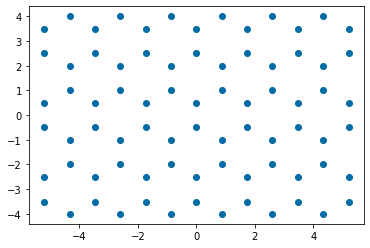

In [24]:
graphene_mol_r_6_6_centered = graphene_mol_r_6_6.get_centered_molecule()
distance_nn = np.sort(graphene_mol_r_6_6_centered.distance_matrix[0])[1]
coords = (graphene_mol_r_6_6_centered.cart_coords/distance_nn)#*2e-06
# vview(Molecule([6]*24,coords))
print(coords)
plt.scatter(coords[:,0],coords[:,1])

In [293]:
C6 = 5.42e-24
eV_to_rad_s = 1.5193e+15
coulomb_interaction = C6/((8e-06)**6)
coulomb_interaction*(1/eV_to_rad_s)

1.360867450779142e-08

In [294]:
125000000.0*(1/eV_to_rad_s)

8.227473178437438e-08

In [283]:
coords[45]-coords[77]

array([-8.52803465e-05, -4.06575815e-20,  0.00000000e+00])

In [189]:
graphene_mol_centered = graphene_mol.get_centered_molecule()
distance_nn = np.sort(graphene_mol_centered.distance_matrix[0])[1]
coords = graphene_mol_centered.cart_coords/distance_nn
vview(Molecule([6]*24,coords))

In [190]:
vview(graphene_mol_centered)

In this QUBO model, I need to account for the fact R will have effect on the atoms beyond NN.

In [258]:
#ORIGINAL: THIS WORKS, DO NOT MODIFY
def build_ml_h_ryd(structure_pbc,X_train,y_train,max_neigh=1):
    
    C = 5.42e-18#5.42e-24
    Delta_g = 1#-1.25e8
    from pymatgen.core.structure import Molecule
    structure = Molecule(structure_pbc.atomic_numbers,structure_pbc.cart_coords)
    #Filter
    distance_matrix = np.round(structure.distance_matrix,5)
    shells = np.unique(np.round(distance_matrix,5))
    num_sites = structure.num_sites
    distance_matrix_filter = np.zeros((num_sites,num_sites),float)
    
    ryd_param = [1,1,1/27]
    ryd_param = [1,1,1/27,1/343]
    
    for i,s in enumerate(shells[0:max_neigh+1]):
        row_index = np.where(distance_matrix == s)[0]
        col_index = np.where(distance_matrix == s)[1]
        distance_matrix_filter[row_index,col_index] = ryd_param[i]
    distance_matrix_filter = np.triu(distance_matrix_filter,0)

#     print(distance_matrix_filter[0])    
    
    #Build the descriptor

    upper_tri_indices = np.where(distance_matrix_filter != 0.)
    descriptor = []
    descriptor_test = []
    for config in X_train:
        matrix = np.outer(config,config)*distance_matrix_filter #matrix[i][j] == 1 if i and j are ==1
        upper_tri_elements = matrix[upper_tri_indices]
        print(upper_tri_indices)
        descriptor.append(upper_tri_elements)
        print(descriptor)
#         diag = np.sum(matrix.diagonal())
#         diag_all = matrix.diagonal().tolist()
#         all_terms = np.sum(upper_tri_elements)
#         diag_all.append(all_terms-diag)
        
#         descriptor_test.append([diag,all_terms-diag])
        #descriptor_test.append(diag_all)
    #print(descriptor_test)

#     descriptor_all = []
#     for config in all_configurations:
#         matrix = np.outer(config,config)
#         upper_tri_elements = matrix[upper_tri_indices]
#         descriptor_all.append(upper_tri_elements)
#     descriptor  = copy.deepcopy(descriptor_test)
    descriptor = np.array(descriptor)
    
#     from sklearn.linear_model import LinearRegression
    
    
    reg = LinearRegression() #create the object
    reg.fit(descriptor, y_train)
    
    # THEN USE THE VALUES TO POPULATE THE DISTANCE MATRIX USING THE upper_tri_indices
    
#     print(reg.coef_)
#     print('R2: ',reg.score(descriptor, y_train))
    
    
#     ##########QUBO E
#     Q_structure = np.zeros((num_sites,num_sites),float)
#     distance_matrix = build_adjacency_matrix(structure,max_neigh=2)
    
#     #print(Q_structure)
#     nn = np.where(distance_matrix==1)

#     Q_structure[nn] = reg.coef_[1]-(reg.coef_[1]*1/27)
#     #print(reg.coef_[1],Q_structure[nn])
#     nnn = np.where(distance_matrix==2)
#     Q_structure[nnn] = reg.coef_[1]*1/27
#     #print(Q_structure[nnn])
#     # Add the chemical potential (still calling it J1)
#     #J1 += J1*mu
#     np.fill_diagonal(Q_structure,reg.coef_[0])
    
# #     Q = np.zeros((num_sites,num_sites))
# #     Q[upper_tri_indices] = reg.coef_
#     #print(np.unique(Q_structure))
#     return Q_structure
#build_ml_h_ryd(graphene_50,X_train,y_train,max_neigh=2)
X_train = [np.zeros(graphene_mol_r_6_6.num_sites,dtype='int')]
X_train[0][0] = 1
X_train[0][1] = 1
y_train = [0.]
Q = build_ml_h_ryd(graphene_mol_r_6_6,X_train,y_train,max_neigh=1)
np.unique(Q)

(array([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,  4,  4,
        5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  8,  9,
        9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13, 13,
       13, 14, 14, 14, 14, 15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 17, 18,
       18, 18, 18, 19, 19, 19, 19, 20, 20, 20, 20, 21, 21, 21, 22, 22, 22,
       22, 23, 23, 23, 23, 24, 24, 24, 24, 25, 25, 25, 25, 26, 26, 26, 26,
       27, 27, 27, 28, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31,
       31, 31, 32, 32, 32, 33, 33, 33, 34, 34, 34, 34, 35, 35, 35, 35, 36,
       36, 36, 37, 37, 37, 38, 38, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
       48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
       65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]), array([ 0, 39, 40,  1, 41, 42,  2, 39, 42, 43,  3, 40, 43, 44,  4, 45, 46,
        5, 41, 46, 47,  6, 42, 47, 48,  7, 43, 48, 49,  8, 44, 49, 50,  9,
       45, 51, 10, 46, 51, 52, 11, 47,

array([None], dtype=object)

In [244]:
vview(graphene_mol_r_6_6)

In [245]:
np.argsort(graphene_mol_r_6_6.distance_matrix[2])

array([ 2, 43, 39, 42,  3,  7,  0,  6,  1, 40, 48, 44, 49, 47, 41,  8, 12,
        5, 13, 11, 54, 53, 50, 46, 55, 52, 14, 18, 17, 10,  4, 59, 19, 16,
       60, 58, 56, 51, 45, 23,  9, 61, 57, 20, 24, 22, 15, 65, 64, 25, 21,
       66, 63, 62, 29, 28, 67, 30, 26, 27, 70, 71, 69, 31, 72, 68, 34, 35,
       33, 73, 75, 74, 32, 36, 76, 38, 37, 77])

## Use new distances
This works, but needs some tuning for the penalty once I have all the distances

In [295]:
#2
import numpy as np
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

# Example initial coordinates (3 points in 2D space)
initial_coords = initial_coords = graphene_mol_r_6_6_centered.cart_coords[:,0:2]

# Distance constraints: specify distances between some pairs of points
# Here, we want distances between points 0-1 and 1-2 to be as specified
distance_constraints = {
    (0, 39): 2.  # distance between point 0 and 1
    
}

# Compute the original pairwise distances
original_distances = pdist(initial_coords)
original_distance_matrix = squareform(original_distances)

# Function to compute the residual sum of squares of the differences between
# the actual distances and the specified distances, including a penalty for deviations from original distances
def objective_function(coords, initial_coords, distance_constraints):
    coords = coords.reshape(-1, 2)
    residuals = []
    
    # Penalty term for specified distances
    for (i, j), target_distance in distance_constraints.items():
        actual_distance = np.linalg.norm(coords[i] - coords[j])
        residuals.append((actual_distance - target_distance)**2)
    
    # Penalty term for maintaining original distances
    penalty = 0
    num_points = coords.shape[0]
    for i in range(num_points):
        for j in range(i + 1, num_points):
            if (i, j) not in distance_constraints and (j, i) not in distance_constraints:
                original_distance = original_distance_matrix[i, j]
                actual_distance = np.linalg.norm(coords[i] - coords[j])
                penalty += 0.5*(actual_distance - original_distance)**2

    return np.sum(residuals) + penalty

# Flatten initial coordinates for the optimizer
initial_coords_flat = initial_coords.flatten()

# Perform the optimization
result = minimize(objective_function, initial_coords_flat, args=(initial_coords, distance_constraints,), method='L-BFGS-B')

# Reshape the optimized coordinates back to the original shape
optimized_coords = result.x.reshape(-1, 2)

print("Optimized Coordinates:")
print(optimized_coords)


Optimized Coordinates:
[[-7.38039075e+00  5.03551727e+00]
 [-7.40328659e+00  7.12160634e-01]
 [-6.16948219e+00  2.85006792e+00]
 [-4.93617738e+00  4.98576346e+00]
 [-7.40315514e+00 -3.56204968e+00]
 [-6.16931804e+00 -1.42489229e+00]
 [-4.93552766e+00  7.12464333e-01]
 [-3.70199175e+00  2.84944025e+00]
 [-2.46809807e+00  4.98631738e+00]
 [-6.16921140e+00 -5.69913864e+00]
 [-4.93539262e+00 -3.56197770e+00]
 [-3.70160618e+00 -1.42474637e+00]
 [-2.46788506e+00  7.12437116e-01]
 [-1.23414127e+00  2.84943507e+00]
 [-2.42326828e-04  4.98648682e+00]
 [-3.70146827e+00 -5.69906324e+00]
 [-2.46767813e+00 -3.56187754e+00]
 [-1.23391143e+00 -1.42469386e+00]
 [-1.51173172e-04  7.12417989e-01]
 [ 1.23366225e+00  2.84948176e+00]
 [ 2.46754695e+00  4.98656704e+00]
 [-1.23374964e+00 -5.69898244e+00]
 [ 3.22399124e-05 -3.56181458e+00]
 [ 1.23380885e+00 -1.42467220e+00]
 [ 2.46760142e+00  7.12432880e-01]
 [ 3.70143501e+00  2.84952384e+00]
 [ 4.93531263e+00  4.98661301e+00]
 [ 1.23396544e+00 -5.69891819e+0

In [296]:
coord_tmp = graphene_mol_r_6_6_centered.cart_coords
coord_tmp[:,0:2] = optimized_coords
np.sum(np.abs(Molecule([6]*78,coord_tmp).distance_matrix-graphene_mol_r_6_6_centered.distance_matrix))

7.060973390118364

In [297]:
vview(Molecule([6]*78,coord_tmp))

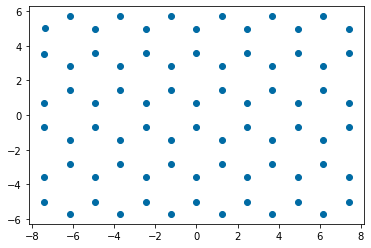

In [290]:
plt.plot(optimized_coords[:,0],optimized_coords[:,1],'o')

# WIP: energy functions

In [529]:
def get_hardware_energy(
    structure,
    binary_vector,
    R,
    detuning = 125000000.0,
    C6 = 5.42e-24
):
    
    eV_to_rad_s = eV_to_rad_s = 1.5193e+15
    distance_matrix = structure.distance_matrix
    
    neighbours_distance = np.sort(distance_matrix[0])[1]
    distance_matrix = (structure.distance_matrix/neighbours_distance)*R
#     print(distance_matrix[0])
    
    binary_matrix = np.outer(binary_vector,binary_vector)
    
    distance_matrix_filter = distance_matrix * binary_matrix 
    distance_matrix_filter = np.triu(distance_matrix_filter,1)
    upper_tri_indices = np.where(distance_matrix_filter != 0.)

    upper_tri_elements = distance_matrix_filter[upper_tri_indices]
    
    E_local = np.sum(binary_vector)*detuning
    E_coulomb = np.sum(C6/upper_tri_elements**6)
#     print((E_coulomb+E_local)*(1/eV_to_rad_s))
    
    return (E_coulomb+E_local)*(1/eV_to_rad_s)

binary_vector = [1]*graphene_mol_r_6_6.num_sites
get_hardware_energy(graphene_mol_r_6_6,binary_vector,R=8.206105170308183e-06,detuning = -125000000.0,C6 = 5.42e-24)
get_hardware_energy(graphene_mol_r_6_6,binary_vector,R=2e-06,detuning = -125000000.0,C6 = 5.42e-24)


0.006357648685575689

In [527]:
k_b

8.617333262e-05

In [57]:
def get_qubo_from_J_structure(structure,
                          J1,
                          J2,
                          J3=0):
    
    Q = np.zeros((structure.num_sites,structure.num_sites))
    np.fill_diagonal(Q,J1)
    
    if J3 != 0:
        adjacency_matrix = build_adjacency_matrix_no_pbc(structure,max_neigh=2)
        nn_index = np.where(adjacency_matrix==1)
        nnn_index = np.where(adjacency_matrix==2)
        Q[nn_index] = J2
        Q[nnn_index] = J3
    else:
        adjacency_matrix = build_adjacency_matrix_no_pbc(structure,max_neigh=1)    
        nn_index = np.where(adjacency_matrix==1)    
        Q[nn_index] = J2
    
    return Q

get_qubo_from_J_structure(graphene_mol_r_6_6, J1=0.080403,J2=0.019894)

array([[0.080403, 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.080403, 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.080403, ..., 0.      , 0.      , 0.      ],
       ...,
       [0.      , 0.      , 0.      , ..., 0.080403, 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.080403, 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.080403]])

In [57]:
def get_qubo_from_J_adj_matrix(adjacency_matrix,
                          J1,
                          J2,
                          J3=0):
    
    Q = np.zeros((structure.num_sites,structure.num_sites))
    np.fill_diagonal(Q,J1)
    
    nn_index = np.where(adjacency_matrix==1)    
    Q[nn_index] = J2
        
    if J3 != 0:
        nnn_index = np.where(adjacency_matrix==2)
        Q[nnn_index] = J3
 
        
    
    return Q

get_qubo_from_J_adj_matrix(adj_mat_g_mol_r_6_6_pbc, J1=0.080403,J2=0.019894)

array([[0.080403, 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.080403, 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.080403, ..., 0.      , 0.      , 0.      ],
       ...,
       [0.      , 0.      , 0.      , ..., 0.080403, 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.080403, 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.080403]])

## Boltzmann distribution

### QUBO

/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_66030/298715917.py:21: RuntimeWarning: overflow encountered in exp
  p_i = multiplicity * np.exp((-energy + (N_N * N_potential)) / (k_b * T))
/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_66030/298715917.py:25: RuntimeWarning: invalid value encountered in divide
  p_i /= pf


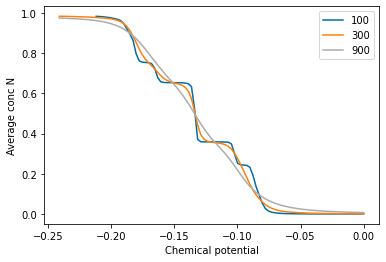

In [54]:
size = 10
binary_vector_all = []
QUBO_classical_E = []
concentration = []

Q = get_qubo_from_J(graphene_mol_r_6_6, J1=0.080403,J2=0.019894)

num_sites = graphene_mol_r_6_6.num_sites
max_conc = graphene_mol_r_6_6.num_sites


# T_all = [50,300,900]
# T_all = np.linspace(50,200,10)
T_all = [100,300,900]
size = 1000
    
    
concentration = np.random.randint(0, max_conc, size=size)
for conc in concentration:
    
    ones = (np.random.choice(num_sites,conc, replace=False))
    x = np.zeros(num_sites,dtype='int')
    x[ones] = 1
    binary_vector_all.append(x)
    QUBO_classical_E.append(classical_energy(x,Q))
    
    # Convert lists to numpy arrays
binary_vector_all = np.array(binary_vector_all)
QUBO_classical_E = np.array(QUBO_classical_E)
concentration = np.array(concentration)

    
mu_all = np.linspace(-3.,0,100)
mu_all = mu_all*Q[0][0]

for T in T_all:
    av_conc_classical = []
    for mu in mu_all:

        #print(mu)
        for i in range(len(QUBO_classical_E)):
            #print(mu)
            energy_new = QUBO_classical_E + concentration*mu
#                 print(energy_new)
        Z,pi = get_partition_function(energy_new,[1]*len(QUBO_classical_E),return_pi=True,T=T)
#             print(pi)
#             for nn in np.arange(num_sites):
#                 index = np.where(concentration == nn)[0]
#                 ppi = np.sum(pi[index])
#     #             print(ppi)
#                 plt.plot(mu,nn/num_sites,'o',alpha=ppi,color='#006BA4',
#                         markeredgecolor='none')
#         print((pi))
#         plt.plot(mu_all,av_conc_classical/54,label=T)
        av_conc_classical.append(np.sum(pi*concentration))
# print(av_conc_classical)
    av_conc_classical = np.array(av_conc_classical)
    plt.plot(mu_all,av_conc_classical/num_sites,label=T)
plt.xlabel('Chemical potential')
plt.ylabel('Average conc N')
plt.legend()

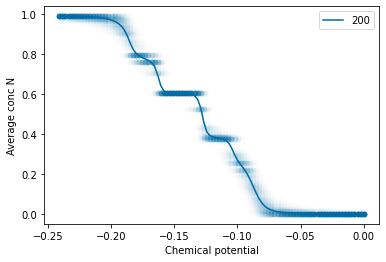

In [466]:
size = 10
binary_vector_all = []
QUBO_classical_E = []
concentration = []

Q = get_qubo_from_J(graphene_mol_r_6_6, J1=0.080403,J2=0.019894)

num_sites = graphene_mol_r_6_6.num_sites
max_conc = graphene_mol_r_6_6.num_sites


# T_all = [50,300,900]
# T_all = np.linspace(50,200,10)
T_all = [200]
size = 10000
    
    
concentration = np.random.randint(0, max_conc, size=size)
for conc in concentration:
    
    ones = (np.random.choice(num_sites,conc, replace=False))
    x = np.zeros(num_sites,dtype='int')
    x[ones] = 1
    binary_vector_all.append(x)
    QUBO_classical_E.append(classical_energy(x,Q))
    
    # Convert lists to numpy arrays
binary_vector_all = np.array(binary_vector_all)
QUBO_classical_E = np.array(QUBO_classical_E)
concentration = np.array(concentration)

    
mu_all = np.linspace(-3.,0,100)
mu_all = mu_all*Q[0][0]

for T in T_all:
    av_conc_classical = []
    for mu in mu_all:

        #print(mu)
        for i in range(len(QUBO_classical_E)):
            #print(mu)
            energy_new = QUBO_classical_E + concentration*mu
#                 print(energy_new)
        Z,pi = get_partition_function(energy_new,[1]*len(QUBO_classical_E),return_pi=True,T=T)

        for nn in np.arange(num_sites):
            index = np.where(concentration == nn)[0]
            ppi = np.sum(pi[index])
#             print(ppi)
            plt.plot(mu,nn/num_sites,'o',alpha=ppi,color='#006BA4',
                    markeredgecolor='none')
        
        av_conc_classical.append(np.sum(pi*concentration))

    av_conc_classical = np.array(av_conc_classical)
    plt.plot(mu_all,av_conc_classical/num_sites,label=T)
plt.xlabel('Chemical potential')
plt.ylabel('Average conc N')
plt.legend()

### Hardware energy

In [478]:
av_conc_classical

array([ 4.,  7., nan, nan, nan, nan, nan, nan, nan, nan])

In [494]:
Z

inf

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


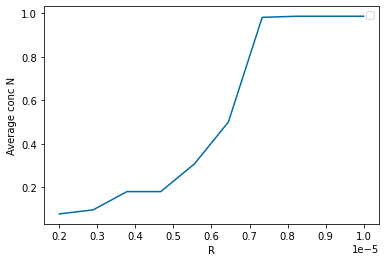

In [582]:
size = 10
binary_vector_all = []
hardware_classical_E = []
concentration = []

Q = get_qubo_from_J(graphene_mol_r_6_6, J1=0.080403,J2=0.019894)

num_sites = graphene_mol_r_6_6.num_sites
max_conc = graphene_mol_r_6_6.num_sites


# T_all = [50,300,900]
# T_all = np.linspace(50,200,10)
T_all = [100,300,900]
size = 1000
    
T=10e-06
T=1e-04
concentration = np.random.randint(0, max_conc, size=size)

for conc in concentration:
    
    ones = (np.random.choice(num_sites,conc, replace=False))
    x = np.zeros(num_sites,dtype='int')
    x[ones] = 1
    binary_vector_all.append(x)

av_conc_classical = []
R_all = np.linspace(2e-06,10e-06,10)
# R_all = [4e-06]
# R_all = np.linspace(2e-06,4e-06,10)
for R in R_all:
    
    hardware_classical_E = []
    for x in binary_vector_all:
        hardware_classical_E.append(get_hardware_energy(graphene_mol_r_6_6,x,
                        R=R,detuning = -125000000.0,C6 = 5.42e-24))
#     plt.plot(R,np.min(hardware_classical_E),'o')
    Z,pi = get_partition_function(hardware_classical_E,[1]*len(hardware_classical_E),return_pi=True,T=T)
#     print(Z)
    av_conc_classical.append(np.sum(pi*concentration))
    
av_conc_classical = np.array(av_conc_classical)
plt.plot(R_all,av_conc_classical/num_sites)
    
    
    # Convert lists to numpy arrays
binary_vector_all = np.array(binary_vector_all)

concentration = np.array(concentration)


#             print(pi)
#             for nn in np.arange(num_sites):
#                 index = np.where(concentration == nn)[0]
#                 ppi = np.sum(pi[index])
#     #             print(ppi)
#                 plt.plot(mu,nn/num_sites,'o',alpha=ppi,color='#006BA4',
#                         markeredgecolor='none')
#         print((pi))
#         plt.plot(mu_all,av_conc_classical/54,label=T)

# print(av_conc_classical)

plt.xlabel('R')
plt.ylabel('Average conc N')
plt.legend()

In [542]:
Z,pi = get_partition_function(hardware_classical_E,[1]*len(hardware_classical_E),return_pi=True,T=T)
Z

1.4067271630785878e+173

In [546]:
get_partition_function(hardware_classical_E,[1]*len(hardware_classical_E),return_pi=True,T=T)

array([   0, 6566, 6567, ..., 1088, 9255, 7900])

In [547]:
binary_vector_all[7900]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [552]:
np.sort(hardware_classical_E)

array([-1.00387858e-06, -9.84138295e-07, -9.54590435e-07, ...,
        9.12728248e-05,  9.12728248e-05,  9.12728248e-05])

In [571]:
np.exp(1e-06/(k_b * 10e-05))

2.4990897554477857e+50

In [557]:
np.exp(-9.12728248e-05  / ((k_b * 1e-05)))

0.0

In [537]:
-hardware_classical_E[0] # / ((k_b * 1e-05))

-7.834210139514653e-05

In [505]:
x = np.zeros(num_sites)
x[0] = 1
hardware_classical_E = [get_hardware_energy(graphene_mol_r_6_6,x,
                        R=R,detuning = -125000000.0,C6 = 5.42e-24)]
get_partition_function(hardware_classical_E,[1]*len(hardware_classical_E),return_pi=True,T=T)

(2.915008631876178e+41, array([1.]))

In [498]:
get_partition_function(hardware_classical_E,[1]*len(hardware_classical_E),return_pi=True,T=T)

/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_71591/298715917.py:21: RuntimeWarning: overflow encountered in exp
  p_i = multiplicity * np.exp((-energy + (N_N * N_potential)) / (k_b * T))
/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_71591/298715917.py:25: RuntimeWarning: invalid value encountered in divide
  p_i /= pf


(inf, array([0., 0., 0., ..., 0., 0., 0.]))

In [417]:
QUBO_classical_E

[1.766385,
 5.8106100000000005,
 4.050013999999999,
 6.610505,
 3.0089099999999998,
 7.850549000000001,
 3.6488259999999992,
 4.530778000000001,
 4.68993,
 1.886576]

In [242]:
def build_ml_h_ryd_v2(structure_ob,X_train,y_train,max_neigh=1):
    
    C = 5.42e-24
    eV_to_rad_s = 1.5193e+15
    Delta_g = 1#-1.25e8
    # Transform the energy from eV to rad/s
    y_train = y_train*eV_to_rad_s
    
    structure = copy.deepcopy(structure_ob)
    #Filter
    distance_matrix = np.round(structure.distance_matrix,5)
    #print(distance_matrix)
    shells = np.unique(np.round(distance_matrix,5))
    num_sites = structure.num_sites
    distance_matrix_filter = np.zeros((num_sites,num_sites),float)
    
    ryd_param = [1,1,1/27]
    ryd_param = [1,1,1/27,1/343]
    
    #ryd_param = [1,C,C/27,C/343]
    #ryd_param = [1,(1/C)**(1/6),(1.73/C)**(1/6),(2/C)**(1/6)]
    
    for i,s in enumerate(shells[0:max_neigh+1]):
        row_index = np.where(distance_matrix == s)[0]
        col_index = np.where(distance_matrix == s)[1]
        distance_matrix_filter[row_index,col_index] = ryd_param[i]
    distance_matrix_filter = np.triu(distance_matrix_filter,0)

#     print(distance_matrix_filter)    
    
    #Build the descriptor

    upper_tri_indices = np.where(distance_matrix_filter != 0.)
    descriptor = []
    descriptor_test = []
    for config in X_train:
        print(config)
        matrix = np.outer(config,config)*distance_matrix_filter #matrix[i][j] == 1 if i and j are ==1
        upper_tri_elements = matrix[upper_tri_indices]
        
#         descriptor.append(upper_tri_elements)
#         diag = np.sum(matrix.diagonal())
#         diag_all = matrix.diagonal().tolist()
#         all_terms = np.sum(upper_tri_elements)
#         diag_all.append(all_terms-diag)
        
        descriptor_all.append(upper_tri_elements)
        
        print(descriptor_all)
        
        #descriptor_test.append(diag_all)
    #print(descriptor_test)

#     descriptor_all = []
#     for config in all_configurations:
#         matrix = np.outer(config,config)
#         upper_tri_elements = matrix[upper_tri_indices]
#         descriptor_all.append(upper_tri_elements)
    descriptor  = copy.deepcopy(descriptor_test)
    descriptor = np.array(descriptor)
#     print(descriptor)
    from sklearn.linear_model import LinearRegression
    
    
    reg = LinearRegression() #create the object
    reg.fit(descriptor, y_train)
    print(reg.coef_)
    print((C/reg.coef_[1])**(1/6))
    print('R2: ',reg.score(descriptor, y_train))
    
    
    ##########QUBO E
    Q_structure = np.zeros((num_sites,num_sites),float)
    distance_matrix = build_adjacency_matrix(structure,max_neigh=max_neigh)
    
    #print(Q_structure)
    nn = np.where(distance_matrix==1)

    Q_structure[nn] = reg.coef_[1]-(reg.coef_[1]*1/27)
    #print(reg.coef_[1],Q_structure[nn])
    nnn = np.where(distance_matrix==2)
    Q_structure[nnn] = reg.coef_[1]*1/27
    #print(Q_structure[nnn])
    # Add the chemical potential (still calling it J1)
    #J1 += J1*mu
    np.fill_diagonal(Q_structure,reg.coef_[0])
    
#     Q = np.zeros((num_sites,num_sites))
#     Q[upper_tri_indices] = reg.coef_
    #print(np.unique(Q_structure))
    return Q_structure
# build_ml_h_ryd(graphene_50,X_train,y_train,max_neigh=2)
Q = build_ml_h_ryd_v2(graphene_mol,X_train=[[1]*24],y_train=0,max_neigh=3)
np.unique(Q)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


NameError: name 'descriptor_all' is not defined

In [181]:
get_final_ryd_Hamiltonian_v2(
    coords[:,0:2], 
    detuning = 125000000.0,
    J1=0.08843826,J2=0.01255761,
    C6 = 5.42e-24
)
#E_ryd

8.206105170308183e-06

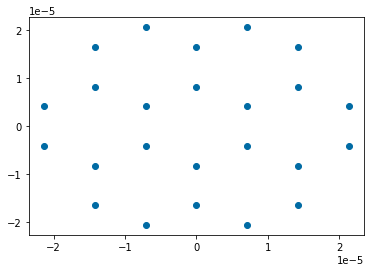

In [183]:
plt.scatter(coords[:,0]*8.206105170308183e-06,coords[:,1]*8.206105170308183e-06)

In [187]:
vview(graphene_mol_large)

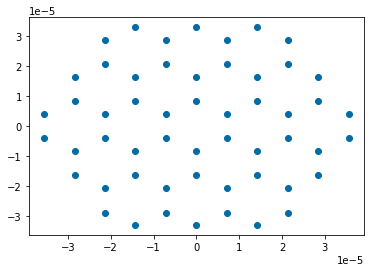

In [186]:
graphene_mol_centered = graphene_mol_large.get_centered_molecule()
distance_nn = np.sort(graphene_mol_centered.distance_matrix[0])[1]
coords = graphene_mol_centered.cart_coords/distance_nn
# vview(Molecule([6]*24,coords))

plt.scatter(coords[:,0]*8.206105170308183e-06,coords[:,1]*8.206105170308183e-06)

In [445]:
# From H_ryd mapping: J1=0.08843826, J2=0.01209251, J3=0.0004651
E_QUBO = QUBO(neighbors, J1=0.08843826, J2=0.01209251, J3=0.0004651)[0]
#E_QUBO-E_ryd

In [461]:
configurations = np.array(list(itertools.product([0, 1], repeat=graphene_scell.num_sites)))
config_unique, E_QUBO_sic, multiplicity = find_sic(configurations,atom_indices,energies=E_QUBO,sort=True)
config_unique, E_ryd_sic,multiplicity = find_sic(configurations,atom_indices,energies=E_ryd,sort=True)
E_QUBO_sic = np.array(E_QUBO_sic)
E_ryd_sic = np.array(E_ryd_sic)

In [462]:
E_QUBO_sic-E_ryd_sic

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.96212656e-04, -3.06582275e-06, -4.65100000e-04, -1.72258025e-05,
        3.33333333e-09, -3.66111079e-05, -1.96212656e-04,  3.33333333e-09,
       -4.65100000e-04,  3.33333333e-09, -4.65100000e-04, -7.32188824e-05,
       -1.72191358e-05, -6.61309323e-04, -4.85391625e-04, -3.96735973e-05,
        9.99999999e-09, -6.78538459e-04, -6.61309323e-04, -6.61309323e-04,
       -5.18936910e-04, -9.30196667e-04,  9.99999999e-09, -9.30196667e-04,
       -2.32820431e-04, -9.30196667e-04, -5.01707775e-04, -5.01707775e-04,
       -1.16393008e-03, -9.84030244e-04, -1.59150599e-03, -5.21996066e-04,
       -5.41381372e-04, -1.02064468e-03, -2.72494028e-04, -1.18024623e-03,
       -9.87099400e-04, -7.62780385e-05, -7.15142900e-04, -1.32261865e-03,
       -1.72091358e-05, -5.38312216e-04, -1.12640266e-03, -1.59150599e-03,
       -6.97913764e-04, -1.16301710e-03, -7.34528205e-04, -1.32261865e-03,
       -1.43190444e-03, -

## <a id='mapping'>Direct mapping (any R)</a>

$$
1 \text{rad s}^{-1} = 6.58\times10^{-16} eV
$$

- build the adjacency matrix
- only think of NN first
- 



Test square

In [628]:
coord = [[0,0,0],[1,0,0],[1,1,0],[0,1,0]]
coord_modified = [[0,0,0],[1,0,0],[0.5,0.5,0],[0,1,0]]
square_test = Molecule([1]*4,coord)
square_test_modified = Molecule([1]*4,coord_modified)

In [629]:
vview(square_test_modified)

In [630]:
square_test_modified.distance_matrix

array([[0.        , 1.        , 0.70710678, 1.        ],
       [1.        , 0.        , 0.70710678, 1.41421356],
       [0.70710678, 0.70710678, 0.        , 0.70710678],
       [1.        , 1.41421356, 0.70710678, 0.        ]])

In [666]:
structure = square_test
am = build_adjacency_matrix_no_pbc(square_test,max_neigh=1)
dm = square_test.distance_matrix
am_modified = copy.deepcopy(am)
am_modified = am_modified.astype('float')
am_modified[0][1] = 0.99
dm_modified = copy.deepcopy(dm)
dm_modified[0][1] = 0.7
# am_modified = copy.deepcopy(square_test_modified.distance_matrix)

In [651]:
am_modified

array([[0.  , 0.99, 0.  , 1.  ],
       [1.  , 0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  , 1.  ],
       [1.  , 0.  , 1.  , 0.  ]])

In [667]:
from scipy.optimize import minimize
from scipy.spatial.distance import squareform, pdist
import numpy as np

def objective_function(coords, new_distances):
    # Reshape the flattened coordinates into the original shape
    coords_2d = coords.reshape(-1, 2)
    
    # Calculate pairwise distances using the current coordinates
    distances = squareform(pdist(coords_2d))
    
    # Calculate the difference between the current and new distances
    diff = distances - new_distances
    
    # Return the sum of squared differences
    return np.sum(diff ** 2)

def find_new_coordinates(initial_coords, new_distances):
    # Flatten the initial coordinates into a 1D array
    initial_coords_flat = initial_coords.flatten()
    
    # Define bounds for optimization (optional)
    bounds = [(-np.inf, np.inf)] * len(initial_coords_flat)
    
    # Minimize the objective function using the initial coordinates as starting point
    result = minimize(objective_function, initial_coords_flat, args=(new_distances,), bounds=bounds)
    
    # Reshape the optimized coordinates back into the original shape
    new_coords = result.x.reshape(-1, 2)
    
    return new_coords

# Example usage
# initial_coords = np.array([[0, 0], [1, 1], [2, 2]])  # Example initial coordinates
# new_distances = np.array([[0, 1.5, 2.5], [1.5, 0, 2], [2.5, 2, 0]])  # Example new distance matrix
initial_coords = square_test.cart_coords[:,0:2]  # Example initial coordinates
new_distances = dm_modified  # Example new distance matrix

new_coords = find_new_coordinates(initial_coords, new_distances)
print("New coordinates:")
print(new_coords)


New coordinates:
[[ 0.06512051 -0.00857887]
 [ 0.93487946 -0.00857887]
 [ 1.00845196  1.00857884]
 [-0.00845199  1.00857884]]


In [684]:
from sklearn.manifold import MDS
import numpy as np

def modify_distance_matrix(initial_distances, changes):
    """
    Modify the initial distance matrix based on the specified changes.

    Parameters:
    - initial_distances (numpy.ndarray): The initial distance matrix.
    - changes (dict): A dictionary where keys are pairs of indices (i, j) and values are the new distances.

    Returns:
    - modified_distances (numpy.ndarray): The modified distance matrix.
    """
    modified_distances = np.copy(initial_distances)
    for (i, j), new_distance in changes.items():
        modified_distances[i, j] = new_distance
        modified_distances[j, i] = new_distance  # Distance matrix is symmetric
    
    return modified_distances

def mds_with_changes(initial_distances, changes):
    """
    Apply MDS to the modified distance matrix to adjust the coordinates based on the specified changes.

    Parameters:
    - initial_distances (numpy.ndarray): The initial distance matrix.
    - changes (dict): A dictionary where keys are pairs of indices (i, j) and values are the new distances.

    Returns:
    - modified_coords (numpy.ndarray): The modified coordinates.
    """
    # Apply MDS to the initial distance matrix
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    initial_coords = mds.fit_transform(initial_distances)

    # Modify the coordinates of specific points based on the changes
    for (i, j), new_distance in changes.items():
        initial_coords[i] = initial_coords[j] + (initial_coords[i] - initial_coords[j]) * (new_distance / initial_distances[i, j])
    
    # Apply MDS again to adjust the modified coordinates
    modified_coords = mds.fit_transform(initial_distances)
    
    return modified_coords

# Example usage
initial_distances = np.array([[0, 1, 2], [1, 0, 3], [2, 3, 0]])  # Example initial distance matrix
changes = {(0, 1): 0.5, (1, 2): 1.5}  # Example changes to apply

modified_coords = mds_with_changes(initial_distances, changes)
print("Modified coordinates:")
print(modified_coords)


Modified coordinates:
[[ 0.33508593 -0.10384094]
 [ 1.06914335 -0.79165712]
 [-1.40422929  0.89549806]]


/Users/brunocamino/miniconda3/envs/qc/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/brunocamino/miniconda3/envs/qc/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [677]:
zeros_column = np.zeros((new_coords.shape[0], 1))  # Column vector of zeros
new_coords_3d = np.hstack((new_coords, zeros_column))

In [678]:
vview(Molecule([1]*4,new_coords_3d))

In [670]:
Molecule([1]*4,new_coords_3d).distance_matrix-dm_modified

array([[ 0.        ,  0.16975895, -0.02695582,  0.01981504],
       [-0.13024105,  0.        ,  0.01981504, -0.02695583],
       [-0.02695582,  0.01981504,  0.        ,  0.01690395],
       [ 0.01981504, -0.02695583,  0.01690395,  0.        ]])

In [641]:
Molecule([1]*4,new_coords_3d).distance_matrix

array([[0.        , 0.99749958, 0.00125008, 0.99875008],
       [0.99749958, 0.        , 0.99874966, 0.00125051],
       [0.00125008, 0.99874966, 0.        , 1.00000016],
       [0.99875008, 0.00125051, 1.00000016, 0.        ]])

In [648]:
np.round(square_test.cart_coords,3)

array([[0, 0, 0],
       [1, 0, 0],
       [1, 1, 0],
       [0, 1, 0]])

In [679]:
new_distances_sparse.toarray()

array([[0. , 0.8, 0. , 1. ],
       [0.8, 0. , 1. , 0. ],
       [0. , 1. , 0. , 1. ],
       [1. , 0. , 1. , 0. ]])

In [ ]:
def plot_E_p_differences(configurations,multiplicty,E_QUBO,E_ryd,percent=True):
    
    
    Z_ryd, pi_ryd = get_partition_function(E_ryd, multiplicity, T=298.15, return_pi=True, N_N=0, N_potential=0.)
    Z_QUBO, pi_QUBO = get_partition_function(E_QUBO, multiplicity, T=298.15, return_pi=True, N_N=0, N_potential=0.)
    

    fig, axs = plt.subplots(1,2,figsize=(18, 5), sharey=False)
    #fig.suptitle('J1={}, J2={}, J3={}, mu={}'.format(J1,J2,J3,J1*mu,),fontsize=16)
    
    n_ones = np.sum(configurations,axis=1)

    areas = np.where(np.sort(n_ones)[:-1]-np.sort(n_ones)[1:] == -1)[0]
    areas = np.append(-1,areas)
    areas = np.append(areas,len(config_unique))
    
    colors = ['#CECECE50','#DEDEDE']

    hatchs = ['//','\\\\']
    for i in range(len(areas)-1):
        #print(areas[i]+1, areas[i+1])
        axs[0].axvspan(areas[i]+1, areas[i+1], color=colors[0], hatch=hatchs[i%2], alpha=0.3,)
        axs[1].axvspan(areas[i]+1, areas[i+1], color=colors[0], hatch=hatchs[i%2], alpha=0.3,)
    #plt.bar(np.arange(len(E_structure)),E_structure,width=0.5)
    
    if percent == True:
        delta_E = ((E_QUBO-E_ryd)/E_QUBO)*100
    else:
        delta_E = E_QUBO-E_ryd
    axs[0].bar(np.arange(len(E_QUBO)),delta_E,width=0.5,label='J')

    axs[0].set_xlabel('SIC index',fontsize=14)
    axs[0].set_ylabel('Energy',fontsize=14)
    axs[0].legend()

    axs[1].bar(np.arange(len(E_QUBO)),pi_ryd-pi_QUBO)
    axs[1].set_xlabel('SIC index',fontsize=14)
    axs[1].set_ylabel('Probability',fontsize=14)
    plt.show()
    
plot_E_p_differences(config_unique,multiplicity,E_QUBO_sic,E_ryd_sic,percent=False)

In [523]:
def plot_E_p_differences_v2(configurations,multiplicty,E_QUBO,E_ryd,percent=True, title=None):
    
    np.errstate(divide='ignore')
    Z_ryd, pi_ryd = get_partition_function(E_ryd, multiplicity, T=298.15, return_pi=True, N_N=0, N_potential=0.)
    Z_QUBO, pi_QUBO = get_partition_function(E_QUBO, multiplicity, T=298.15, return_pi=True, N_N=0, N_potential=0.)
    

    fig, axs = plt.subplots(2,3,figsize=(18, 10), sharey=False)
    #fig.suptitle('J1={}, J2={}, J3={}, mu={}'.format(J1,J2,J3,J1*mu,),fontsize=16)
    
    n_ones = np.sum(configurations,axis=1)

    areas = np.where(np.sort(n_ones)[:-1]-np.sort(n_ones)[1:] == -1)[0]
    areas = np.append(-1,areas)
    areas = np.append(areas,len(config_unique))
    
    
    #plt.bar(np.arange(len(E_structure)),E_structure,width=0.5)
    
    if percent == True:
        delta_E = ((E_QUBO[1:]-E_ryd[1:])/E_QUBO[1:])*100
        delta_E = np.append(np.array([0]),delta_E)
    else:
        delta_E = E_QUBO-E_ryd
    axs[0][0].bar(np.arange(len(E_QUBO)),E_QUBO,width=0.5,label='J')
    axs[0][1].bar(np.arange(len(E_QUBO)),E_ryd,width=0.5,label='J')
    axs[0][2].bar(np.arange(len(E_QUBO)),delta_E,width=0.5,label='J')

#     axs[0].set_xlabel('SIC index',fontsize=14)
#     axs[0].set_ylabel('Energy',fontsize=14)
#     axs[0].legend()
    axs[1][0].bar(np.arange(len(E_QUBO)),pi_QUBO,width=0.5,label='J')
    axs[1][1].bar(np.arange(len(E_QUBO)),pi_ryd,width=0.5,label='J')
    axs[1][2].bar(np.arange(len(E_QUBO)),pi_ryd-pi_QUBO,width=0.5,label='J')
    
    colors = ['#CECECE50','#DEDEDE']

    hatchs = ['//','\\\\']
    
    for j in range(2):
        for k in range(3):
            axs[j][k].set_xlabel('SIC index',fontsize=14)
            for i in range(len(areas)-1):
        #print(areas[i]+1, areas[i+1])
                axs[j][k].axvspan(areas[i]+1, areas[i+1], color=colors[0], hatch=hatchs[i%2], alpha=0.3,)
                axs[j][k].axvspan(areas[i]+1, areas[i+1], color=colors[0], hatch=hatchs[i%2], alpha=0.3,)
    axs[0][0].set_ylabel('QUBO energy (eV)',fontsize=14)
    axs[0][1].set_ylabel('Rydberg energy (eV)',fontsize=14)
    if percent == True:
        axs[0][2].set_ylabel('Energy difference (%)',fontsize=14)
    else:
        axs[0][2].set_ylabel('Energy difference (eV)',fontsize=14)
    axs[1][0].set_ylabel('QUBO probability',fontsize=14)
    axs[1][1].set_ylabel('Rydberg probability',fontsize=14)
    axs[1][2].set_ylabel('Probability difference',fontsize=14)
    
#     axs[1].set_xlabel('SIC index',fontsize=14)
#     axs[1].set_ylabel('Probability',fontsize=14)
    if title is not None:
        fig.suptitle(title,y=0.92, fontsize=20)
    plt.show()
    
#plot_E_p_differences_v2(config_unique,multiplicity,E_QUBO_sic,E_ryd_sic,percent=True, title=None)

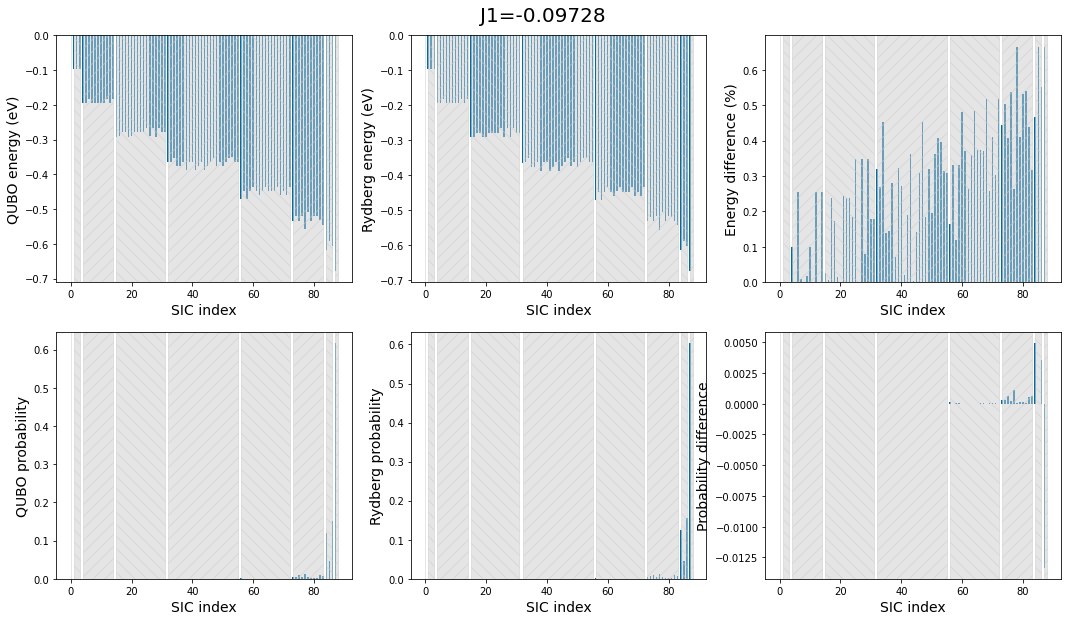

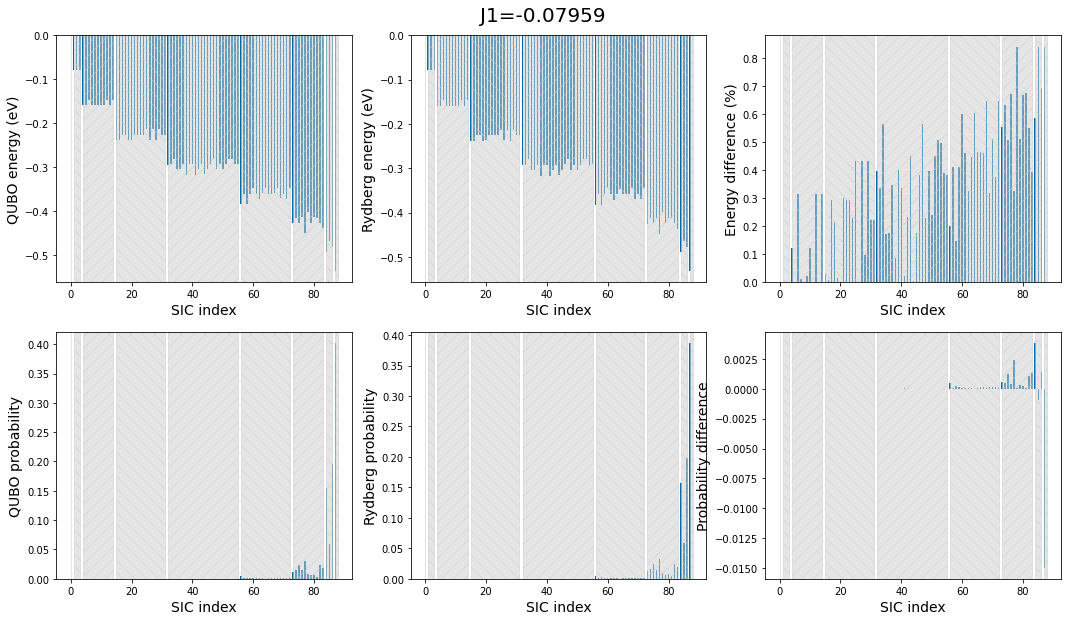

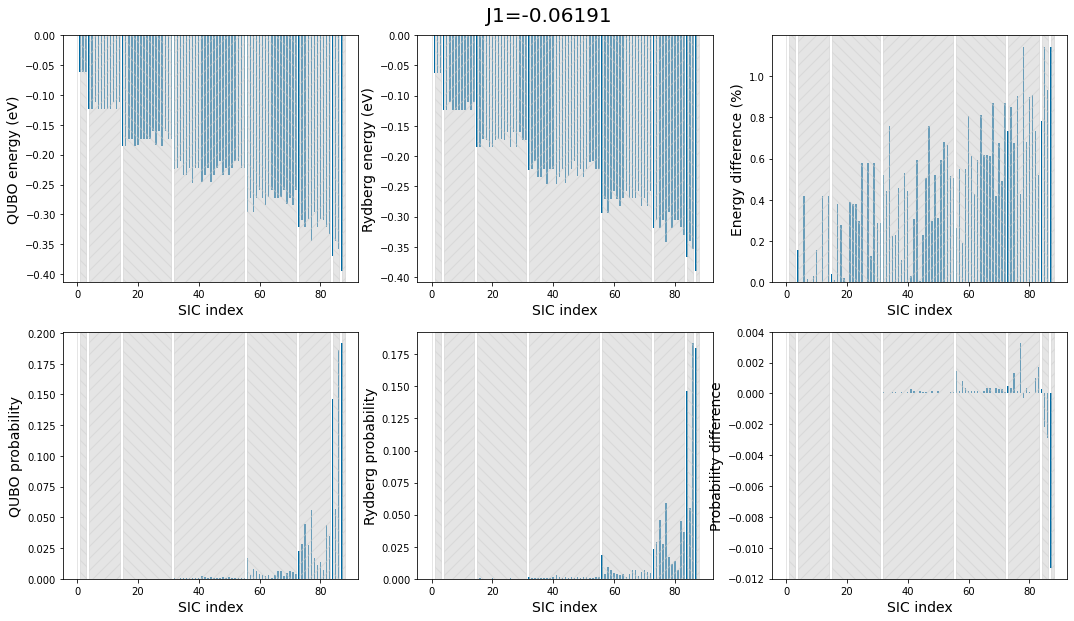

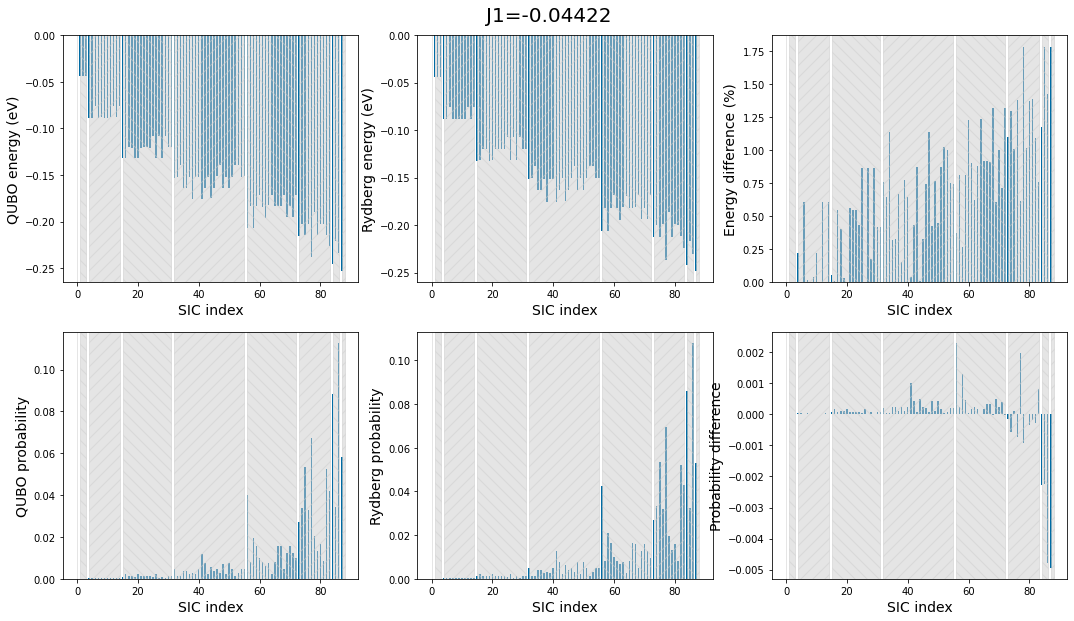

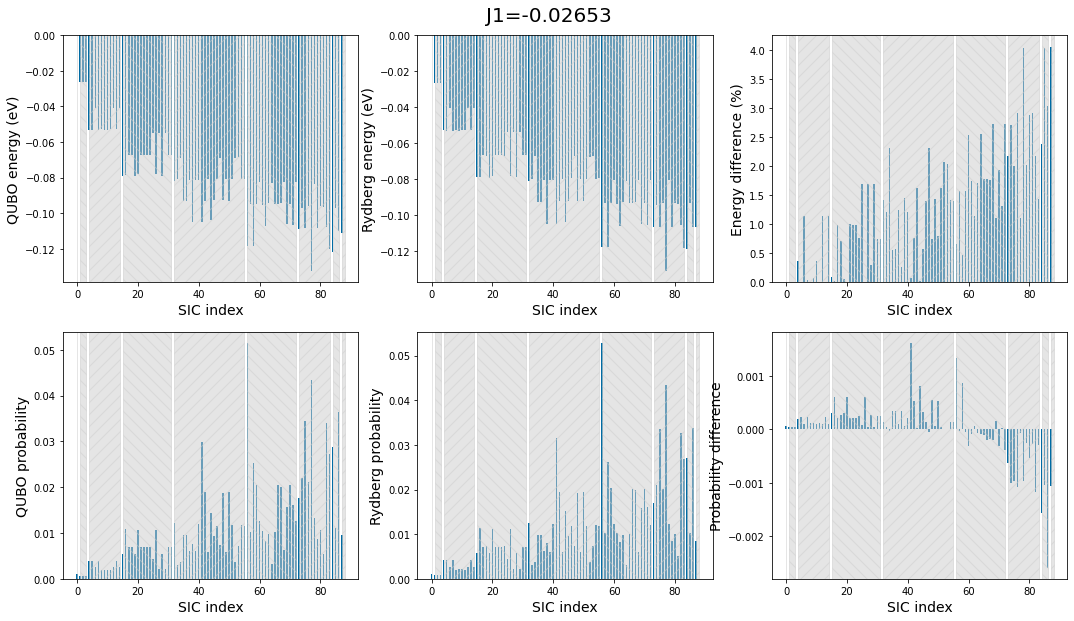

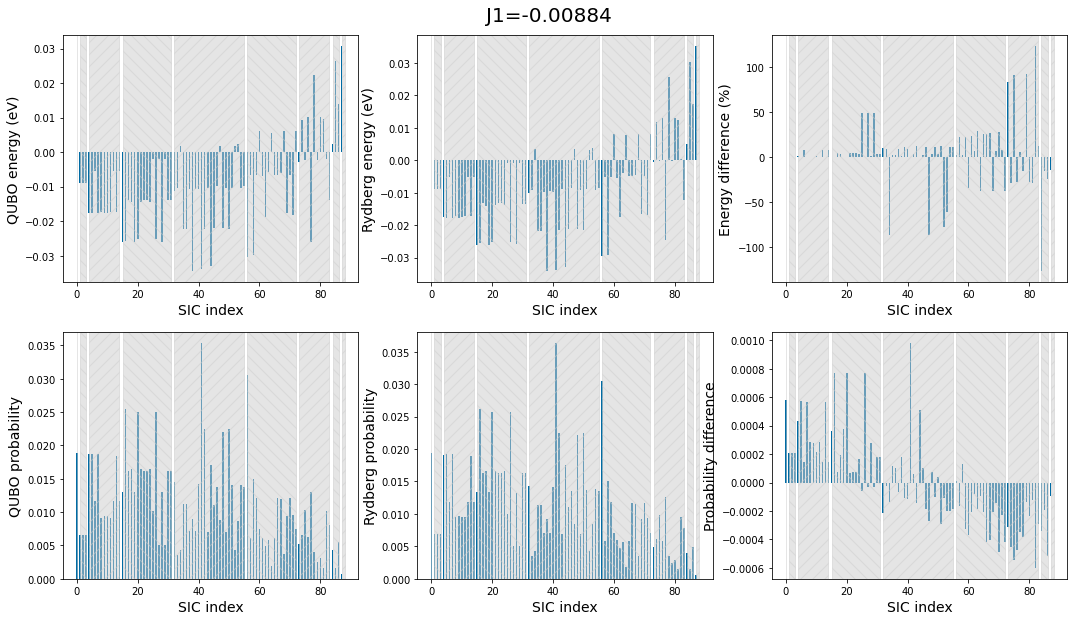

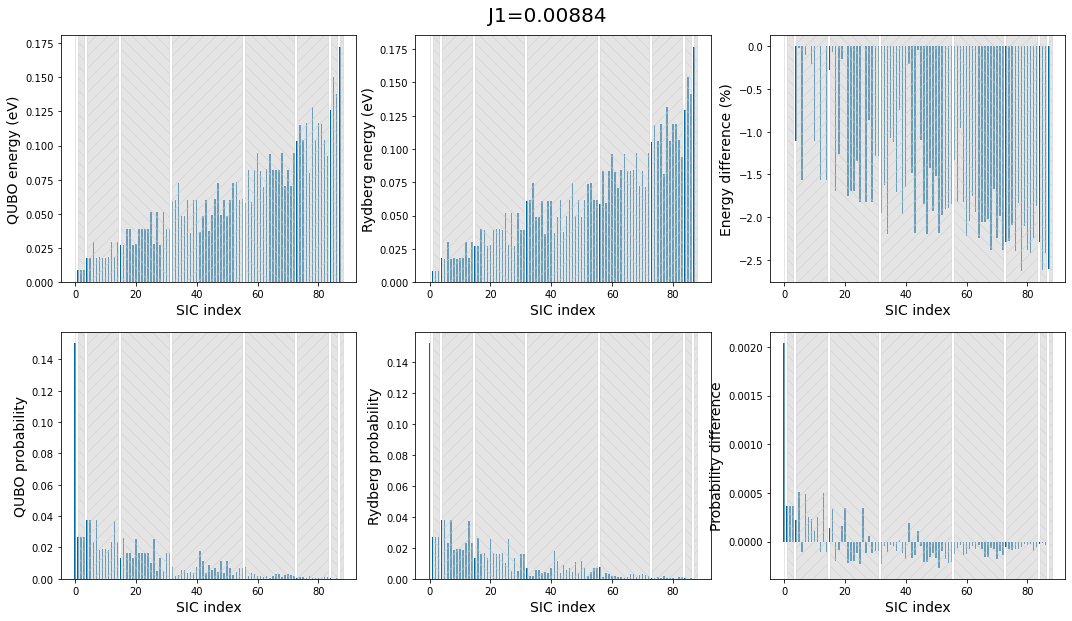

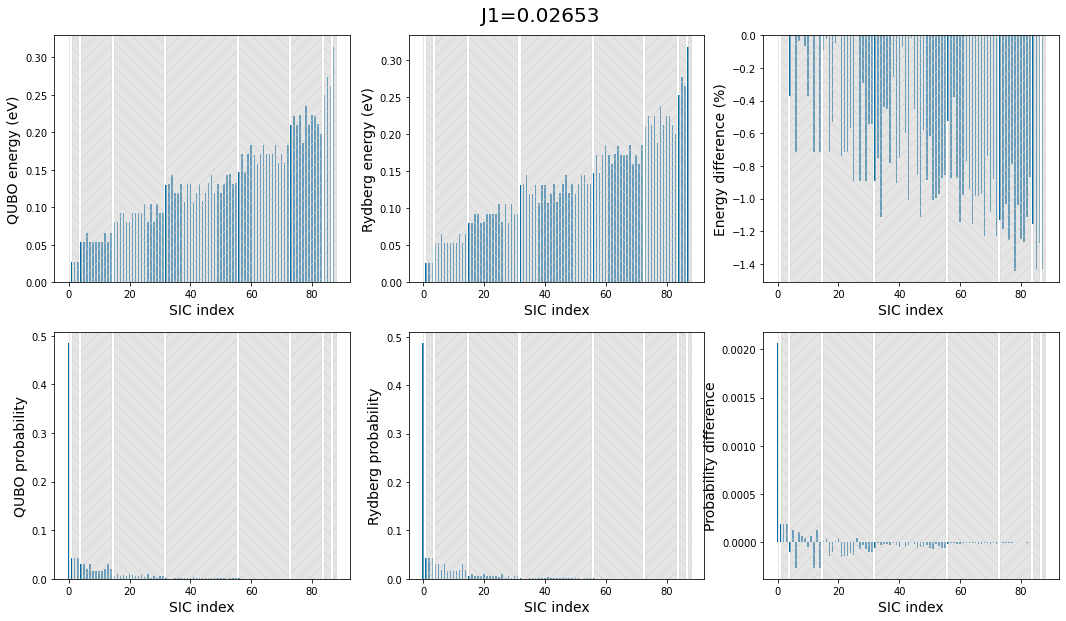

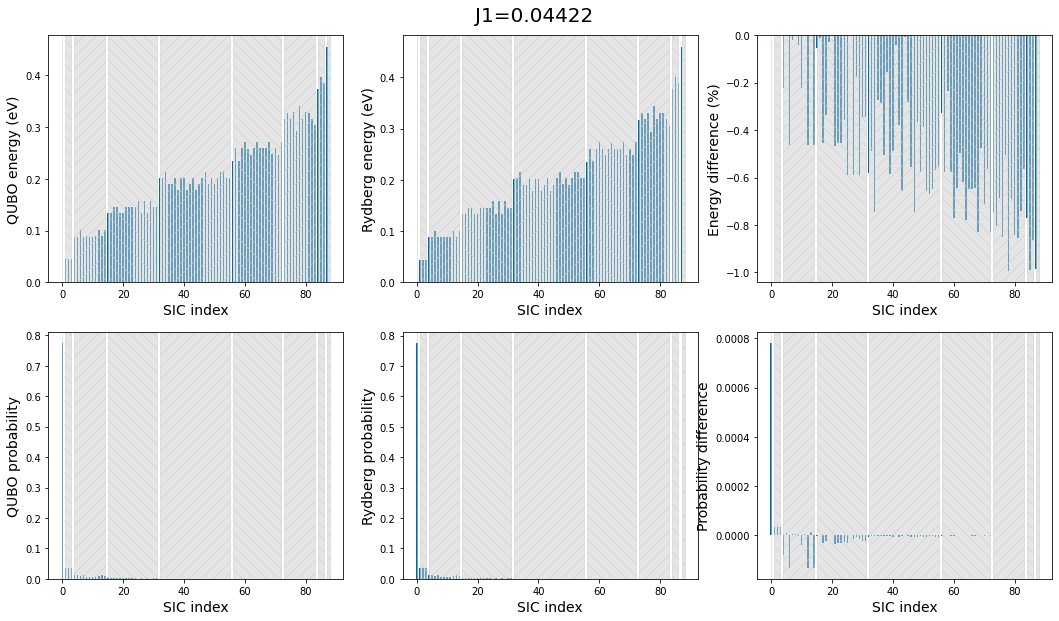

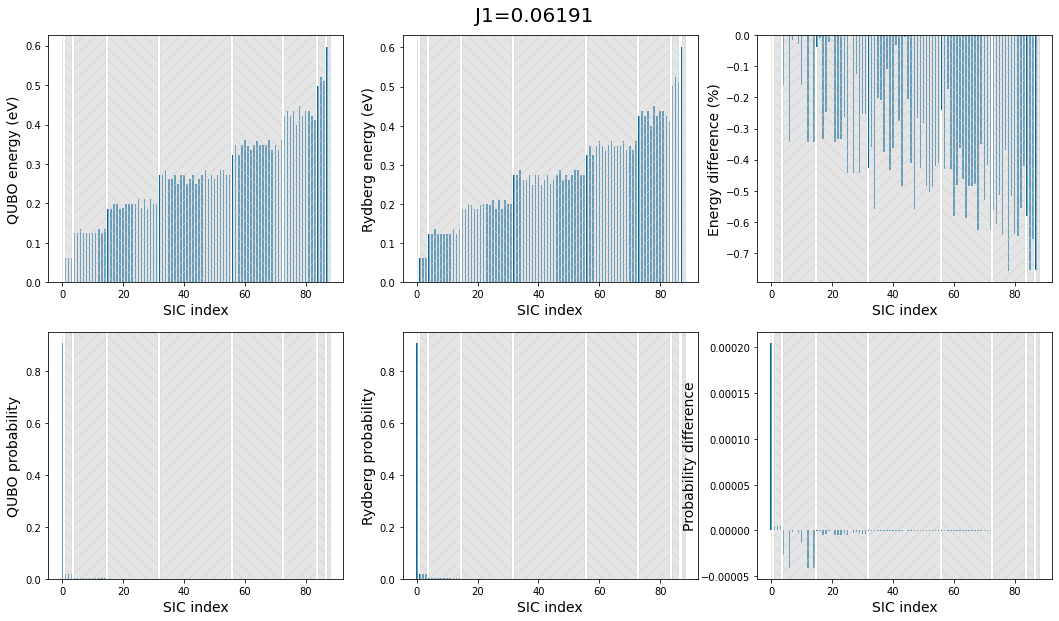

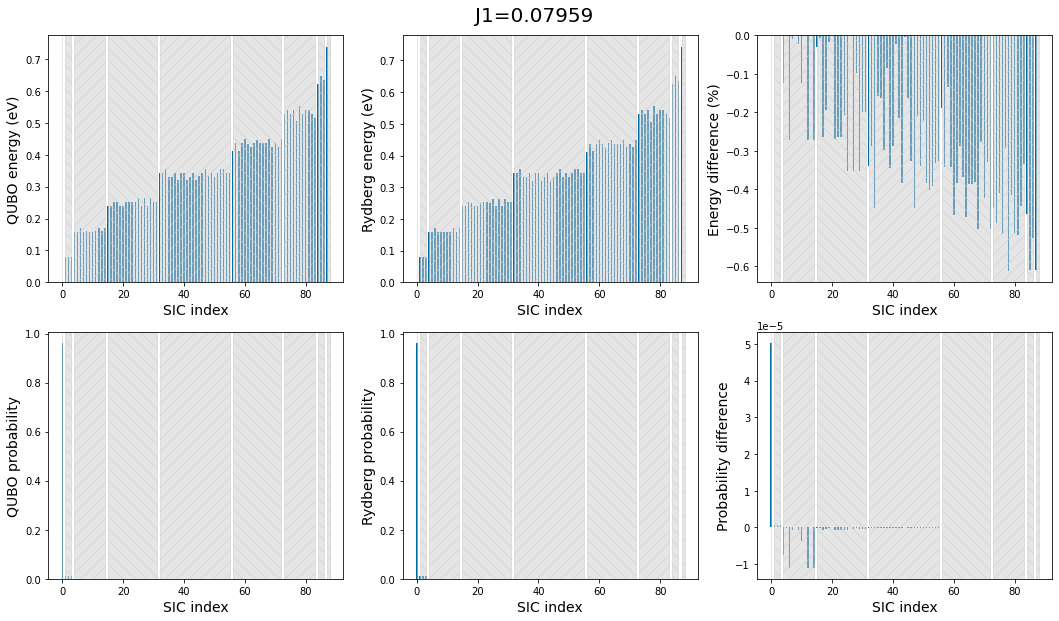

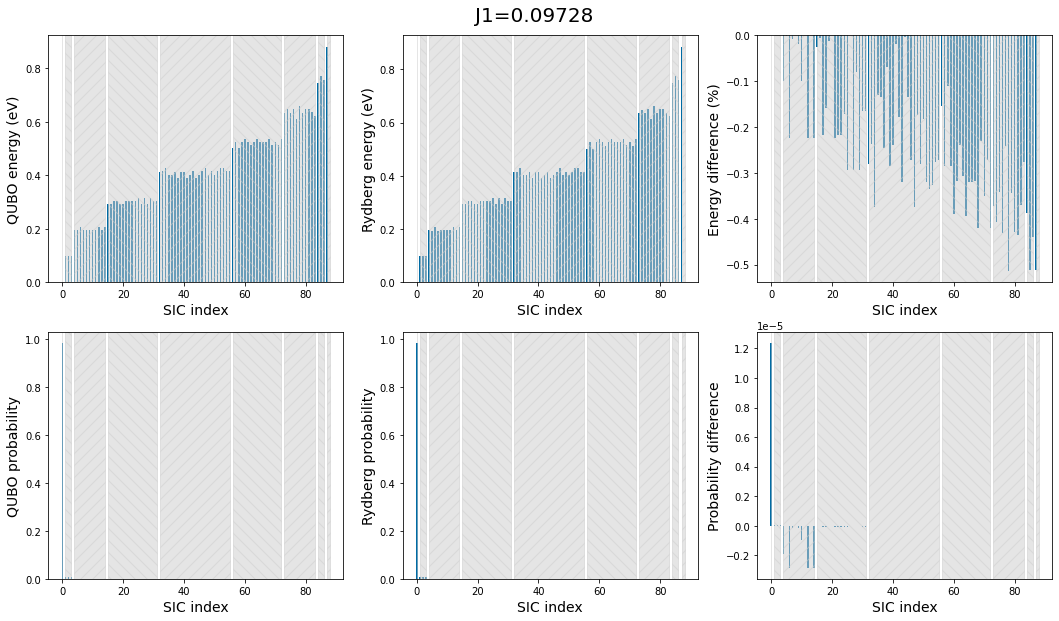

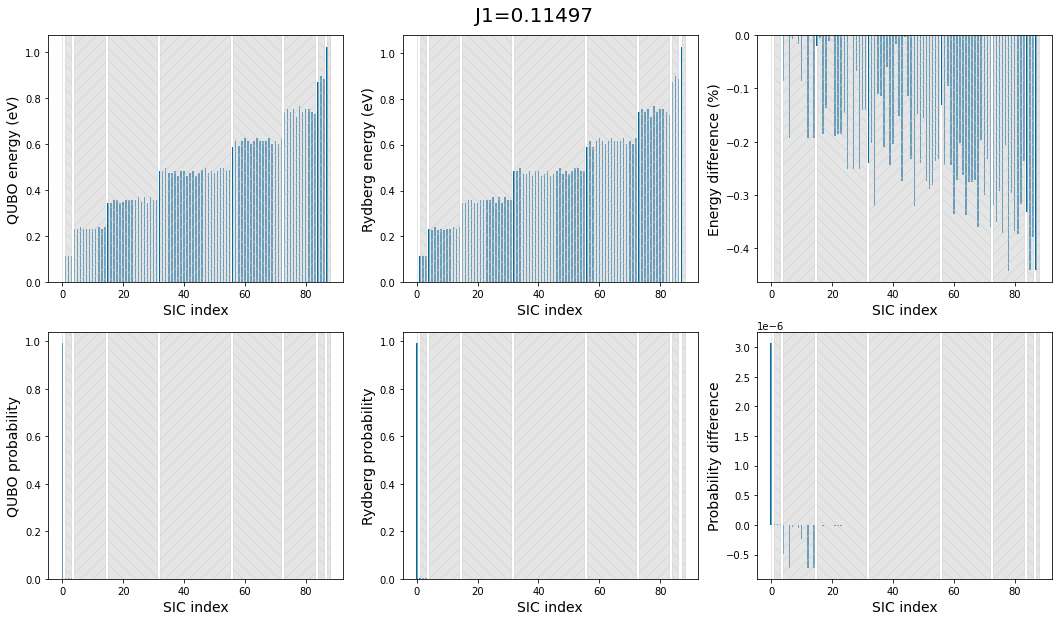

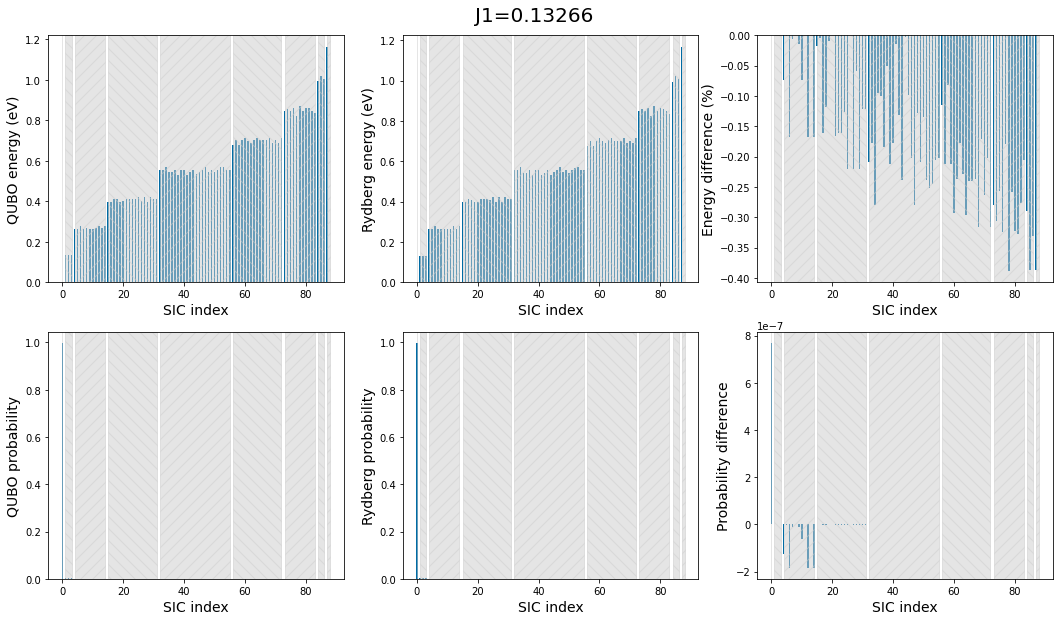

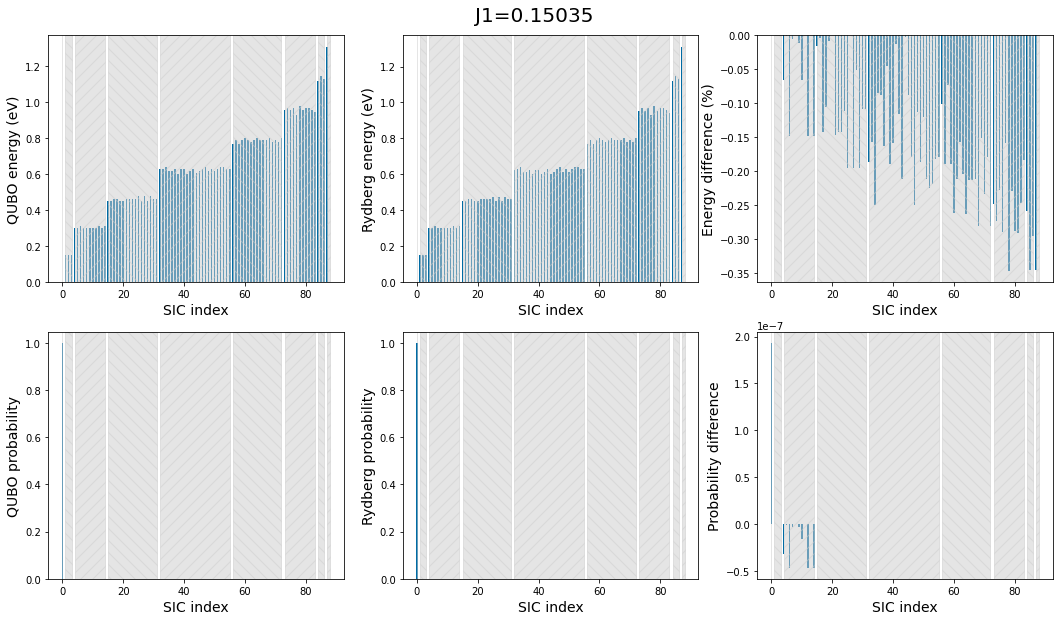

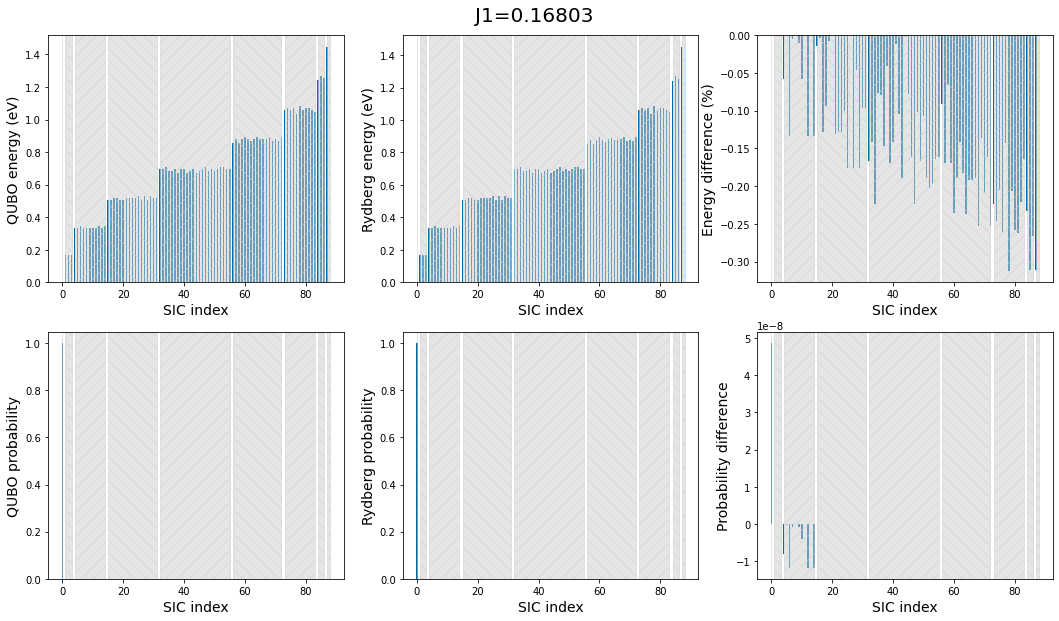

In [528]:
# QUBO values contrained
for mu in np.arange(-2.1,1,0.2):
    J1 = 0.08843826 + 0.08843826*mu
    E_ryd = get_final_ryd_Hamiltonian_v2(
        coords, 
        detuning = 125000000.0,
        J1=J1,J2=0.01255761,
        C6 = 5.42e-24)[0]
    E_QUBO = QUBO(neighbors, J1=J1, J2=0.01209251, J3=0.0004651)[0]
    
    configurations = np.array(list(itertools.product([0, 1], repeat=graphene_scell.num_sites)))
    config_unique, E_QUBO_sic, multiplicity = find_sic(configurations,atom_indices,energies=E_QUBO,sort=True)
    config_unique, E_ryd_sic,multiplicity = find_sic(configurations,atom_indices,energies=E_ryd,sort=True)
    E_QUBO_sic = np.array(E_QUBO_sic)
    E_ryd_sic = np.array(E_ryd_sic)
    plot_E_p_differences_v2(config_unique,multiplicity,E_QUBO_sic,E_ryd_sic,
                            percent=True, title='J1={}'.format(np.round(J1,5)))

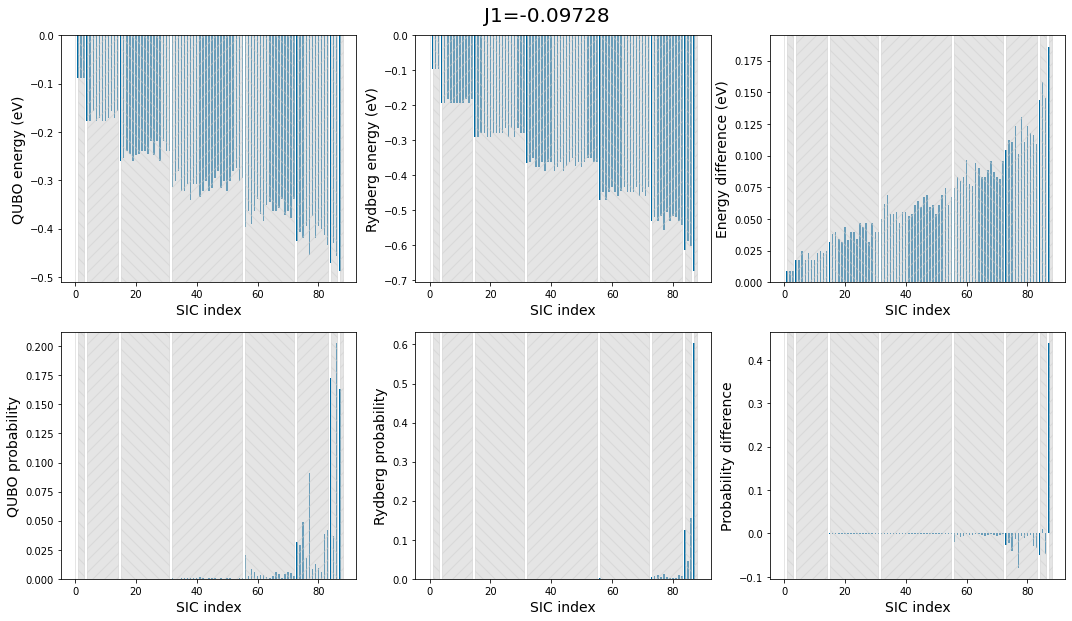

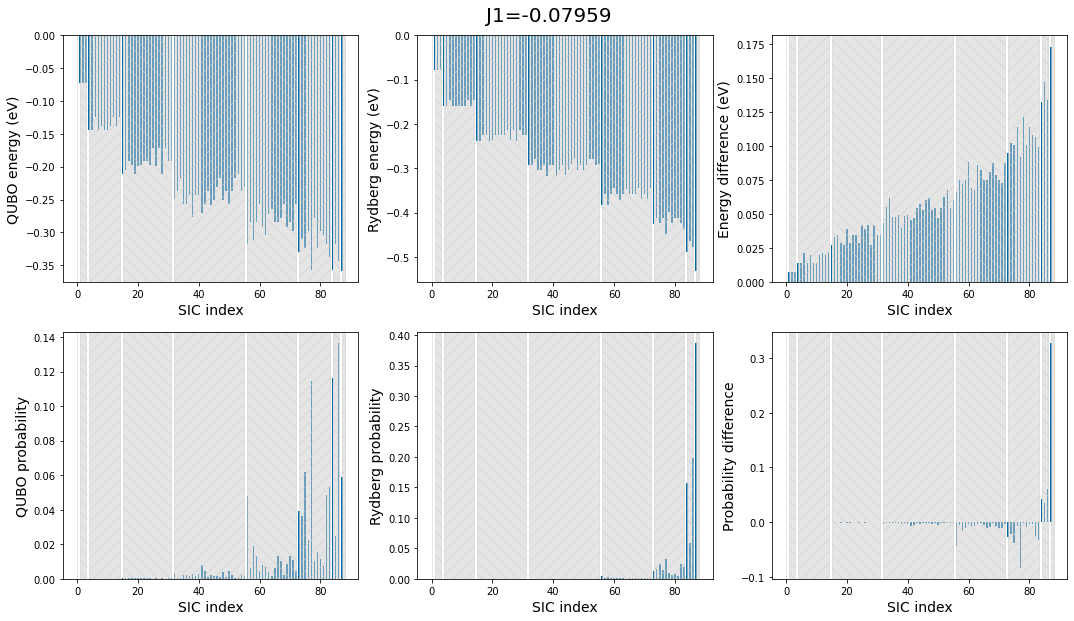

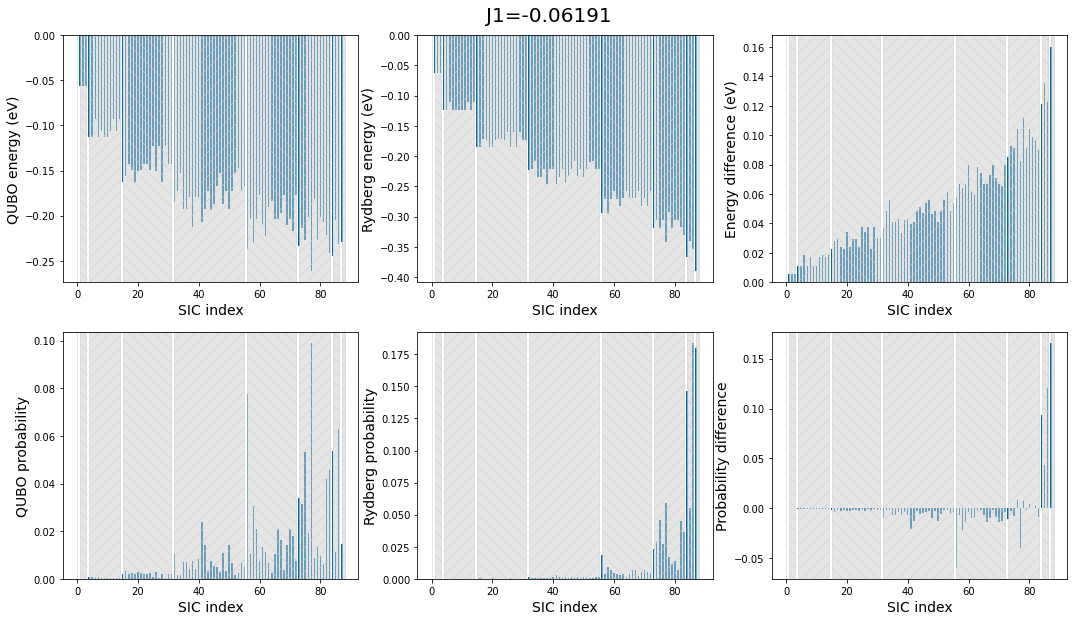

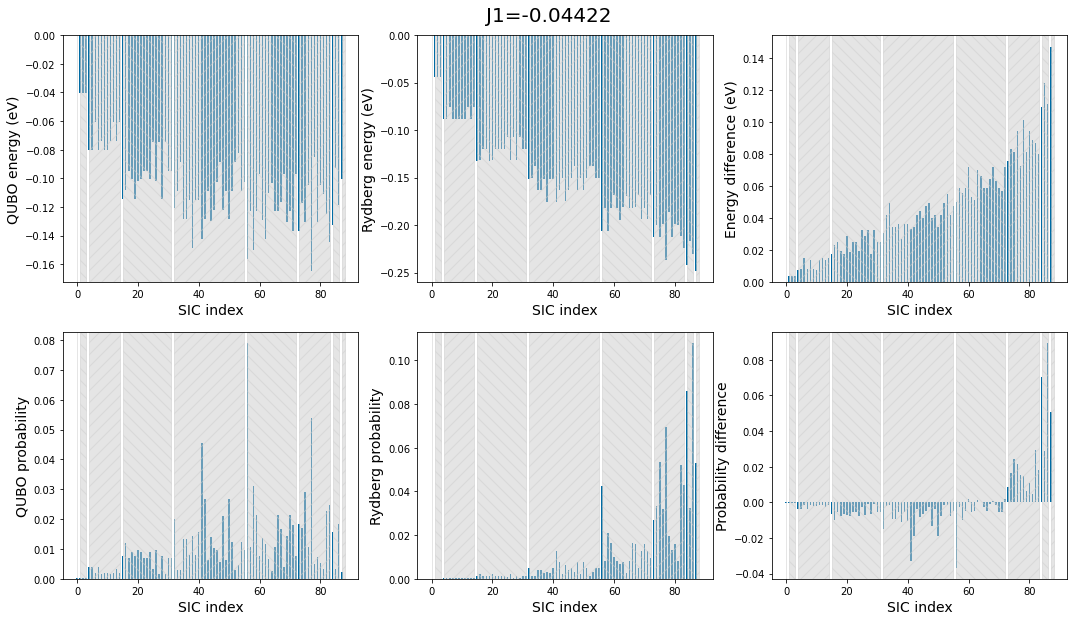

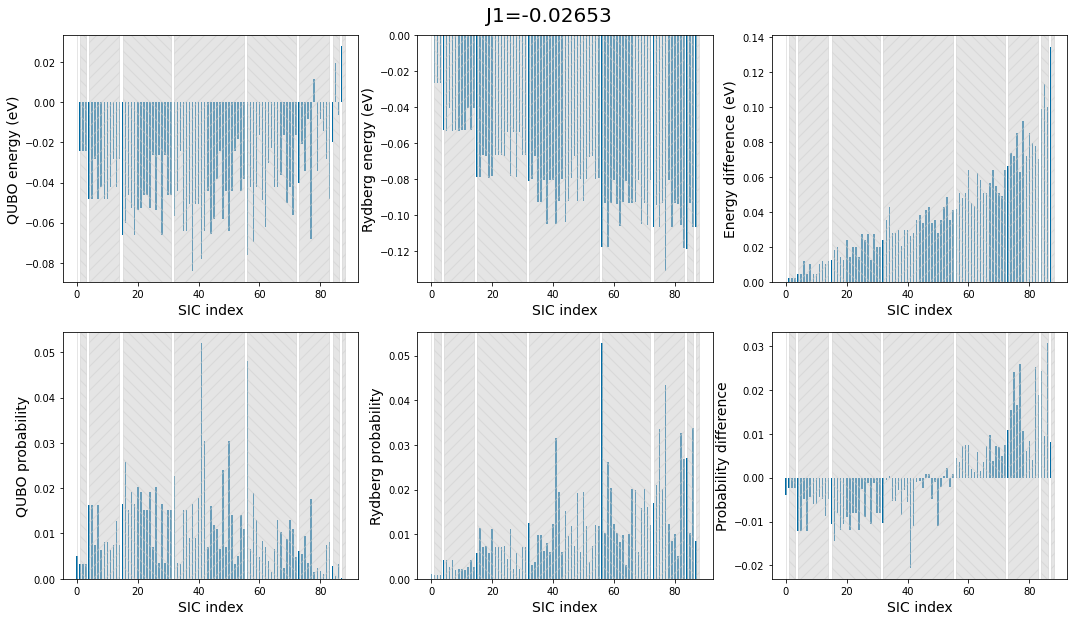

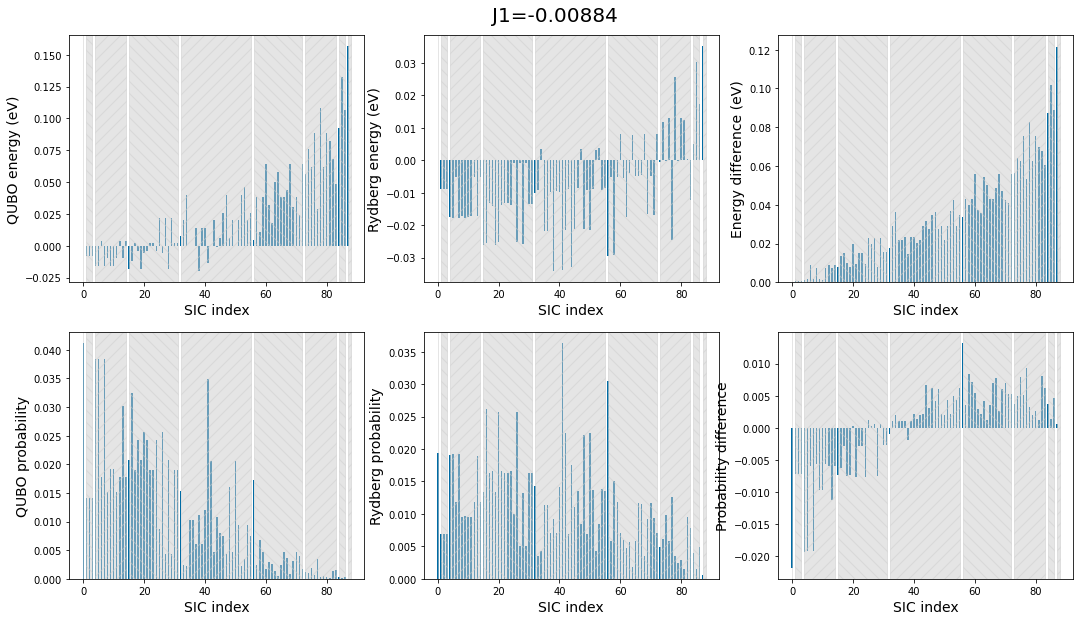

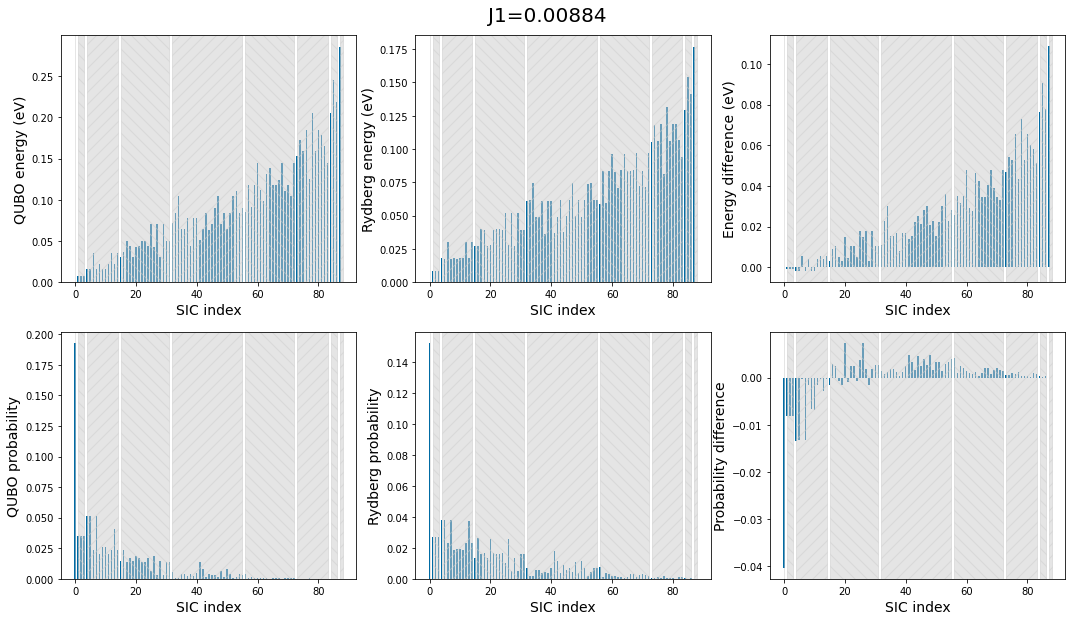

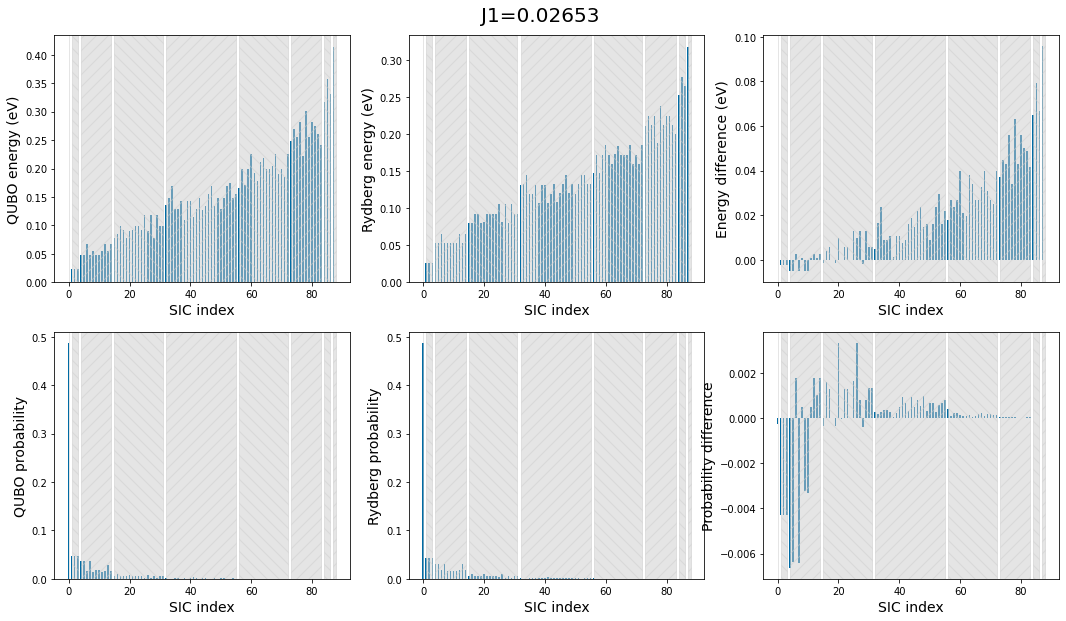

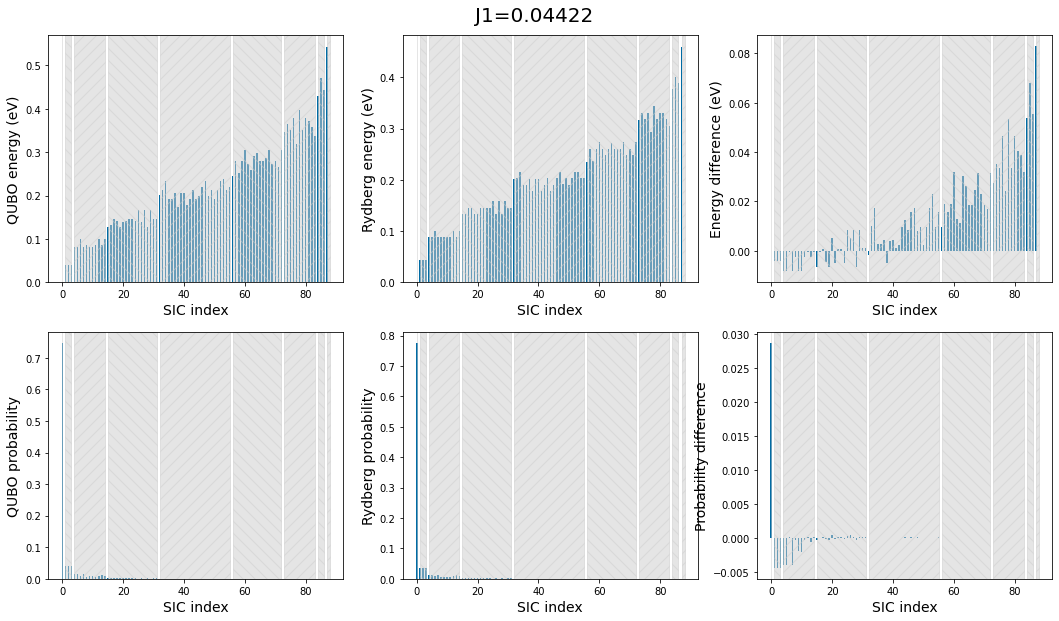

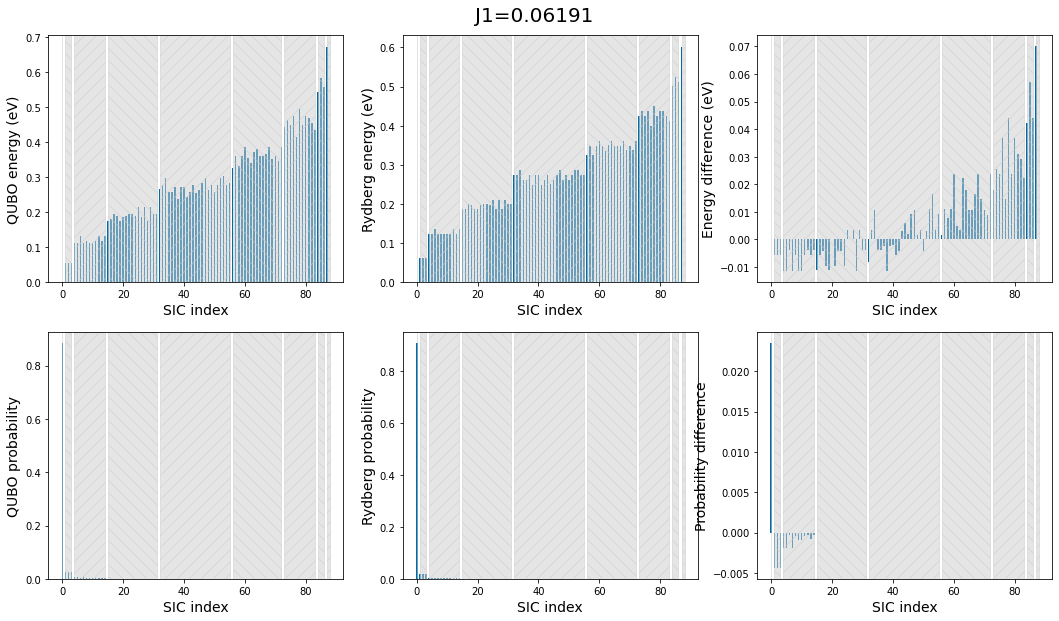

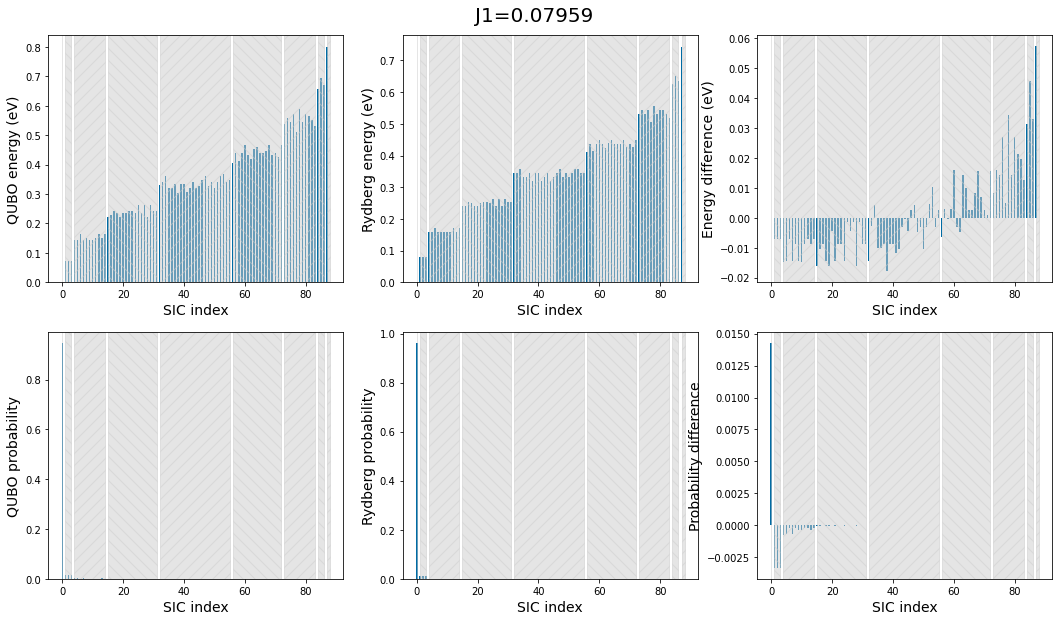

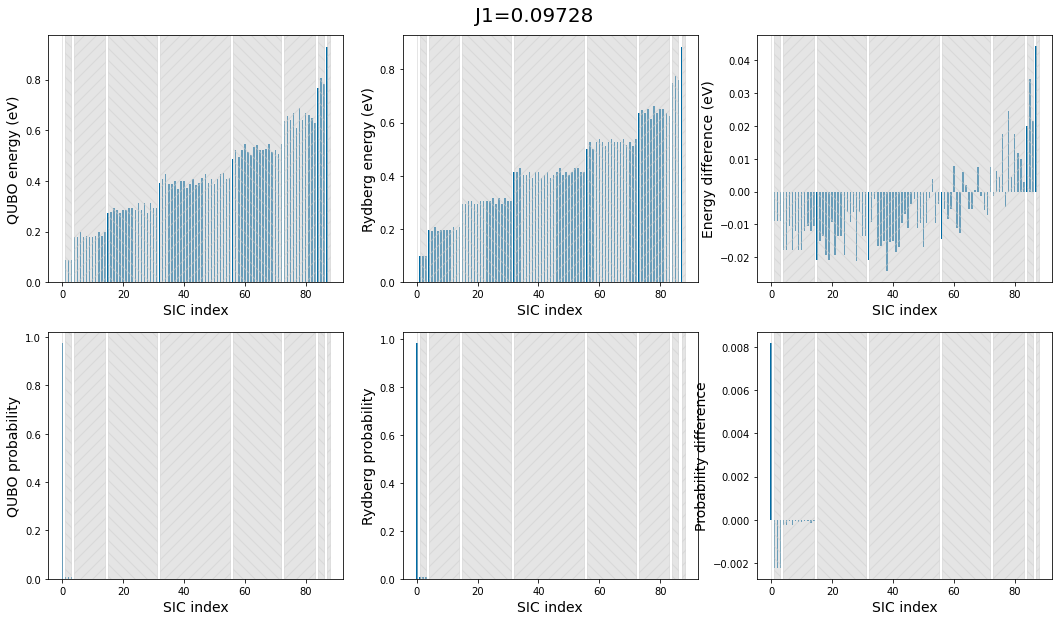

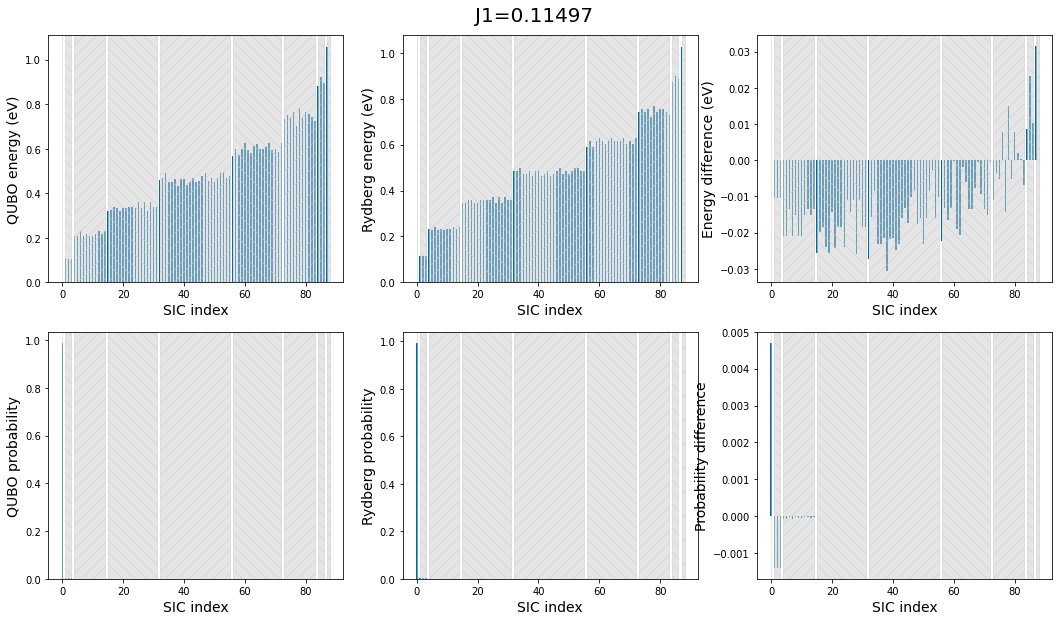

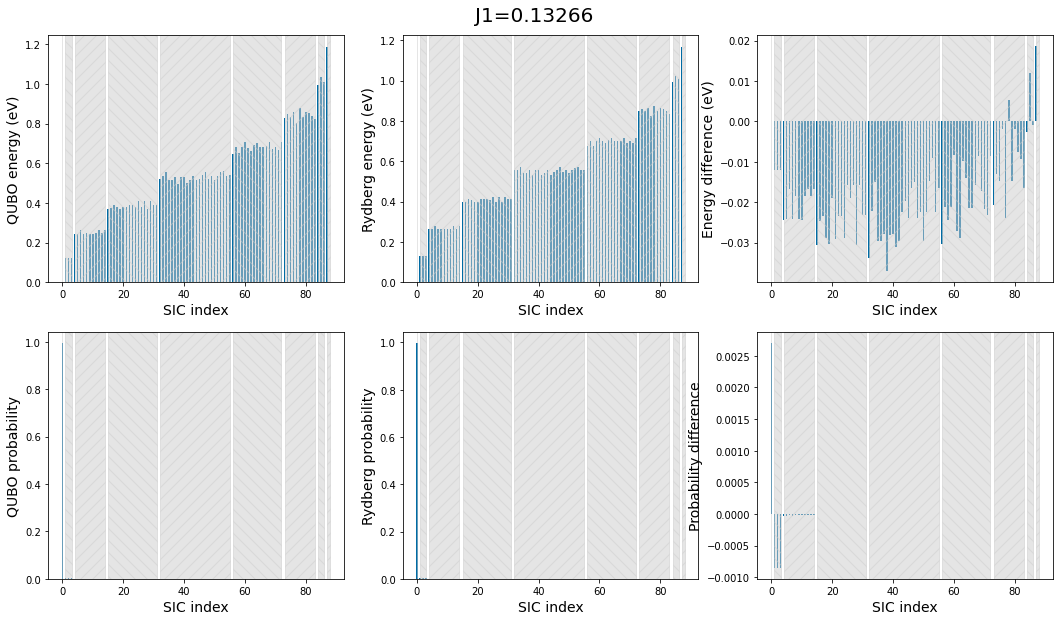

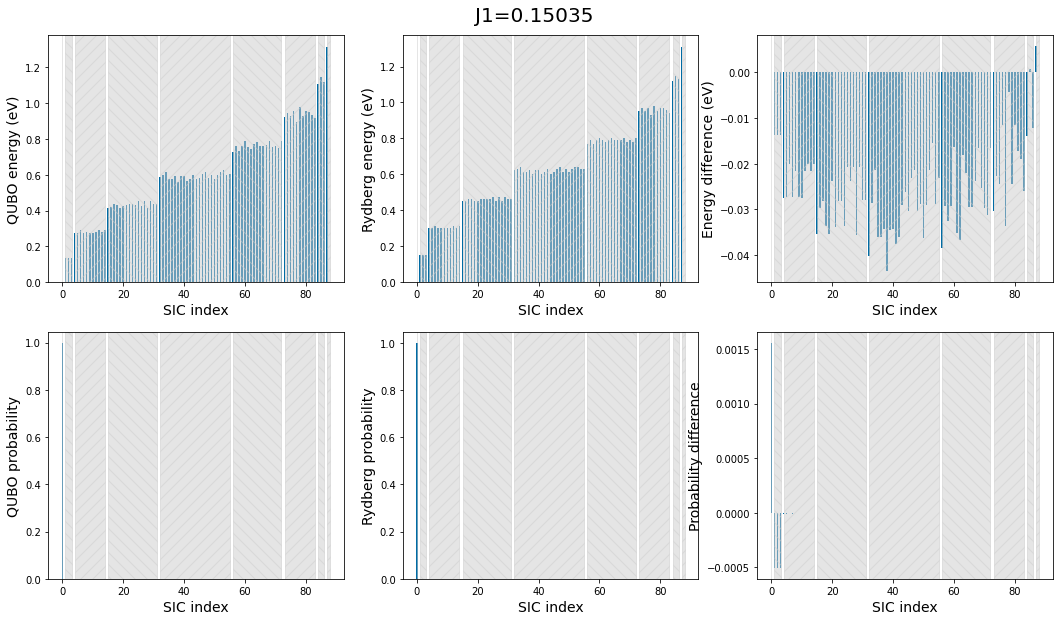

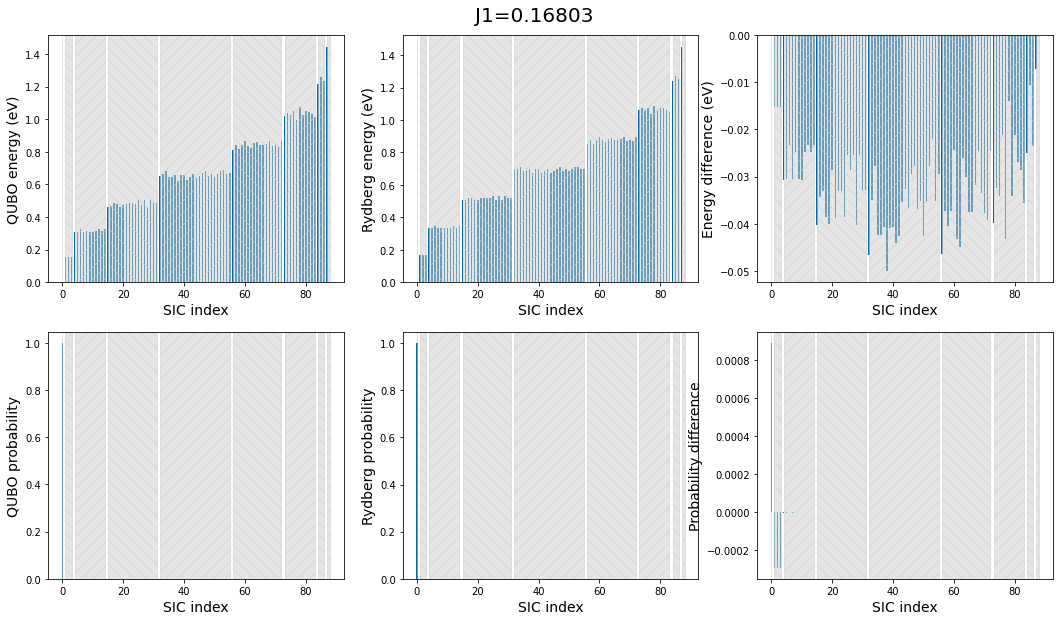

In [530]:
# optimised QUBO values
for mu in np.arange(-2.1,1,0.2):
    J1 = 0.08843826 + 0.08843826*mu
    E_ryd = get_final_ryd_Hamiltonian_v2(
        coords, 
        detuning = 125000000.0,
        J1=J1,
        J2=0.01255761,
        C6 = 5.42e-24)[0]
    E_QUBO = QUBO(neighbors, J1=0.080403+0.080403*mu, J2=0.019894, J3=0.006172)[0]
    
    configurations = np.array(list(itertools.product([0, 1], repeat=graphene_scell.num_sites)))
    config_unique, E_QUBO_sic, multiplicity = find_sic(configurations,atom_indices,energies=E_QUBO,sort=True)
    config_unique, E_ryd_sic,multiplicity = find_sic(configurations,atom_indices,energies=E_ryd,sort=True)
    E_QUBO_sic = np.array(E_QUBO_sic)
    E_ryd_sic = np.array(E_ryd_sic)
    plot_E_p_differences_v2(config_unique,multiplicity,E_QUBO_sic,E_ryd_sic,
                            percent=False, title='J1={}'.format(np.round(J1,5)))

# <a id='final_structures'>Final structures</a>

# <a id='small'>Small</a>

![graphene_10](graphene_10.png)

In [682]:
from scipy.optimize import minimize
from scipy.spatial.distance import squareform, pdist
from scipy.sparse import lil_matrix
import numpy as np

def objective_function(coords, new_distances):
    # Reshape the flattened coordinates into the original shape
    coords_2d = coords.reshape(-1, 2)
    
    # Calculate pairwise distances using the current coordinates
    distances = squareform(pdist(coords_2d))
    
    # Calculate the difference between the current and new distances
    diff = distances - new_distances
    
    # Return the sum of squared differences
    return np.sum(diff ** 2)

def build_full_distance_matrix(nearest_distances_dict, num_atoms):
    # Initialize an empty matrix to store distances
    full_distances = np.full((num_atoms, num_atoms), np.inf)
    
    # Populate the matrix with the given nearest neighbor distances
    for (i, j), distance in nearest_distances_dict.items():
        full_distances[i, j] = distance
        full_distances[j, i] = distance  # The matrix is symmetric
    
    return full_distances

def find_new_coordinates(initial_coords, nearest_distances_dict):
    # Determine the number of atoms
    num_atoms = max(max(pair) for pair in nearest_distances_dict.keys()) + 1
    
    # Build the full distance matrix from the nearest neighbor distances
    new_distances_full = build_full_distance_matrix(nearest_distances_dict, num_atoms)
    
    # Flatten the initial coordinates into a 1D array
    initial_coords_flat = initial_coords.flatten()
    
    # Define bounds for optimization (optional)
    bounds = [(-np.inf, np.inf)] * len(initial_coords_flat)
    
    # Minimize the objective function using the initial coordinates as starting point
    result = minimize(objective_function, initial_coords_flat, args=(new_distances_full,), bounds=bounds)
    
    # Reshape the optimized coordinates back into the original shape
    new_coords = result.x.reshape(-1, 2)
    
    return new_coords

# Example usage
initial_coords = square_test.cart_coords[:,0:2]  # Example initial coordinates

# Example sparse new distance matrix
nearest_distances_dict = {(0, 1): 0.5, (1, 2): 1, (2,3):1, (0,3):1}

new_coords = find_new_coordinates(initial_coords, nearest_distances_dict)
print("New coordinates:")
print(new_coords)


New coordinates:
[[0. 0.]
 [1. 0.]
 [1. 1.]
 [0. 1.]]


In [585]:
coordinates_10 = np.array([[-3.46410161e+00,  1.00000000e+00,  0.00000000e+00],
                           [-1.73205081e+00,  2.00000000e+00,  0.00000000e+00],
                           [-2.80528344e-15,  1.00000000e+00,  0.00000000e+00],
                           [ 1.73205081e+00,  2.00000000e+00,  0.00000000e+00],
                           [ 3.46410161e+00,  1.00000000e+00,  0.00000000e+00],
                           [ 3.46410161e+00, -1.00000000e+00,  0.00000000e+00],
                           [ 1.73205081e+00, -2.00000000e+00,  0.00000000e+00],
                           [-2.80528344e-15, -1.00000000e+00,  0.00000000e+00],
                           [-1.73205081e+00, -2.00000000e+00,  0.00000000e+00],
                           [-3.46410161e+00, -1.00000000e+00,  0.00000000e+00]])

In [596]:
np.unique(np.round(a.distance_matrix,5))[1]

1.42474

In [637]:
2**24

16777216

In [595]:
np.unique(np.round(a.distance_matrix,5))/np.unique(np.round(a.distance_matrix,5))[1]

array([0.        , 1.        , 1.73204936, 2.        , 2.64575291,
       3.        , 3.46410573, 3.6055561 ])

# <a id='large'>Large</a>

![graphene_24](graphene_24.png)

In [597]:
coordinates_24 = np.array([[-5.19615242e+00,  1.00000000e+00,  0.00000000e+00],
                       [-1.73205081e+00, -5.00000000e+00,  0.00000000e+00],
                       [ 1.73205081e+00,  1.00000000e+00,  0.00000000e+00],
                       [-3.46410161e+00,  4.00000000e+00,  0.00000000e+00],
                       [-1.36160759e-15, -2.00000000e+00,  0.00000000e+00],
                       [ 3.46410161e+00,  4.00000000e+00,  0.00000000e+00],
                       [-3.46410161e+00, -2.00000000e+00,  0.00000000e+00],
                       [-2.74305690e-15,  4.00000000e+00,  0.00000000e+00],
                       [ 3.46410161e+00, -2.00000000e+00,  0.00000000e+00],
                       [-1.73205081e+00,  1.00000000e+00,  0.00000000e+00],
                       [ 1.73205081e+00, -5.00000000e+00,  0.00000000e+00],
                       [ 5.19615242e+00,  1.00000000e+00,  0.00000000e+00],
                       [-5.19615242e+00, -1.00000000e+00,  0.00000000e+00],
                       [-1.73205081e+00,  5.00000000e+00,  0.00000000e+00],
                       [ 1.73205081e+00, -1.00000000e+00,  0.00000000e+00],
                       [-3.46410161e+00,  2.00000000e+00,  0.00000000e+00],
                       [-4.08429358e-15, -4.00000000e+00,  0.00000000e+00],
                       [ 3.46410161e+00,  2.00000000e+00,  0.00000000e+00],
                       [-3.46410161e+00, -4.00000000e+00,  0.00000000e+00],
                       [-4.06310117e-15,  2.00000000e+00,  0.00000000e+00],
                       [ 3.46410161e+00, -4.00000000e+00,  0.00000000e+00],
                       [-1.73205081e+00, -1.00000000e+00,  0.00000000e+00],
                       [ 1.73205081e+00,  5.00000000e+00,  0.00000000e+00],
                       [ 5.19615242e+00, -1.00000000e+00,  0.00000000e+00]])

In [601]:
graphene_24 = Structure(np.eye(3)*100,[6]*24,coordinates_24,coords_are_cartesian=True)

In [634]:
original_input = []
with open('./data/config_analysis/graphene_24.d12') as file:
    original_input = file.readlines()

In [653]:
np.zeros((3,24),dtype='int')

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]])

In [702]:
atom_type1=[]
multiplicity = [1]
config_binary = np.zeros((1,24),dtype='int')
from CRYSTALpytools.execute import runcry
for i in range(1,25):    
    original_input[-3] = '{}\n'.format(i)
    with open('./data/config_analysis/graphene_24_{}.d12'.format(i),'w') as file:
        for item in original_input:
            file.write(str(item))
#     sh.copy('./data/config_analysis/graphene_24.gui','./data/config_analysis/graphene_24_{}.gui'.format(i))
#     runcry('./data/config_analysis/graphene_24_{}'.format(i))
    
    output = Crystal_output().read_cry_output('./data/config_analysis/graphene_24_{}.out'.format(i))
    atom_type1_tmp, _, mult = output.get_config_analysis(return_multiplicity=True)
    atom_type1_tmp = np.array(atom_type1_tmp)-1
    #print(atom_type1_tmp)
    num_config = len(atom_type1_tmp)
    config_binary_tmp = np.zeros((num_config,24),dtype='int')
    for j,atoms in enumerate(atom_type1_tmp):
        config_binary_tmp[j][atoms] = 1
    config_binary_tmp = np.unique(config_binary_tmp,axis=0)
    config_binary = np.concatenate((config_binary,config_binary_tmp),axis=0)
    multiplicity.extend(mult)
multiplicity = np.array(multiplicity)

In [705]:
# np.savetxt('./data/config_analysis/graphene_24_binary.csv',config_binary,delimiter=',',fmt='%d')
# np.savetxt('./data/config_analysis/graphene_24_binary_mult.csv',multiplicity,delimiter=',',fmt='%d')

In [22]:
np.genfromtxt('./data/config_analysis/graphene_24_binary.csv',delimiter=',')

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [709]:
len(multiplicity)

4200448

In [630]:
np.sum(Crystal_output().read_cry_output(
    './data/config_analysis/graphene_24.out').get_config_analysis(
    return_multiplicity=True)[2])

276

In [633]:
np.sum(Crystal_output().read_cry_output(
    './data/config_analysis/graphene_24_ALL.out').get_config_analysis(
    return_multiplicity=True)[2])

/Users/brunocamino/Desktop/Imperial/crystal-code-tools/CRYSTALpytools/CRYSTALpytools/crystal_io.py:834: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  warning = np.where(config_list == 'WARNING')
/Users/brunocamino/Desktop/Imperial/crystal-code-tools/CRYSTALpytools/CRYSTALpytools/crystal_io.py:836: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  atom1_begin = np.where(config_list == original_atom)[0]
/Users/brunocamino/Desktop/Imperial/crystal-code-tools/CRYSTALpytools/CRYSTALpytools/crystal_io.py:838: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  config_list == dash_line)[0]
/Users/brunocamino/Desktop/Imperial/crystal-code-tools/CRYSTALpytools/CRYSTALpytools/crystal_io.py:839: FutureWarning: elementwise comparison failed; returning scalar instead

IndexError: index -1 is out of bounds for axis 0 with size 0

Build a supercell with pymatgen

#### PBC

In [ ]:
lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

supercell_order = 2
scaling_matrix = np.array([[supercell_order, 0, 0],
                            [0, supercell_order, 0],
                            [0, 0, 1]])
graphene_scell = copy.deepcopy(graphene)
graphene_scell.make_supercell(scaling_matrix)
# Reorder the atoms in the supercell so they follow the convention we are using (top to bottom, left to right).
ordering = [1,5,0,3,4,7,2,6]
graphene_scell = Structure(graphene_scell.lattice,graphene_scell.atomic_numbers,
                           graphene_scell.frac_coords[ordering])


#### No PBC

In [96]:
lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

supercell_order = 2
scaling_matrix = np.array([[supercell_order, 0, 0],
                            [0, supercell_order, 0],
                            [0, 0, 1]])
graphene_scell = copy.deepcopy(graphene)
graphene_scell.make_supercell(scaling_matrix)
# Reorder the atoms in the supercell so they follow the convention we are using (top to bottom, left to right).
ordering = [1,5,0,3,4,7,2,6]
graphene_scell_8 = Molecule(graphene_scell.atomic_numbers,
                           graphene_scell.cart_coords[ordering])


# Build the reference 3x3 graphene supercell

Build a supercell with pymatgen

#### PBC

In [5]:
lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

supercell_order = 3
scaling_matrix = np.array([[supercell_order, 0, 0],
                            [0, supercell_order, 0],
                            [0, 0, 1]])
graphene_scell = copy.deepcopy(graphene)
graphene_scell.make_supercell(scaling_matrix)
# Reorder the atoms in the supercell so they follow the convention we are using (top to bottom, left to right).
ordering = [2,11,1,5,10,14,0,4,8,9,13,17,3,7,12,16,6,15]
graphene_scell_3 = Structure(graphene_scell.lattice,graphene_scell.atomic_numbers,
                           graphene_scell.frac_coords[ordering])


In [5]:
vview(graphene_scell_3)

#### No PBC unit cell

In [6]:
lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

supercell_order = 3
scaling_matrix = np.array([[supercell_order, 0, 0],
                            [0, supercell_order, 0],
                            [0, 0, 1]])
graphene_scell = copy.deepcopy(graphene)
graphene_scell.make_supercell(scaling_matrix)
# Reorder the atoms in the supercell so they follow the convention we are using (top to bottom, left to right).
ordering = [2,11,1,5,10,14,0,4,8,9,13,17,3,7,12,16,6,15]
graphene_scell_no_pbc_3 = Molecule(graphene_scell.atomic_numbers,
                           graphene_scell.cart_coords[ordering])


#### No PBC unit cell - single coordinated atoms

In [93]:
lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

supercell_order = 3
scaling_matrix = np.array([[supercell_order, 0, 0],
                            [0, supercell_order, 0],
                            [0, 0, 1]])
graphene_scell = copy.deepcopy(graphene)
graphene_scell.make_supercell(scaling_matrix)
graphene_scell.remove_sites([2,15])

# Reorder the atoms in the supercell so they follow the convention we are using (top to bottom, left to right).

ordering = [10,1,4,9,13,0,3,7,8,12,15,2,6,11,14,5]

graphene_scell_no_pbc_no_single_3 = Molecule(graphene_scell.atomic_numbers,
                           graphene_scell.cart_coords[ordering])
vview(graphene_scell_no_pbc_no_single_3)

In [53]:
lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

supercell_order = 3
scaling_matrix = np.array([[supercell_order, 0, 0],
                            [0, supercell_order, 0],
                            [0, 0, 1]])
graphene_scell = copy.deepcopy(graphene)
graphene_scell.make_supercell(scaling_matrix)
graphene_scell.remove_sites([2,15,11,1,5,12,16,6])

# Reorder the atoms in the supercell so they follow the convention we are using (top to bottom, left to right).

ordering = [6,8,0,2,4,5,7,9,1,3]

graphene_scell_no_pbc_no_single_2 = Molecule(graphene_scell.atomic_numbers,
                           graphene_scell.cart_coords[ordering])
vview(graphene_scell_no_pbc_no_single_2)

$$
J2 = \frac{C_6}{R_{01}^{6}} \frac{1}{6.5821\times10^{-16}}
$$

In [287]:
rad_s_to_eV = 6.5821e-16
C = 5.42e-24
R = (C*rad_s_to_eV)**(1/6)
J1 = 0.080403
J2 = 0.019894
J3 = 0.006172
((C/J2)*(1/rad_s_to_eV))**(1/6)


0.08632808678729599

$$
J2+J3 = \left(\frac{C_6}{R_{01}^{6}}+\frac{C_6}{R_{02}^{6}}\right)\frac{1}{6.5821\times10^{-16}} =\left(\frac{C_6}{R_{01}^{6}}+\frac{C_6}{1.73 R_{01}^{6}}\right)\frac{1}{6.5821\times10^{-16}}=\left(\frac{2.73 C_6}{1.73 R_{01}^{6}}\right)\frac{1}{6.5821\times10^{-16}}
$$

In [285]:
rad_s_to_eV = 6.5821e-16
C = 5.42e-24
R = (C*rad_s_to_eV)**(1/6)
J1 = 0.080403
J2 = 0.019894
J3 = 0.006172
(((2.73*C)/((J2+J3)*1.73))/rad_s_to_eV)**(1/6)

0.08904567435560647

In [288]:
R_tmp = ((2.73*C)/((J2+J3)*1.73)/rad_s_to_eV)**(1/6)
R_tmp

0.08904567435560647

In [289]:
delta_tmp = J1/rad_s_to_eV
delta_tmp

122154023791798.97

In [258]:
delta_max = 1.25e8

In [290]:
delta_max/delta_tmp

1.0232982600151736e-06

In [291]:
R_tmp*(delta_max/delta_tmp)

9.112028362996985e-08

In [8]:
(C/0.019894 * rad_s_to_eV)**(1/6)

7.509429449914071e-07

## <a id='symmetry'>Symmetry analysis</a>

In [9]:
def get_all_configurations_pbc(structure):
    
    """
    Find the list of equivalent sites according to the 
    symmetry of the system for structures with periodic 
    boundary conditions.

    Args:
        structure (pymatgen Structure): pymatgen Structure object.
        
    Returns:
        atom_indices (numpy array): N_sites x N_symmops array of 
                                    equivalent structures.
    """


    symmops = SpacegroupAnalyzer(structure).get_symmetry_operations()
    
    #print(symmop)
    coordinates = np.array(structure.frac_coords)
    n_symmops = len(symmops)
    atom_numbers = np.array(structure.atomic_numbers)
    lattice = structure.lattice.matrix
    
    original_structure = copy.deepcopy(structure)
            
    atom_indices = []
    structures = []
    for i,symmop in enumerate(symmops):
        atom_indices_tmp = []
        coordinates_new = []
        for site in coordinates:
            coordinates_new.append(symmop.operate(site))

        structure_tmp = Structure(lattice,atom_numbers,coordinates_new,coords_are_cartesian=False,to_unit_cell=False)
        vview(structure_tmp)
        for k,coord in enumerate(original_structure.frac_coords):
            structure_tmp.append(original_structure.atomic_numbers[k],coord,coords_are_cartesian=False,validate_proximity=False)
        
        for m in range(len(atom_numbers)):
            index = len(atom_numbers)+m
            for n in range(len(atom_numbers)):
                #print(m,n,structure_tmp.frac_coords[n]-structure_tmp.frac_coords[index],structure_tmp.sites[n].is_periodic_image(structure_tmp.sites[index]))
                if structure_tmp.sites[n].is_periodic_image(structure_tmp.sites[index]):
                    atom_indices_tmp.append(n)
                    break
        atom_indices.append(atom_indices_tmp)

    return atom_indices
#atom_indices = get_all_configurations_pbc(graphene_scell)

In [92]:
def get_all_configurations_no_pbc(structure):
    
    """
    Find the list of equivalent sites according to the 
    symmetry of the system for structures without periodic 
    boundary conditions.

    Args:
        structure (pymatgen Molecule): pymatgen Molecule object.
        
    Returns:
        atom_indices (numpy array): N_sites x N_symmops array of 
                                    equivalent structures.
    """
    
    symmops = PointGroupAnalyzer(structure).get_symmetry_operations()
    structure = structure.get_centered_molecule()

    coordinates = np.array(structure.cart_coords)
    n_symmops = len(symmops)
    atom_numbers = np.array(structure.atomic_numbers)
    
    original_structure = copy.deepcopy(structure)
            
    atom_indices = []
    structures = []
    for i,symmop in enumerate(symmops):
        atom_indices_tmp = []
        coordinates_new = []
        for site in coordinates:
            coordinates_new.append(symmop.operate(site))

        structure_tmp = Molecule(atom_numbers,coordinates_new)
        structure_tmp = structure_tmp.get_centered_molecule()

        for k,coord in enumerate(original_structure.cart_coords):
            structure_tmp.append(original_structure.atomic_numbers[k],coord,validate_proximity=False)
        #print(np.unique(np.round(structure_tmp.cart_coords,4),axis=0))
        #vview(structure_tmp)
        for m in range(len(atom_numbers)):
            index = len(atom_numbers)+m
            for n in range(len(atom_numbers)):
                #print(m,n,structure_tmp.frac_coords[n]-structure_tmp.frac_coords[index],structure_tmp.sites[n].is_periodic_image(structure_tmp.sites[index]))
                #if structure_tmp.sites[n].is_periodic_image(structure_tmp.sites[index]):
                if np.all(np.round(structure_tmp.cart_coords[n],4) == np.round(structure_tmp.cart_coords[index],4)):
                    atom_indices_tmp.append(n)
                    break
        atom_indices.append(atom_indices_tmp)
    
    return np.array(atom_indices)
atom_indices = get_all_configurations_no_pbc(square_test)

In [95]:
np.unique(atom_indices == 0,axis=0)

array([[False, False, False,  True],
       [False, False,  True, False],
       [False,  True, False, False],
       [ True, False, False, False]])

In [87]:
square_test

Molecule Summary
Site: H (0.0000, 0.0000, 0.0000)
Site: H (1.0000, 0.0000, 0.0000)
Site: H (1.0000, 1.0000, 0.0000)
Site: H (0.0000, 1.0000, 0.0000)

In [11]:
np.savetxt('data/atom_indices_18_no_pbc.csv', atom_indices, delimiter=',')


In [12]:
def build_symmetry_equivalent_configurations(atom_indices,N_index):
    
    """
    Given a list of atom_indices and position of the dopants generate
    all the equivalent structures.

    Args:
        atom_indices (numpy array): N_sites x N_symmops array of 
                                    equivalent structures obtained from
                                    get_all_configurations_no_pbc() or
                                    get_all_configurations_pbc().
        N_index (numpy array): N_dopants array of position of dopant atoms
                               in the structure
        
    Returns:
        unique_configurations (numpy array): binary array where x_i == 1 
                                             means there is a dopant atom in 
                                             position i
    """
    if len(N_index) == 0:

        return np.tile(np.zeros(len(atom_indices[0]),dtype='int'), (len(atom_indices), 1))
    configurations = atom_indices == -1
    for index in N_index:
        configurations += atom_indices == index
    configurations = configurations.astype(int)

    unique_configurations,unique_configurations_index = np.unique(configurations,axis=0,return_index=True)
    
    return unique_configurations


In [54]:
def find_sic(configurations,atom_indices, energies=None, sort=True):
    
    """
    Find symmetry-inequivalent configurations (SIC) and return their corresponding unique energies.

    This function takes a list of binary configurations and their associated energies,
    as well as atom indices, and returns the unique SIC, unique energies, and the multiplicity
    of each unique configuration.

    Parameters:
    - configurations (numpy array 2D): A list of binary configurations.
    - energies (numpy array 1D): A list of energies (one per configuration).
    - atom_indices (numpy array 1D): Atom indices returned by get_all_configurations_no_pbc or get_all_configurations_pbc.

    Returns:
    - config_unique (List[List[int]]): A list of unique symmetry-inequivalent configurations.
    - unique_energies (List[float]): A list of unique energies corresponding to config_unique.
    - multiplicity (List[int]): A list of multiplicity values for each unique configuration.
    """
    
    config_unique = []
    multiplicity = []
    keep_energy = [] 
    for i,config in enumerate(configurations):
#         if i%500 == 0:
#             print(i)
        
        sites = np.where(config == 1)[0] 
        sec = build_symmetry_equivalent_configurations(atom_indices,sites)
        sic = sec[0]
        is_in_config_unique = any(np.array_equal(sic, existing_sic) for existing_sic in config_unique)
        
        if not is_in_config_unique:  

            config_unique.append(sic)

            multiplicity.append(len(sec))
            if energies is not None:
                keep_energy.append(i)
    if sort == True:
        n_ones = np.sum(config_unique,axis=1)
        config_unique = (np.array(config_unique)[np.argsort(n_ones)]).tolist()
        
    
        if energies is not None:
            unique_energies = np.array(energies)[keep_energy]
            unique_energies = (unique_energies[np.argsort(n_ones)]).tolist()
        
            return config_unique, unique_energies, multiplicity
        else:
            return config_unique, multiplicity
    else:
        if energies is not None:
            return config_unique, unique_energies, multiplicity
        else:
            return config_unique, multiplicity
    

Example on how to use the above. 

In this case the energies are random numbers, but in a real scenario they would be the same for SIC.

7.62908508208757e-06


In [210]:
configurations = np.array(list(itertools.product([0, 1], repeat=graphene_scell.num_sites)))
find_sic(configurations,atom_indices, energies=b, sort=True)

([[0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 1],
  [0, 0, 0, 0, 0, 0, 1, 0],
  [0, 0, 0, 0, 0, 1, 0, 0],
  [0, 0, 0, 1, 1, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 1],
  [0, 0, 0, 1, 0, 1, 0, 0],
  [0, 1, 0, 0, 0, 0, 0, 1],
  [0, 0, 0, 1, 0, 0, 1, 0],
  [0, 0, 0, 1, 0, 0, 0, 1],
  [0, 1, 0, 0, 0, 0, 1, 0],
  [0, 0, 0, 0, 1, 1, 0, 0],
  [0, 0, 0, 0, 0, 1, 1, 0],
  [0, 0, 0, 0, 0, 1, 0, 1],
  [0, 0, 0, 0, 0, 0, 1, 1],
  [0, 0, 1, 1, 0, 0, 0, 1],
  [0, 1, 0, 0, 0, 1, 0, 1],
  [0, 1, 0, 0, 0, 1, 1, 0],
  [1, 0, 0, 0, 0, 0, 1, 1],
  [1, 0, 0, 0, 0, 1, 0, 1],
  [0, 0, 1, 1, 0, 0, 1, 0],
  [0, 1, 0, 0, 0, 0, 1, 1],
  [0, 0, 0, 1, 1, 1, 0, 0],
  [0, 0, 0, 1, 1, 0, 1, 0],
  [0, 1, 0, 1, 0, 0, 0, 1],
  [0, 0, 0, 0, 0, 1, 1, 1],
  [0, 0, 0, 0, 1, 1, 0, 1],
  [0, 0, 0, 0, 1, 1, 1, 0],
  [0, 0, 0, 1, 1, 0, 0, 1],
  [0, 0, 0, 1, 0, 1, 1, 0],
  [0, 0, 0, 1, 0, 1, 0, 1],
  [0, 0, 0, 1, 0, 0, 1, 1],
  [1, 1, 0, 0, 0, 0, 1, 1],
  [0, 1, 0, 1, 0, 1, 0, 1],
  [0, 1, 0, 1, 0, 1, 1, 0],
  [1, 0, 0, 1, 0, 0,

In [209]:
#Generate all configurations (you would use yours)
#graphene_scell = copy.deepcopy(graphene_scell_no_pbc_no_single_3)
graphene_scell = copy.deepcopy(graphene_scell_8)
configurations = np.array(list(itertools.product([0, 1], repeat=graphene_scell.num_sites)))
#Generate random energies (you would use yours)
energies = np.random.rand(len(configurations))

atom_indices = get_all_configurations_no_pbc(graphene_scell)
 

config_unique, unique_energies, multiplicity = find_sic(configurations,atom_indices,energies)

In [122]:
np.savetxt('data/config_unique_graphene_scell_8.csv', config_unique, delimiter=',')

## Sort by number of 1s

In [56]:
n_ones = np.sum(config_unique,axis=1)
config_unique_sorted = np.array(config_unique)[np.argsort(n_ones)]
n_ones[:-1]-n_ones[1:]
np.where(np.sort(n_ones)[:-1]-np.sort(n_ones)[1:] == -1)[0]

array([  0,   3,  18,  50, 110, 176, 236, 268, 283, 286])

## Divide J1 and J2 contributions

In [57]:
def get_partition_function(energy, multiplicity, T=298.15, return_pi=True, N_N=0, N_potential=0.):
    """
    Calculate the partition function and probabilities for different energy levels.
    
    Args:
        energy (np.ndarray): Array of energy levels.
        multiplicity (np.ndarray): Array of corresponding multiplicities.
        T (float, optional): Temperature in Kelvin. Default is 298.15 K.
        return_pi (bool, optional): Flag to return probabilities. Default is True.
        N_N (float, optional): Number of N particles. Default is 0.
        N_potential (float, optional): Potential for N particles. Default is 0.

    Returns:
        tuple or float: If return_pi is True, returns a tuple containing partition function and probabilities.
                        Otherwise, returns the partition function.
    """
    k_b = 8.617333262145e-05  # Boltzmann constant in eV/K
    
    energy = np.array(energy)
    multiplicity = np.array(multiplicity)
    p_i = multiplicity * np.exp((-energy + (N_N * N_potential)) / (k_b * T))
    pf = np.sum(p_i)
    
    p_i /= pf
    
    if return_pi:
        return pf, p_i
    else:
        return pf

## <a id='es'>Exhaustive search</a>

In [421]:
def get_E_contribution_probability_QUBO(structure,J1,J2,J3,mu=0.0,config_unique=[],multiplicity=[]):
    
    #mu is defined in terms of the fraction of J1, so the term that is added to the J1 terms is J1*mu

    structure = Molecule(structure.atomic_numbers,structure.cart_coords)

    configurations = np.array(list(itertools.product([0, 1], repeat=structure.num_sites)))
    atom_indices = get_all_configurations_no_pbc(structure)
    
    if len(config_unique) == 0: 
        config_unique, multiplicity = find_sic(configurations,atom_indices,sort=True)
        
    Q_structure = build_adjacency_matrix(structure,max_neigh=2)
    
    nn = np.where(Q_structure==1.)
    Q_structure[nn] = J2

    nnn = np.where(Q_structure==2.)
    Q_structure[nnn] = J3
    
    # Add the chemical potential (still calling it J1)
    J1 += J1*mu
    np.fill_diagonal(Q_structure,J1)

    E_structure = []
    E_structure_J1 = []
    E_structure_J2 = []
    #return Q_structure

    for config in config_unique:
        E_structure.append(classical_energy(config,Q_structure))
        E_structure_J1.append(J1_energy(config,Q_structure))
        E_structure_J2.append(J2_energy(config,Q_structure))
    E_structure

    E_structure = np.array(E_structure)

    # Calculate the minimum and maximum values
    min_val = np.min(E_structure)
    max_val = np.max(E_structure)
    
    
    
#     n_ones = np.sum(config_unique,axis=1)
#     #config_unique_sorted = np.array(config_unique)[np.argsort(n_ones)]
#     n_ones[:-1]-n_ones[1:]
#     areas = np.where(np.sort(n_ones)[:-1]-np.sort(n_ones)[1:] == -1)[0]
#     areas = np.append(-1,areas)
#     areas = np.append(areas,len(config_unique))
#     # Normalize the dataset
#     E_structure_normalised = (E_structure - min_val) / (max_val - min_val)

    Z, pi = get_partition_function(E_structure, multiplicity, T=298.15, return_pi=True, N_N=0, N_potential=0.)
    
    return config_unique, E_structure, E_structure_J1, E_structure_J2, pi
    
    #print(np.argmax(pi))

#     fig, axs = plt.subplots(1,2,figsize=(18, 5), sharey=False)
#     fig.suptitle('J1={}, J2={}, J3={}, mu={}'.format(J1,J2,J3,J1*mu,),fontsize=16)
    
#     colors = ['#CECECE50','#DEDEDE']

#     hatchs = ['//','\\\\']
#     for i in range(len(areas)-1):
#         #print(areas[i]+1, areas[i+1])
#         axs[0].axvspan(areas[i]+1, areas[i+1], color=colors[0], hatch=hatchs[i%2], alpha=0.3,)
#         axs[1].axvspan(areas[i]+1, areas[i+1], color=colors[0], hatch=hatchs[i%2], alpha=0.3,)
#     #plt.bar(np.arange(len(E_structure)),E_structure,width=0.5)
    
#     if J1 >= 0:
#         axs[0].bar(np.arange(len(E_structure)),E_structure_J1,width=0.5,label='J1')
#         axs[0].bar(np.arange(len(E_structure)),E_structure_J2,width=0.5, bottom=E_structure_J1,label='J2')
#     else:
#         axs[0].bar(np.arange(len(E_structure)),E_structure_J1,width=0.5,label='J1')
#         axs[0].bar(np.arange(len(E_structure)),E_structure_J2,width=0.5,label='J2')
#         axs[0].bar(np.arange(len(E_structure)),np.array(E_structure_J1)+np.array(E_structure_J2),width=0.5,label='E tot' )
        
#     axs[0].set_xlabel('SIC index',fontsize=14)
#     axs[0].set_ylabel('Energy',fontsize=14)
#     axs[0].legend()

#     axs[1].bar(np.arange(len(E_structure)),pi)
#     axs[1].set_xlabel('SIC index',fontsize=14)
#     axs[1].set_ylabel('Probability',fontsize=14)
#     plt.show()


Q = get_E_contribution_probability_QUBO(structure,J1=0.08843826,J2=0.01209251,J3=0.0004651,mu=0.,
                  config_unique=config_unique,multiplicity=multiplicity)
#0.0004651 , 0.01209251, 0.08843826
#0.00061703, 0.01604272, 0.08649153
#0.006172, 0.019894, 0.080403
#0.00069357, 0.01803284, 0.08515301

In [420]:
Q

array([[0.08515301, 0.01803284, 0.00069357, 0.00069357, 0.        ,
        0.        , 0.        , 0.        ],
       [0.01803284, 0.08515301, 0.01803284, 0.01803284, 0.00069357,
        0.00069357, 0.        , 0.        ],
       [0.00069357, 0.01803284, 0.08515301, 0.00069357, 0.01803284,
        0.        , 0.00069357, 0.        ],
       [0.00069357, 0.01803284, 0.00069357, 0.08515301, 0.        ,
        0.01803284, 0.00069357, 0.        ],
       [0.        , 0.00069357, 0.01803284, 0.        , 0.08515301,
        0.00069357, 0.01803284, 0.00069357],
       [0.        , 0.00069357, 0.        , 0.01803284, 0.00069357,
        0.08515301, 0.01803284, 0.00069357],
       [0.        , 0.        , 0.00069357, 0.00069357, 0.01803284,
        0.01803284, 0.08515301, 0.01803284],
       [0.        , 0.        , 0.        , 0.        , 0.00069357,
        0.00069357, 0.01803284, 0.08515301]])

In [311]:
J1_energy([1]*8,aaaa)

0.643224

In [315]:
J1*8+0.220872

0.864096

In [319]:
get_E_contribution_probability_QUBO(structure,J1=0.080403,J2=0.019894,J3=0.006172,mu=0.,
                  config_unique=config_unique,multiplicity=multiplicity)


([[0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 1],
  [0, 0, 0, 0, 0, 0, 1, 0],
  [0, 0, 0, 0, 0, 1, 0, 0],
  [0, 0, 0, 1, 1, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 1],
  [0, 0, 0, 1, 0, 1, 0, 0],
  [0, 1, 0, 0, 0, 0, 0, 1],
  [0, 0, 0, 1, 0, 0, 1, 0],
  [0, 0, 0, 1, 0, 0, 0, 1],
  [0, 1, 0, 0, 0, 0, 1, 0],
  [0, 0, 0, 0, 1, 1, 0, 0],
  [0, 0, 0, 0, 0, 1, 1, 0],
  [0, 0, 0, 0, 0, 1, 0, 1],
  [0, 0, 0, 0, 0, 0, 1, 1],
  [0, 0, 1, 1, 0, 0, 0, 1],
  [0, 1, 0, 0, 0, 1, 0, 1],
  [0, 1, 0, 0, 0, 1, 1, 0],
  [1, 0, 0, 0, 0, 0, 1, 1],
  [1, 0, 0, 0, 0, 1, 0, 1],
  [0, 0, 1, 1, 0, 0, 1, 0],
  [0, 1, 0, 0, 0, 0, 1, 1],
  [0, 0, 0, 1, 1, 1, 0, 0],
  [0, 0, 0, 1, 1, 0, 1, 0],
  [0, 1, 0, 1, 0, 0, 0, 1],
  [0, 0, 0, 0, 0, 1, 1, 1],
  [0, 0, 0, 0, 1, 1, 0, 1],
  [0, 0, 0, 0, 1, 1, 1, 0],
  [0, 0, 0, 1, 1, 0, 0, 1],
  [0, 0, 0, 1, 0, 1, 1, 0],
  [0, 0, 0, 1, 0, 1, 0, 1],
  [0, 0, 0, 1, 0, 0, 1, 1],
  [1, 1, 0, 0, 0, 0, 1, 1],
  [0, 1, 0, 1, 0, 1, 0, 1],
  [0, 1, 0, 1, 0, 1, 1, 0],
  [1, 0, 0, 1, 0, 0,

In [213]:
def plot_E_contribution_probability_QUBO(config_unique,E_structure, E_structure_J1, E_structure_J2, 
                                         probability,config_unique=[],multiplicity=[]):
    
    #mu is defined in terms of the fraction of J1, so the term that is added to the J1 terms is J1*mu

    structure = Molecule(graphene_scell.atomic_numbers,graphene_scell.cart_coords)

    configurations = np.array(list(itertools.product([0, 1], repeat=structure.num_sites)))
    atom_indices = get_all_configurations_no_pbc(structure)
    
    if len(config_unique) == 0: 
        configurations = np.array(list(itertools.product([0, 1], repeat=structure.num_sites)))
        atom_indices = get_all_configurations_no_pbc(structure)
        config_unique, multiplicity = find_sic(configurations,atom_indices,sort=True)
        
    Q_structure = build_adjacency_matrix(structure,max_neigh=2)

    nn = np.where(Q_structure==1.)
    Q_structure[nn] = J2

    nnn = np.where(Q_structure==2.)
    Q_structure[nnn] = J3
    
    # Add the chemical potential (still calling it J1)
    J1 += J1*mu
    np.fill_diagonal(Q_structure,J1)

    E_structure = []
    E_structure_J1 = []
    E_structure_J2 = []


    for config in config_unique:
        E_structure.append(classical_energy(config,Q_structure))
        E_structure_J1.append(J1_energy(config,Q_structure))
        E_structure_J2.append(J2_energy(config,Q_structure))
    E_structure

    E_structure = np.array(E_structure)

    # Calculate the minimum and maximum values
    min_val = np.min(E_structure)
    max_val = np.max(E_structure)
    
#    return E_structure, E_structure_J1, E_structure_J2
    
    n_ones = np.sum(config_unique,axis=1)
    #config_unique_sorted = np.array(config_unique)[np.argsort(n_ones)]
    n_ones[:-1]-n_ones[1:]
    areas = np.where(np.sort(n_ones)[:-1]-np.sort(n_ones)[1:] == -1)[0]
    areas = np.append(-1,areas)
    areas = np.append(areas,len(config_unique))
    # Normalize the dataset
    E_structure_normalised = (E_structure - min_val) / (max_val - min_val)

    Z, pi = get_partition_function(E_structure, multiplicity, T=298.15, return_pi=True, N_N=0, N_potential=0.)
    print(np.argmax(pi))

    fig, axs = plt.subplots(1,2,figsize=(18, 5), sharey=False)
    fig.suptitle('J1={}, J2={}, J3={}, mu={}'.format(J1,J2,J3,J1*mu,),fontsize=16)
    
    colors = ['#CECECE50','#DEDEDE']

    hatchs = ['//','\\\\']
    for i in range(len(areas)-1):
        #print(areas[i]+1, areas[i+1])
        axs[0].axvspan(areas[i]+1, areas[i+1], color=colors[0], hatch=hatchs[i%2], alpha=0.3,)
        axs[1].axvspan(areas[i]+1, areas[i+1], color=colors[0], hatch=hatchs[i%2], alpha=0.3,)
    #plt.bar(np.arange(len(E_structure)),E_structure,width=0.5)
    
    if J1 >= 0:
        axs[0].bar(np.arange(len(E_structure)),E_structure_J1,width=0.5,label='J1')
        axs[0].bar(np.arange(len(E_structure)),E_structure_J2,width=0.5, bottom=E_structure_J1,label='J2')
    else:
        axs[0].bar(np.arange(len(E_structure)),E_structure_J1,width=0.5,label='J1')
        axs[0].bar(np.arange(len(E_structure)),E_structure_J2,width=0.5,label='J2')
        axs[0].bar(np.arange(len(E_structure)),np.array(E_structure_J1)+np.array(E_structure_J2),width=0.5,label='E tot' )
        
    axs[0].set_xlabel('SIC index',fontsize=14)
    axs[0].set_ylabel('Energy',fontsize=14)
    axs[0].legend()

    axs[1].bar(np.arange(len(E_structure)),pi)
    axs[1].set_xlabel('SIC index',fontsize=14)
    axs[1].set_ylabel('Probability',fontsize=14)
    plt.show()

SyntaxError: duplicate argument 'config_unique' in function definition (4215362375.py, line 1)

In [229]:
def plot_E_p_QUBO(structure,J1,J2,J3,mu=0.0,config_unique=[],multiplicity=[]):
    
    #mu is defined in terms of the fraction of J1, so the term that is added to the J1 terms is J1*mu

    structure = Molecule(graphene_scell.atomic_numbers,graphene_scell.cart_coords)

    configurations = np.array(list(itertools.product([0, 1], repeat=structure.num_sites)))
    atom_indices = get_all_configurations_no_pbc(structure)
    
    if len(config_unique) == 0: 
        config_unique, multiplicity = find_sic(configurations,atom_indices,sort=True)
        
    Q_structure = build_adjacency_matrix(structure,max_neigh=2)

    nn = np.where(Q_structure==1.)
    Q_structure[nn] = J2

    nnn = np.where(Q_structure==2.)
    Q_structure[nnn] = J3
    
    # Add the chemical potential (still calling it J1)
    J1 += J1*mu
    np.fill_diagonal(Q_structure,J1)

    E_structure = []
    E_structure_J1 = []
    E_structure_J2 = []


    for config in config_unique:
        E_structure.append(classical_energy(config,Q_structure))
        E_structure_J1.append(J1_energy(config,Q_structure))
        E_structure_J2.append(J2_energy(config,Q_structure))
    E_structure

    E_structure = np.array(E_structure)

    # Calculate the minimum and maximum values
    min_val = np.min(E_structure)
    max_val = np.max(E_structure)

    n_ones = np.sum(config_unique,axis=1)
    #config_unique_sorted = np.array(config_unique)[np.argsort(n_ones)]
    n_ones[:-1]-n_ones[1:]
    areas = np.where(np.sort(n_ones)[:-1]-np.sort(n_ones)[1:] == -1)[0]
    areas = np.append(-1,areas)
    areas = np.append(areas,len(config_unique))
    # Normalize the dataset
    E_structure_normalised = (E_structure - min_val) / (max_val - min_val)

    Z, pi = get_partition_function(E_structure, multiplicity, T=298.15, return_pi=True, N_N=0, N_potential=0.)
    print(np.argmax(pi))

    fig, axs = plt.subplots(1,2,figsize=(18, 5), sharey=False)
    fig.suptitle('J1={}, J2={}, J3={}, mu={}'.format(J1,J2,J3,J1*mu,),fontsize=16)
    
    colors = ['#CECECE50','#DEDEDE']

    hatchs = ['//','\\\\']
    for i in range(len(areas)-1):
        #print(areas[i]+1, areas[i+1])
        axs[0].axvspan(areas[i]+1, areas[i+1], color=colors[0], hatch=hatchs[i%2], alpha=0.3,)
        axs[1].axvspan(areas[i]+1, areas[i+1], color=colors[0], hatch=hatchs[i%2], alpha=0.3,)
    #plt.bar(np.arange(len(E_structure)),E_structure,width=0.5)
    
    if J1 >= 0:
        axs[0].bar(np.arange(len(E_structure)),E_structure_J1,width=0.5,label='J1')
        axs[0].bar(np.arange(len(E_structure)),E_structure_J2,width=0.5, bottom=E_structure_J1,label='J2')
    else:
        axs[0].bar(np.arange(len(E_structure)),E_structure_J1,width=0.5,label='J1')
        axs[0].bar(np.arange(len(E_structure)),E_structure_J2,width=0.5,label='J2')
        axs[0].bar(np.arange(len(E_structure)),np.array(E_structure_J1)+np.array(E_structure_J2),width=0.5,label='E tot' )
        
    axs[0].set_xlabel('SIC index',fontsize=14)
    axs[0].set_ylabel('Energy',fontsize=14)
    axs[0].legend()

    axs[1].bar(np.arange(len(E_structure)),pi)
    axs[1].set_xlabel('SIC index',fontsize=14)
    axs[1].set_ylabel('Probability',fontsize=14)
    plt.show()

J1 0.08515301 J2 0.01872641
7.62908508208757e-06
0


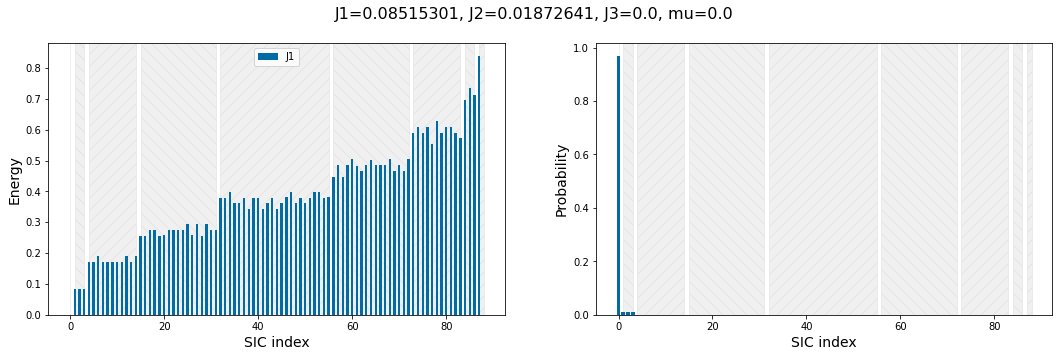

In [223]:
def plot_E_p_H_ryd(structure,J1,J2,J3,mu=0.0,config_unique=[],multiplicity=[]):
    
    #mu is defined in terms of the fraction of J1, so the term that is added to the J1 terms is J1*mu

    structure = Molecule(graphene_scell.atomic_numbers,graphene_scell.cart_coords)

    configurations = np.array(list(itertools.product([0, 1], repeat=structure.num_sites)))
    atom_indices = get_all_configurations_no_pbc(structure)
    J1 += J1*mu
    #print('J1',J1,'J2',J2)
    E_structure = get_final_ryd_Hamiltonian_v2_bruno(
    coords, 
    detuning = 125000000.0,
    J1=J1, 
    J2=J2,
    J3=J3,
    C6 = 5.42e-24
    )[0]
    
    if len(config_unique) == 0: 
        config_unique, E_structure, multiplicity  = find_sic(configurations,atom_indices,energies=E_structure,sort=True)
        
#     Q_structure = build_adjacency_matrix(structure,max_neigh=2)

#     nn = np.where(Q_structure==1.)
#     Q_structure[nn] = J2

#     nnn = np.where(Q_structure==2.)
#     Q_structure[nnn] = J3
    
#     # Add the chemical potential (still calling it J1)
#     J1 += J1*mu
#     np.fill_diagonal(Q_structure,J1)

#     E_structure = []
#     E_structure_J1 = []
#     E_structure_J2 = []


#     for config in config_unique:
#         E_structure.append(classical_energy(config,Q_structure))
#         E_structure_J1.append(J1_energy(config,Q_structure))
#         E_structure_J2.append(J2_energy(config,Q_structure))
#     E_structure

    E_structure = np.array(E_structure)

    # Calculate the minimum and maximum values
    min_val = np.min(E_structure)
    max_val = np.max(E_structure)

    n_ones = np.sum(config_unique,axis=1)
    #config_unique_sorted = np.array(config_unique)[np.argsort(n_ones)]
    n_ones[:-1]-n_ones[1:]
    areas = np.where(np.sort(n_ones)[:-1]-np.sort(n_ones)[1:] == -1)[0]
    areas = np.append(-1,areas)
    areas = np.append(areas,len(config_unique))
    # Normalize the dataset
    E_structure_normalised = (E_structure - min_val) / (max_val - min_val)

    Z, pi = get_partition_function(E_structure, multiplicity, T=298.15, return_pi=True, N_N=0, N_potential=0.)
    print(np.argmax(pi))

    fig, axs = plt.subplots(1,2,figsize=(18, 5), sharey=False)
    fig.suptitle('J1={}, J2={}, J3={}, mu={}'.format(J1,J2,J3,J1*mu,),fontsize=16)
    
    colors = ['#CECECE50','#DEDEDE']

    hatchs = ['//','\\\\']
    for i in range(len(areas)-1):
        #print(areas[i]+1, areas[i+1])
        axs[0].axvspan(areas[i]+1, areas[i+1], color=colors[0], hatch=hatchs[i%2], alpha=0.3,)
        axs[1].axvspan(areas[i]+1, areas[i+1], color=colors[0], hatch=hatchs[i%2], alpha=0.3,)
    #plt.bar(np.arange(len(E_structure)),E_structure,width=0.5)
    

    axs[0].bar(np.arange(len(E_structure)),E_structure,width=0.5,label='J1')

    axs[0].set_xlabel('SIC index',fontsize=14)
    axs[0].set_ylabel('Energy',fontsize=14)
    axs[0].legend()

    axs[1].bar(np.arange(len(E_structure)),pi)
    axs[1].set_xlabel('SIC index',fontsize=14)
    axs[1].set_ylabel('Probability',fontsize=14)
    plt.show()
    
plot_E_p_H_ryd(structure,J1=0.08515301, 
                J2=0.01872641,
                J3=0.000,mu=0.0,config_unique=[],multiplicity=[])

7.629085082087569e-06
0.98362092 0.8391231991541109


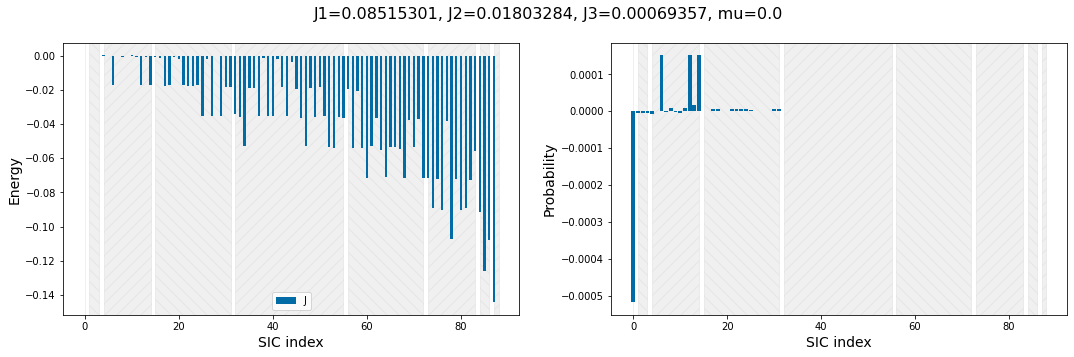

In [241]:
def plot_E_p_differences(structure,J1,J2,J3,mu=0.0,config_unique=[],multiplicity=[]):
    
    #mu is defined in terms of the fraction of J1, so the term that is added to the J1 terms is J1*mu

    #structure = Molecule(graphene_scell.atomic_numbers,graphene_scell.cart_coords)

    configurations = np.array(list(itertools.product([0, 1], repeat=structure.num_sites)))
    atom_indices = get_all_configurations_no_pbc(structure)
    J1 += J1*mu
    #print('J1',J1,'J2',J2)
    E_structure = get_final_ryd_Hamiltonian_v2_bruno(
    coords, 
    detuning = 125000000.0,
    J1=J1, 
    J2=J2+J3,
    J3=0,
    C6 = 5.42e-24
    )[0]
    
    if len(config_unique) == 0: 
        config_unique, E_structure, multiplicity  = find_sic(configurations,atom_indices,energies=E_structure,sort=True)
    
    # QUBO
    Q_structure = build_adjacency_matrix(structure,max_neigh=2)

    nn = np.where(Q_structure==1.)
    Q_structure[nn] = J2

    nnn = np.where(Q_structure==2.)
    Q_structure[nnn] = J3
    
    # Add the chemical potential (still calling it J1)
    J1 += J1*mu
    np.fill_diagonal(Q_structure,J1)

    E_structure_QUBO = []
#     E_structure_J1 = []
#     E_structure_J2 = []


    for config in config_unique:
        E_structure_QUBO.append(classical_energy(config,Q_structure))
#         E_structure_J1.append(J1_energy(config,Q_structure))
#         E_structure_J2.append(J2_energy(config,Q_structure))
    

    E_structure_QUBO = np.array(E_structure_QUBO)

    # Calculate the minimum and maximum values
    min_val = np.min(E_structure)
    max_val = np.max(E_structure)

    n_ones = np.sum(config_unique,axis=1)
    #config_unique_sorted = np.array(config_unique)[np.argsort(n_ones)]
    n_ones[:-1]-n_ones[1:]
    areas = np.where(np.sort(n_ones)[:-1]-np.sort(n_ones)[1:] == -1)[0]
    areas = np.append(-1,areas)
    areas = np.append(areas,len(config_unique))
    # Normalize the dataset
    E_structure_normalised = (E_structure - min_val) / (max_val - min_val)
    
    Z_ryd, pi_ryd = get_partition_function(E_structure, multiplicity, T=298.15, return_pi=True, N_N=0, N_potential=0.)
    Z_QUBO, pi_QUBO = get_partition_function(E_structure_QUBO, multiplicity, T=298.15, return_pi=True, N_N=0, N_potential=0.)
    #print(np.argmax(pi))
    print(E_structure_QUBO[-1],E_structure[-1])

    fig, axs = plt.subplots(1,2,figsize=(18, 5), sharey=False)
    fig.suptitle('J1={}, J2={}, J3={}, mu={}'.format(J1,J2,J3,J1*mu,),fontsize=16)
    
    colors = ['#CECECE50','#DEDEDE']

    hatchs = ['//','\\\\']
    for i in range(len(areas)-1):
        #print(areas[i]+1, areas[i+1])
        axs[0].axvspan(areas[i]+1, areas[i+1], color=colors[0], hatch=hatchs[i%2], alpha=0.3,)
        axs[1].axvspan(areas[i]+1, areas[i+1], color=colors[0], hatch=hatchs[i%2], alpha=0.3,)
    #plt.bar(np.arange(len(E_structure)),E_structure,width=0.5)
    

    axs[0].bar(np.arange(len(E_structure)),E_structure-E_structure_QUBO,width=0.5,label='J')

    axs[0].set_xlabel('SIC index',fontsize=14)
    axs[0].set_ylabel('Energy',fontsize=14)
    axs[0].legend()

    axs[1].bar(np.arange(len(E_structure)),pi_ryd-pi_QUBO)
    axs[1].set_xlabel('SIC index',fontsize=14)
    axs[1].set_ylabel('Probability',fontsize=14)
    plt.show()
    
plot_E_p_differences(structure,J1=0.08515301, 
                J2=0.01803284,
                J3=0.00069357,mu=0.0,config_unique=[],multiplicity=[])

potential =-200%
7.629085082087569e-06
88 88


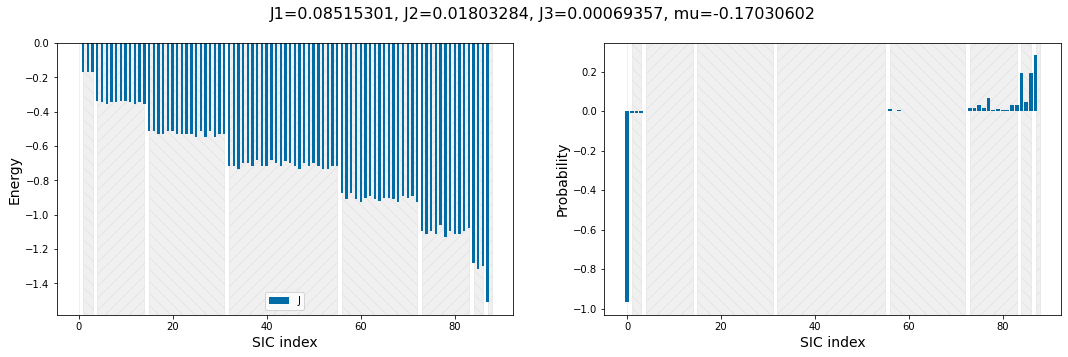

In [238]:
pot = [-2.00000000e+00, -1.90000000e+00, -1.80000000e+00, -1.70000000e+00,
       -1.60000000e+00, -1.50000000e+00, -1.40000000e+00, -1.30000000e+00,
       -1.20000000e+00, -1.10000000e+00,  -9.00000000e-01,
       -8.00000000e-01, -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
       -4.00000000e-01, -3.00000000e-01, -2.00000000e-01, -1.00000000e-01,
        1.77635684e-15,  1.00000000e-01,  2.00000000e-01,  3.00000000e-01,
        4.00000000e-01,  5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
        8.00000000e-01,  9.00000000e-01,  1.00000000e+00,  1.10000000e+00,
        1.20000000e+00,  1.30000000e+00,  1.40000000e+00,  1.50000000e+00,
        1.60000000e+00,  1.70000000e+00,  1.80000000e+00,  1.90000000e+00]
for potential in pot[0:1]:
    print('potential ={}%'.format(round(potential*100),4))
    plot_E_p_differences(structure,J1=0.08515301, 
                J2=0.01803284,
                J3=0.00069357,mu=potential,config_unique=[],multiplicity=[])
#     plot_E_p_H_ryd(structure,J1=0.08515301, 
#                 J2=0.01872641,
#                 J3=0.000,mu=potential,config_unique=[],multiplicity=[])

In [74]:
vview(graphene_scell_no_pbc_no_single_2)

potential =-400%
87


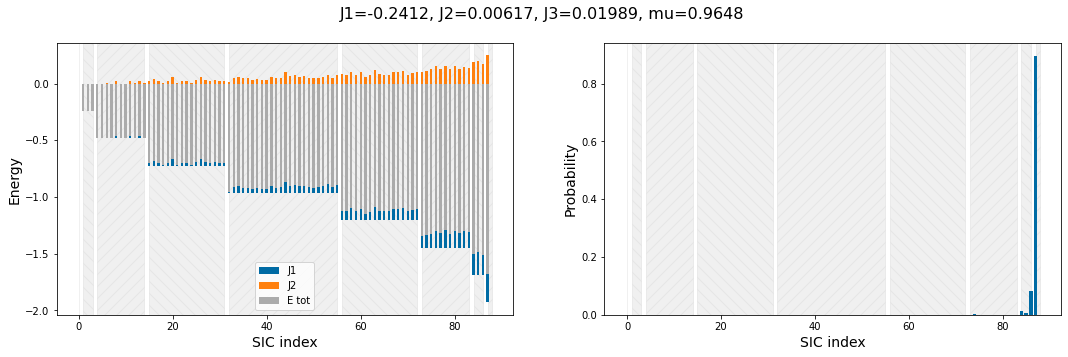

potential =-300%
86


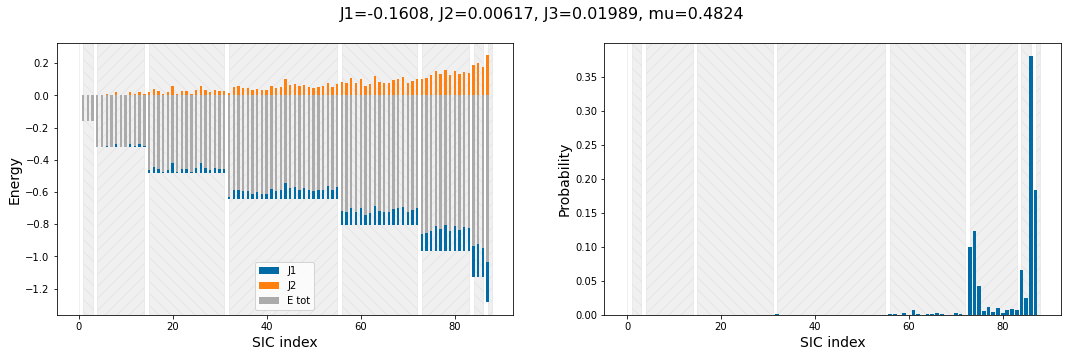

potential =-200%
32


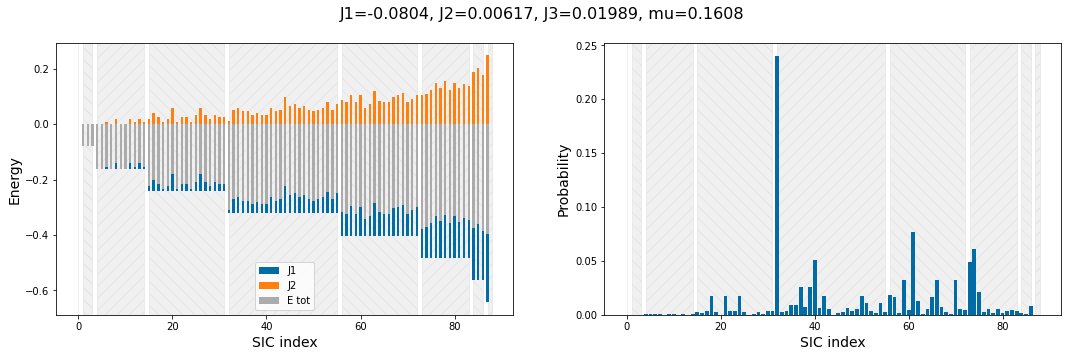

potential =-100%
0


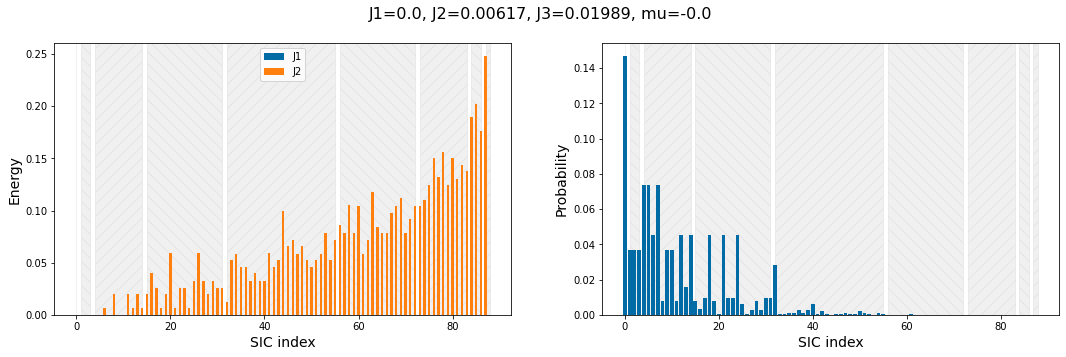

In [120]:
structure = copy.deepcopy(graphene_scell_8)
#config_unique = np.genfromtxt('data/config_unique_graphene_scell_no_pbc_no_single_3.csv', delimiter=',')
#multiplicity = np.genfromtxt('data/multiplicity_graphene_scell_no_pbc_no_single_3.csv', delimiter=',')
        
for potential in np.arange(-4,0,1):
    print('potential ={}%'.format(round(potential*100),4))
    plot_E_p_QUBO(structure,J1=0.0804,J2=0.00617,J3=0.01989,mu=potential,
                  config_unique=config_unique,multiplicity=multiplicity)

Considerations:
- by changing J1 we are changing the orange component to the graph (grand canonical ensemble)
- J1 == 0 only the J2 energy influences the partition function
- In the final calculation of Z, we need to use the original qubo
- structure 32 is an artifact

## <a id='no_pbc'> Non-periodic boundary conditions</a>
# HERE

## New SIC idea
- get the atom_indices for the pure structure
- Get the SIC for 1 N
- Get the inequivalent atoms (?)

In [62]:
from pymatgen.core.structure import Lattice
coord = [[0,0,0],[1,0,0],[1,1,0],[0,1,0]]

square_lattice = Lattice.from_parameters(5,5,100,90,90,90)
square_test = Molecule([1]*4,coord)

# vview(square_test)
print(PointGroupAnalyzer(square_test).get_equivalent_atoms()['eq_sets'])
      
square_test_1 = Molecule([2,1,1,1],coord)
print(PointGroupAnalyzer(square_test_1).get_equivalent_atoms()['eq_sets'])

square_test_2 = Molecule([2,2,1,1],coord)
print(PointGroupAnalyzer(square_test_2).get_equivalent_atoms()['eq_sets'])

square_test_3 = Molecule([2,2,2,1],coord)
print(PointGroupAnalyzer(square_test_3).get_equivalent_atoms()['eq_sets'])

defaultdict(<class 'set'>, {0: {0, 1, 2, 3}})
defaultdict(<class 'set'>, {1: {1, 3}, 2: {2}, 0: {0}})
defaultdict(<class 'set'>, {2: {2, 3}, 1: {1}})
defaultdict(<class 'set'>, {0: {0, 2}, 1: {1}, 3: {3}})


In [148]:
for s in np.array(sic_all):
    print(s)

[1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[6 6 1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[6 6 6 6 6 6 1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[1 1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[1 6 6 1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[1 6 6 6 6 1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[1 6 6 6 6 6 6 6 6 6 1 6 6 6 6 6 6 6 6 6 6 6 6 6]
[1 6 6 6 6 6 6 6 6 6 6 1 6 6 6 6 6 6 6 6 6 6 6 6]
[1 6 6 6 6 6 6 6 6 6 6 6 1 6 6 6 6 6 6 6 6 6 6 6]
[1 6 6 6 6 6 6 6 6 6 6 6 6 1 6 6 6 6 6 6 6 6 6 6]
[1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 6 6 6 6 6]
[1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 6 6 6]
[1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 6]
[1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1]
[1 6 1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[1 6 6 6 1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[1 6 6 6 6 6 6 6 6 1 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[1 6 6 6 6 6 6 6 6 6 6 6 6 6 1 6 6 6 6 6 6 6 6 6]
[1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 6 6 6 6]


In [149]:
import time
sic_all = []
structure_previous_step = [graphene_mol]
counter = 0
time_0 = time.time()
time_all = []
while counter <4:
    print(time.time()-time_0)
    print(len(structure_previous_step))
    time_all.append(time.time()-time_0)
    
    time_0 = time.time()
    for structure_ps in structure_previous_step:
        structures_tmp = []
        for k in PointGroupAnalyzer(structure_ps).get_equivalent_atoms()['eq_sets'].keys():
            site = list(PointGroupAnalyzer(structure_ps).get_equivalent_atoms()['eq_sets'][k])[0]
            atomic_numbers = np.array(structure_ps.atomic_numbers)
            atomic_numbers[site] = 1
            sic_all.append(atomic_numbers)
            molecule_tmp = Molecule(atomic_numbers,graphene_mol.cart_coords)
            
            structures_tmp.append(molecule_tmp)
            
#             print(k,PointGroupAnalyzer(molecule_tmp).get_equivalent_atoms()['eq_sets'])
#             print()
#     print('#################################################3')
    structure_previous_step = copy.deepcopy(structures_tmp)
    counter += 1
    
print(len(np.array(sic_all)))

0.00024962425231933594
1
0.12723112106323242
3
1.3444809913635254
14
7.315272808074951
7
473


In [154]:
#MORE EFFICIENT
import time
sic_all = []
structure_previous_step = [graphene_mol]
counter = 0
time_0 = time.time()
time_all = []

cart_coords = graphene_mol.cart_coords

while counter <4:
    print(len(structure_previous_step),time.time()-time_0)
    time_all.append(time.time()-time_0)
    
    time_0 = time.time()
    for structure_ps in structure_previous_step:
        structures_tmp = []
        pg_analyzer = PointGroupAnalyzer(structure_ps)
        print(pg_analyzer.get_equivalent_atoms()['eq_sets'].items())
        for k, eq_set in pg_analyzer.get_equivalent_atoms()['eq_sets'].items():
            
            site = list(eq_set)[0]
#             print(site)
#         for k in PointGroupAnalyzer(structure_ps).get_equivalent_atoms()['eq_sets'].keys():
            site = list(PointGroupAnalyzer(structure_ps).get_equivalent_atoms()['eq_sets'][k])[0]
            atomic_numbers = np.array(structure_ps.atomic_numbers)
            atomic_numbers[site] = 1
            sic_all.append(atomic_numbers)
            molecule_tmp = Molecule(atomic_numbers,cart_coords)
            
            structures_tmp.append(molecule_tmp)
            
#             print(k,PointGroupAnalyzer(molecule_tmp).get_equivalent_atoms()['eq_sets'])
#             print()
#     print('#################################################3')
    structure_previous_step = copy.deepcopy(structures_tmp)
    counter += 1
    print()
    
print(len(np.array(sic_all)))

1 0.0004992485046386719
dict_items([(0, {0, 1, 3, 5, 10, 11, 12, 13, 18, 20, 22, 23}), (2, {2, 4, 9, 14, 19, 21}), (6, {6, 7, 8, 15, 16, 17})])

3 0.12602782249450684
dict_items([(0, {0}), (1, {1}), (3, {3}), (5, {5}), (10, {10}), (11, {11}), (12, {12}), (13, {13}), (18, {18}), (20, {20}), (22, {22}), (23, {23}), (2, {2}), (4, {4}), (9, {9}), (14, {14}), (19, {19}), (21, {21}), (6, {6}), (7, {7}), (8, {8}), (15, {15}), (16, {16}), (17, {17})])
dict_items([(0, {0}), (1, {1}), (3, {3}), (5, {5}), (10, {10}), (11, {11}), (12, {12}), (13, {13}), (18, {18}), (20, {20}), (22, {22}), (23, {23}), (2, {2}), (4, {4}), (9, {9}), (14, {14}), (19, {19}), (21, {21}), (6, {6}), (7, {7}), (8, {8}), (15, {15}), (16, {16}), (17, {17})])
dict_items([(0, {0, 1}), (3, {10, 3}), (5, {11, 5}), (12, {18, 12}), (13, {20, 13}), (22, {22, 23}), (2, {2}), (4, {9, 4}), (14, {19, 14}), (21, {21}), (6, {6}), (7, {8, 7}), (15, {16, 15}), (17, {17})])

14 1.318554162979126
dict_items([(0, {0}), (1, {1}), (3, {3}), (5,

In [ ]:
import time
import numpy as np
import copy
# from pymatgen.analysis.point_group import PointGroupAnalyzer
from pymatgen.core.structure import Molecule

sic_all = []
structure_previous_step = [graphene_mol]
counter = 0
time_0 = time.time()
time_all = []

while counter < 4:
    print(time.time() - time_0)
    time_all.append(time.time() - time_0)
    time_0 = time.time()
    
    structures_tmp = []
    for structure_ps in structure_previous_step:
        pg_analyzer = PointGroupAnalyzer(structure_ps)
        for k, eq_set in pg_analyzer.get_equivalent_atoms()['eq_sets'].items():
            site = list(eq_set)[0]
            atomic_numbers = np.copy(structure_ps.atomic_numbers)
            atomic_numbers[site] = 1
            sic_all.append(atomic_numbers)
            molecule_tmp = Molecule(atomic_numbers, graphene_mol.cart_coords)
            structures_tmp.append(molecule_tmp)
    
    structure_previous_step = copy.deepcopy(structures_tmp)
    counter += 1

print(len(np.array(sic_all)))


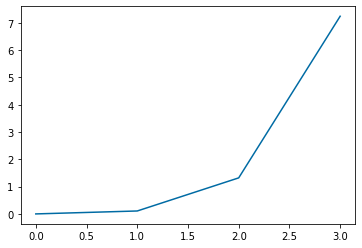

In [137]:
plt.plot(time_all)

AttributeError: 'Molecule' object has no attribute 'replace'

In [27]:
get_all_configurations_no_pbc(square_lattice)

AttributeError: 'Lattice' object has no attribute 'get_centered_molecule'

In [14]:
len(PointGroupAnalyzer(graphene_mol).get_symmetry_operations())

24

In [17]:
cry_pmg2gui(graphene_mol,pbc=[False,False,False]).write_gui('../rydberg_atoms/data/crystal/graphene/graphene_54_initial.gui')
graphene_mol.cart_coords[[25,17,35,12,21,3,8,30,9,29,7,28],:]

array([[ 1.23386207e+00, -3.56185299e+00,  0.00000000e+00],
       [-1.94396951e-15, -5.69896479e+00,  0.00000000e+00],
       [-2.46772414e+00,  1.42474120e+00,  0.00000000e+00],
       [ 2.46772414e+00, -5.69896479e+00,  0.00000000e+00],
       [-3.70158621e+00,  4.98659419e+00,  0.00000000e+00],
       [ 1.23386207e+00,  7.12370599e-01,  0.00000000e+00],
       [-2.46772414e+00,  2.84948239e+00,  0.00000000e+00],
       [ 1.23386207e+00, -7.12370599e-01,  0.00000000e+00],
       [-2.46772414e+00, -5.69896479e+00,  0.00000000e+00],
       [-1.23386207e+00, -4.98659419e+00,  0.00000000e+00],
       [-4.93544828e+00, -1.42474120e+00,  0.00000000e+00],
       [-1.23386207e+00,  3.56185299e+00,  0.00000000e+00]])

In [28]:
atoms = 6*[6]+[1]*6
a = Molecule(atoms,graphene_mol.cart_coords[[25,17,35,12,21,3,8,30,9,29,7,28],:])
a.translate_sites(np.arange(12),-a.center_of_mass)
b =cry_pmg2gui(a,pbc=[False,False,False])
b.write_gui('./data/crystal/benzene/benzene.gui')

In [545]:
graphene_mol.remove_sites([1,10,4,7,15,14,2,11])

In [29]:
atom_types = np.array([6]*72)

atom_index = [18,10,22,52,71,55,27,35,26,53,61,49,19,0,16,44,36,45]
atom_types[atom_index] = 1
a = (Molecule(atom_types,graphene_mol.cart_coords))
a.translate_sites(np.arange(71),-a.center_of_mass)
cry_pmg2gui(a,pbc=[False,False,False]).write_gui('./data/crystal/graphene/graphene_54.gui')

In [584]:
a.cart_coords/7.12370599e-01

array([[-3.46410161e+00,  1.00000000e+00,  0.00000000e+00],
       [-1.73205081e+00,  2.00000000e+00,  0.00000000e+00],
       [-2.80528344e-15,  1.00000000e+00,  0.00000000e+00],
       [ 1.73205081e+00,  2.00000000e+00,  0.00000000e+00],
       [ 3.46410161e+00,  1.00000000e+00,  0.00000000e+00],
       [ 3.46410161e+00, -1.00000000e+00,  0.00000000e+00],
       [ 1.73205081e+00, -2.00000000e+00,  0.00000000e+00],
       [-2.80528344e-15, -1.00000000e+00,  0.00000000e+00],
       [-1.73205081e+00, -2.00000000e+00,  0.00000000e+00],
       [-3.46410161e+00, -1.00000000e+00,  0.00000000e+00]])

In [565]:
cry_pmg2gui(graphene_mol,pbc=[False,False,False]).write_gui('./data/crystal/graphene/graphene_24.gui')

In [558]:
a.translate_sites(np.arange(18),-a.center_of_mass)

In [587]:
vview(graphene_mol)

In [ ]:
graphene_mol_no_h = cut_graphene(graphene,size=15)
print(graphene_mol_no_h.num_sites)
#vview(graphene_mol_no_h)

#### Replace the external C atoms with H atoms

In [414]:
def build_adjacency_matrix(structure, max_neigh = 1, diagonal_terms = False, triu = False):
    # structure = pymatgen Structure object
    
    num_sites = structure.num_sites
    distance_matrix_pbc = np.round(structure.distance_matrix,5)

    distance_matrix = np.zeros((num_sites,num_sites),float)
    
    shells = np.unique(distance_matrix_pbc[0])
    
    for i,s in enumerate(shells[0:max_neigh+1]):
        row_index = np.where(distance_matrix_pbc == s)[0]
        col_index = np.where(distance_matrix_pbc == s)[1]
        distance_matrix[row_index,col_index] = i
    
    if triu == True:
        distance_matrix = np.triu(distance_matrix,0)
    
    if diagonal_terms == True:
        np.fill_diagonal(distance_matrix,[1]*num_sites)
    
    return distance_matrix

build_adjacency_matrix(graphene_scell,max_neigh = 2)

array([[0., 1., 2., 2., 0., 0., 0., 0.],
       [1., 0., 1., 1., 2., 2., 0., 0.],
       [2., 1., 0., 2., 1., 0., 2., 0.],
       [2., 1., 2., 0., 0., 1., 2., 0.],
       [0., 2., 1., 0., 0., 2., 1., 2.],
       [0., 2., 0., 1., 2., 0., 1., 2.],
       [0., 0., 2., 2., 1., 1., 0., 1.],
       [0., 0., 0., 0., 2., 2., 1., 0.]])

In [535]:
adj_matrix = build_adjacency_matrix(graphene_mol, max_neigh = 1)
h_atom_sites = np.where(np.unique(np.where(adj_matrix==1)[0],return_counts=True)[1]==1)[0]
atom_numbers = np.array(graphene_mol.atomic_numbers)
atom_numbers[h_atom_sites] = 1
graphene_mol_h = Molecule(atom_numbers,graphene_mol.cart_coords)
graphene_mol_h_96 = copy.deepcopy(graphene_mol_h)

In [536]:
vview(graphene_mol_h)

In [539]:
gui = cry_pmg2gui(graphene_mol_h,pbc=[False,False,False])
gui.write_gui('./data/crystal/graphene/graphene_24_h_12.gui')

#### Write the structure to a gui file

In [ ]:
graphene_mol_h_gui = cry_pmg2gui(graphene_mol_h,pbc=[False, False, False],symmetry=True)
graphene_mol_h_gui.write_gui('./data/crystal/graphene/graphene_252_h_36.gui',symm=True)

Avogadro optimisation

In [ ]:
from pymatgen.io.xyz import XYZ
#XYZ(graphene_mol_h).write_file('./data/crystal/graphene/graphene_96_h_24.xyz')
xyz_file = XYZ.from_file('./data/crystal/graphene/graphene_96_h_24.xyz')
graphene_mol_h_gui = cry_pmg2gui(xyz_file.molecule,pbc=[False, False, False],symmetry=True)
graphene_mol_h_gui.write_gui('./data/crystal/graphene/graphene_96_h_24.gui')

In [17]:
graphene_mol_h_96_opt = cry_gui2pmg(Crystal_gui().read_gui('data/crystal/graphene/graphene_96_h_24.gui'))
graphene_mol_h_96_opt = Molecule(graphene_mol_h_96_opt.atomic_numbers,graphene_mol_h_96_opt.cart_coords)

In [18]:
atom_indices_96 = get_all_configurations_no_pbc(graphene_mol_h_96_opt)

First generate all the SICs with 1 dopant atoms

In [19]:
def generate_1_doped_structures(molecule,dopant,active_species=None):
    
    molecules_1_dopant = []
    
    ineq_atoms = PointGroupAnalyzer(molecule).get_equivalent_atoms()['eq_sets'].keys()
    ineq_atoms = [x for x in ineq_atoms]
    
    # C only
    if active_species is not None:
        C_atom_index = np.where(np.array(molecule.atomic_numbers) == active_species)
        ineq_atoms = np.intersect1d(ineq_atoms,C_atom_index)
    
    for site in ineq_atoms:
        molecule_tmp = copy.deepcopy(molecule)
        atomic_numbers = np.array(molecule_tmp.atomic_numbers)
        atomic_numbers[site] = dopant
        coordinates = molecule_tmp.cart_coords
        molecules_1_dopant.append(Molecule(atomic_numbers,coordinates))
        
    return molecules_1_dopant
molecules_1_dopant = generate_1_doped_structures(graphene_mol_h_96,7,active_species=6)  

NameError: name 'graphene_mol_h_96' is not defined

First generate all the SICs with 2 adjacent dopant atoms

In [ ]:
def generate_2_doped_structures(molecules_1_dopant,dopant,active_species=None):
    
    molecules_2_dopant = []
    
    
    
    for molecule in molecules_1_dopant:
        
        if active_species is not None:
            C_atom_index = np.where(np.array(molecules_1_dopant[0].atomic_numbers) == active_species)
        else:
            C_atom_index = np.arange(molecules_1_dopant[0].num_sites)
        ineq_atoms_nn = np.array(molecule.atomic_numbers)
        dopant_site = np.where(ineq_atoms_nn==dopant)[0][0]
        
        all_nn = np.argsort(molecule.distance_matrix[dopant_site] )[1:4]
        nn_index = np.intersect1d(all_nn,C_atom_index)
        #print(dopant_site,nn_index)
        
        for site in nn_index:

            molecule_tmp = copy.deepcopy(molecule)
            atomic_numbers = np.array(molecule_tmp.atomic_numbers)
            atomic_numbers[site] = dopant
            coordinates = molecule_tmp.cart_coords
            molecules_2_dopant.append(Molecule(atomic_numbers,coordinates))
    return molecules_2_dopant
#     # C only
#     if active_species is not None:
#         C_atom_index = np.where(np.array(molecule.atomic_numbers) == active_species)
#         ineq_atoms = np.intersect1d(ineq_atoms,C_atom_index)
    

#     return molecules_1_dopant
molecules_2_dopant = generate_2_doped_structures(molecules_1_dopant[0:10],7,active_species=6)  

First generate the SIC randomly. For 2 dopant atoms, we can provide the list of adjacent SIC via config_unique.

In [ ]:
def generate_random_structures(initial_molecule,atom_indices,N_atoms,new_species,
                               N_config,DFT_config,active_sites=False,return_multiplicity=False,
                              config_unique=[]):
    
    """
    Generate random symmetry-independent structures by replacing sites in the initial molecule.

    Args:
        initial_molecule (Molecule): The initial molecule structure.
        atom_indices (list): Indices obtained from get_all_configurations.
        N_atoms (int): Number of sites to replace.
        new_species (int): New atomic number.
        N_config (int): Number of attempts.
        DFT_config (int): Number of final structures generated.
        active_sites (list or bool, optional): Sites in the structure to replace (useful for Al/GaN). 
                                               Default is False.
        return_multiplicity (bool, optional): If True, returns the multiplicity of each unique structure. 
                                              Default is False.
        config_unique (list): the initial list of configurations. 
                              Useful for the 2 dopants where the user already has the adjacent structures.
        
    Returns:
        list of Molecule: List of symmetry-independent structures.

    """

    all_structures = []

    
    if active_sites is False:
        num_sites = initial_molecule.num_sites
        active_sites = np.arange(num_sites)
    else:
        num_sites = len(active_sites)
        
    

    # Generate a random configurations
    descriptor_all = []
    structures_all = []
    config_all = []
    config_unique = []
    config_unique_count = []
    n_sic = 0
    N_attempts= 0
    
    while n_sic < DFT_config and N_attempts <N_config:
        N_attempts += 1
        sites_index = np.random.choice(num_sites,N_atoms,replace=False)

        sites = active_sites[sites_index]
        #print(np.array(initial_molecule.atomic_numbers)[sites])
        structure_tmp = copy.deepcopy(initial_molecule)

        sec = build_symmetry_equivalent_configurations(atom_indices,sites)

        sic = sec[0]
        #print(np.array(initial_molecule.atomic_numbers)[np.where(sic==1)[0]])
        is_in_config_unique = any(np.array_equal(sic, existing_sic) for existing_sic in config_unique)

        if not is_in_config_unique:  
            config_unique.append(sic)

            config_unique_count.append(len(sec))
            n_sic += 1


    final_structures = []
    for config in config_unique:
        
        N_index = np.where(config==1)[0]
        #print(np.array(initial_molecule.atomic_numbers)[N_index])
        atomic_numbers = np.array(initial_molecule.atomic_numbers)
        #print(atomic_numbers[N_index])
        atomic_numbers[N_index] = new_species
        coordinates = initial_molecule.cart_coords
        
        final_structures.append(Molecule(atomic_numbers,coordinates))
    if return_multiplicity == True:
        return final_structures,config_unique_count
    else:
        return final_structures



### Write structures to file

One dopant atom

In [ ]:
for i,struct in enumerate(molecules_1_dopant):
    struct_gui = cry_pmg2gui(struct,pbc=[False, False, False])
    struct_gui.write_gui('data/crystal/graphene/N/graphene_96_h_24_n_1_%s.gui'%i)
    sh.copy('data/crystal/graphene/graphene_96_h_24.d12','data/crystal/graphene/N/graphene_96_h_24_n_1_%s.d12'%i)
    print('timeout 1437m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_96_h_24_n_1_%s &'%i)

Two adjacent dopant atoms

In [ ]:
for i,struct in enumerate(molecules_2_dopant):
    struct_gui = cry_pmg2gui(struct,pbc=[False, False, False])
    struct_gui.write_gui('data/crystal/graphene/N/graphene_96_h_24_n_2_%s.gui'%i)
    sh.copy('data/crystal/graphene/graphene_96_h_24.d12','data/crystal/graphene/N/graphene_96_h_24_n_2_%s.d12'%i)
    print('timeout 1437m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_96_h_24_n_2_%s &'%i)

Random structures

In [ ]:
for n,i in enumerate(range(2,11,1)):
    N_atoms = i
    print(i)
    structures_random = generate_random_structures(graphene_mol_h_96,atom_indices=atom_indices_96,N_atoms=N_atoms,
                                         new_species=7,N_config=500,DFT_config=20,
                                         active_sites=active_sites,return_multiplicity=False,
                                         config_unique=molecules_2_dopant)
    num_structures = len(structures_random)
    train_folder = './data/crystal/graphene/N/train_set/'
    test_folder = './data/crystal/graphene/N/test_set/'
    for m,structure in enumerate(structures_random[0:int(np.ceil(num_structures/2))]):
        
        gui_object = cry_pmg2gui(structure,pbc=[False,False,False],symmetry=True)
        gui_name = 'graphene_96_h_24_n_%s_%s.gui'%(N_atoms,m)
        #gui_object.write_gui(train_folder+gui_name,symm=True)
        sh.copy('data/crystal/graphene/graphene_96_h_24.d12','data/crystal/graphene/N/train_set/graphene_96_h_24_n_%s_%s.gui'%(N_atoms,m))
    for m,structure in enumerate(structures_random[int(np.ceil(num_structures/2)):]):
        gui_object = cry_pmg2gui(structure,pbc=[False,False,False],symmetry=True)
        gui_name = 'graphene_96_h_24_n_%s_%s.gui'%(N_atoms,m)
        #gui_object.write_gui(test_folder+gui_name,symm=True)
        sh.copy('data/crystal/graphene/graphene_96_h_24.d12','data/crystal/graphene/N/test_set/graphene_96_h_24_n_%s_%s.gui'%(N_atoms,m))

In [ ]:
generate_random_structures(graphene_mol_h_96,atom_indices=atom_indices_96,N_atoms=N_atoms,
                                         new_species=7,N_config=1000,DFT_config=20,
                                         active_sites=active_sites,return_multiplicity=True)[1]

In [ ]:
active_sites = np.where(np.array(graphene_mol_h_96.atomic_numbers) == 6)[0]
struct,mult = generate_random_structures(graphene_mol_h_96,atom_indices=atom_indices_96,N_atoms=3,
                                         new_species=7,N_config=500,DFT_config=10,
                                         active_sites=active_sites,return_multiplicity=True)

In [ ]:
for structure in struct:
    vview(structure)

In [ ]:
len(molecules_2_dopant)

# THE END

## <a id='pbc'>Periodic boundary conditions</a>

### Build QUBO from pbc calculations

In [ ]:
def build_ml_qubo(structure,X_train,y_train,max_neigh=1):
    
    #Filter
    distance_matrix = np.round(structure.distance_matrix,5)
    shells = np.unique(np.round(distance_matrix,5))
    num_sites = structure.num_sites
    distance_matrix_filter = np.zeros((num_sites,num_sites),int)

    for i,s in enumerate(shells[0:max_neigh+1]):
        row_index = np.where(distance_matrix == s)[0]
        col_index = np.where(distance_matrix == s)[1]
        distance_matrix_filter[row_index,col_index] = i
    distance_matrix_filter = np.triu(distance_matrix_filter,0)
    np.fill_diagonal(distance_matrix_filter,[1]*num_sites)
    
    #Build the descriptor

    upper_tri_indices = np.where(distance_matrix_filter != 0)
    descriptor = []

    for config in X_train:
        matrix = np.outer(config,config)
        upper_tri_elements = matrix[upper_tri_indices]
        descriptor.append(upper_tri_elements)
        

#     descriptor_all = []
#     for config in all_configurations:
#         matrix = np.outer(config,config)
#         upper_tri_elements = matrix[upper_tri_indices]
#         descriptor_all.append(upper_tri_elements)
    
    descriptor = np.array(descriptor)
    
    from sklearn.linear_model import LinearRegression
    
    
    reg = LinearRegression() #create the object
    reg.fit(descriptor, y_train)
    
    print('R2: ',reg.score(descriptor, y_train))

    Q = np.zeros((num_sites,num_sites))
    Q[upper_tri_indices] = reg.coef_
    
    return Q
    
build_ml_qubo(structure,X_train,y_train,max_neigh=1)
X_train

### Build H$_{\text{ryd}}$ from pbc calculations

In [ ]:
def build_ml_h_ryd(structure,X_train,y_train,max_neigh=1):
    
    C = 5.42e-24
    
    
    #Filter
    distance_matrix = np.round(structure.distance_matrix,5)
    shells = np.unique(np.round(distance_matrix,5))
    num_sites = structure.num_sites
    distance_matrix_filter = np.zeros((num_sites,num_sites),int)

    for i,s in enumerate(shells[0:max_neigh+1]):
        row_index = np.where(distance_matrix == s)[0]
        col_index = np.where(distance_matrix == s)[1]
        distance_matrix_filter[row_index,col_index] = i
    distance_matrix_filter = np.triu(distance_matrix_filter,0)
    np.fill_diagonal(distance_matrix_filter,[1]*num_sites)
    
    #Build the descriptor

    upper_tri_indices = np.where(distance_matrix_filter != 0)
    descriptor = []

    for config in X_train:
        matrix = np.outer(config,config)
        upper_tri_elements = matrix[upper_tri_indices]
        descriptor.append(upper_tri_elements)
        

#     descriptor_all = []
#     for config in all_configurations:
#         matrix = np.outer(config,config)
#         upper_tri_elements = matrix[upper_tri_indices]
#         descriptor_all.append(upper_tri_elements)
    
    descriptor = np.array(descriptor)
    
    from sklearn.linear_model import LinearRegression
    
    
    reg = LinearRegression() #create the object
    reg.fit(descriptor, y_train)
    
    print('R2: ',reg.score(descriptor, y_train))

    Q = np.zeros((num_sites,num_sites))
    Q[upper_tri_indices] = reg.coef_
    
    return Q
    
build_ml_qubo(structure,X_train,y_train,max_neigh=1)
X_train

### Auxiliary qubits method

#### Build the structure

In [10]:
lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

supercell_order = 3
scaling_matrix = np.array([[supercell_order, 0, 0],
                            [0, supercell_order, 0],
                            [0, 0, 1]])
graphene_scell = copy.deepcopy(graphene)
graphene_scell.make_supercell(scaling_matrix)
# Reorder the atoms in the supercell so they follow the convention we are using (top to bottom, left to right).
# ordering = [1,5,0,3,4,7,2,6]
# graphene_scell = Structure(graphene_scell.lattice,graphene_scell.atomic_numbers,
#                            graphene_scell.frac_coords[ordering])
graphene_scell.remove_sites([0,1,2,5,8,11])
ordering = [1,7,0,3,6,10,2,9,5,8,4,11]
# graphene_scell_au = Structure(graphene_scell.lattice,graphene_scell.atomic_numbers,
#                            graphene_scell.frac_coords[ordering])
graphene_scell_au = Molecule(graphene_scell.atomic_numbers,
                           graphene_scell.cart_coords[ordering])

- 10 -> 7
- 8 -> 5
- 9 -> 4
- 11 -> 7

In [ ]:
vview(graphene_scell_au)

In [317]:
def classical_energy(x,q):
    # x is the binary vector
    # q is the qubo matrix
    q = np.triu(q,0)
    E_tmp = np.matmul(x,q)
    E_classical = np.sum(x*E_tmp)
    
    return E_classical

In [63]:
def J1_energy(x,q):
    # x is the binary vector
    # q is the qubo matrix
    
    return np.sum(q.diagonal()*x)

In [64]:
def J2_energy(x,q):
    # x is the binary vector
    # q is the qubo matrix
    q = np.triu(q,1)
    E_tmp = np.matmul(x,q)
    E_classical = np.sum(x*E_tmp)
    
    return E_classical

In [ ]:
Q = -build_adjacency_matrix(graphene_scell_au,triu=True)
# for i in range(graphene_scell_au.num_sites-4):
#     Q[i][i] = 3
# for i in range(graphene_scell_au.num_sites):
#     Q[i][i] = 3
diag = np.array([3,3,3,3,1.5,1.5,3,1,1.5,1.5,1,1])

np.fill_diagonal(Q,diag)
configurations = np.array(list(itertools.product([0, 1], repeat=graphene_scell_au.num_sites)))

all_energy = []

for config in configurations:
    all_energy.append(classical_energy(config,Q))

In [ ]:
np.argsort(all_energy)

In [ ]:
acceptable_configurations = []
acceptable_energies = []
acceptable_index = []
non_acceptable_configurations = []
non_acceptable_energies = []
for i,config in enumerate(configurations):
    if np.all(config[[10,8,9,11]] == config[[7,5,4,7]]):
        acceptable_configurations.append(config)
        acceptable_energies.append(all_energy[i])
        acceptable_index.append(i)
    else:
        non_acceptable_configurations.append(config)
        non_acceptable_energies.append(all_energy[i])

### Energy

In [ ]:
# 2 adjacent vacancies
x = np.zeros(graphene_scell_au.num_sites)
x[1] = 1
x[2] = 1

print(classical_energy(x,Q))

x = np.zeros(graphene_scell_au.num_sites)
x[2] = 1
x[7] = 1
x[10] = 1
x[11] = 1

print(classical_energy(x,Q))

In [ ]:
def get_partition_function(energy, multiplicity, T=298.15, return_pi=True, N_N=0, N_potential=0.):
    """
    Calculate the partition function and probabilities for different energy levels.
    
    Args:
        energy (np.ndarray): Array of energy levels.
        multiplicity (np.ndarray): Array of corresponding multiplicities.
        T (float, optional): Temperature in Kelvin. Default is 298.15 K.
        return_pi (bool, optional): Flag to return probabilities. Default is True.
        N_N (float, optional): Number of N particles. Default is 0.
        N_potential (float, optional): Potential for N particles. Default is 0.

    Returns:
        tuple or float: If return_pi is True, returns a tuple containing partition function and probabilities.
                        Otherwise, returns the partition function.
    """
    k_b = 8.617333262145e-05  # Boltzmann constant in eV/K
    
    energy = np.array(energy)
    multiplicity = np.array(multiplicity)
    p_i = multiplicity * np.exp((-energy + (N_N * N_potential)) / (k_b * T))
    pf = np.sum(p_i)
    
    p_i /= pf
    
    if return_pi:
        return pf, p_i
    else:
        return pf

In [ ]:
multiplicity = np.ones(len(all_energy))
Z,pi = get_partition_function(all_energy, multiplicity, T=298.15, return_pi=True, N_N=0, N_potential=0.)

In [ ]:
plt.plot(np.arange(len(pi)),pi)

### Fixed composition

#### Acceptable + non acceptable

In [ ]:
configurations[two_vac_index][0]

In [ ]:
four_vac_index = np.where(np.sum(configurations,axis=1)==4)[0]

In [ ]:
three_vac_index = np.where(np.sum(configurations,axis=1)==3)[0]

In [ ]:
two_vac_index = np.where(np.sum(configurations,axis=1)==2)[0]

In [ ]:
two_three_vac_index = np.sort(np.append(two_vac_index,three_vac_index))
two_three_four_vac_index = np.sort(np.append(two_three_vac_index,four_vac_index))

In [ ]:
energies = 0.01*np.array(all_energy)[two_three_four_vac_index]
multiplicity = np.ones(len(energies))
Z,pi = get_partition_function(energies, multiplicity, T=298.15, return_pi=True, N_N=0, N_potential=0.)

In [ ]:
np.argsort(pi)

In [ ]:
configurations[two_three_four_vac_index][0]

In [ ]:
three_vac_index_2 = np.where(np.sum(configurations[acceptable_index],axis=1)==3)[0]

In [ ]:
np.intersect1d(three_vac_index, acceptable_index)

In [ ]:
indeces = np.where(np.isin(three_vac_index, acceptable_index))[0]

In [ ]:
plt.plot(np.arange(len(energies)),energies,'-o')
#plt.plot(np.arange(len(energies))[indeces],energies[indeces],'o')

In [ ]:
np.sort(energies)

In [ ]:
np.argsort(energies)

In [ ]:
np.where(configurations[two_three_four_vac_index][0]==1)[0]

In [ ]:
plt.plot(np.arange(len(pi)),pi,'-o')
#plt.plot(np.arange(len(pi))[indeces],pi[indeces],'o')

#### Acceptable only

In [ ]:
a = np.array(acceptable_index)[three_vac_index_acc]

In [ ]:
three_vac_index_acc = np.where(np.sum(acceptable_configurations,axis=1)==3)[0]

In [ ]:
energies = 0.01*np.array(all_energy)[three_vac_index_acc]
multiplicity = np.ones(len(energies))
Z,pi = get_partition_function(energies, multiplicity, T=298.15, return_pi=True, N_N=0, N_potential=0.)
plt.plot(np.arange(len(pi)),pi,'-o')